# Constants

In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0' # only relevant to my own environment

I assume that you have downloaded MIDI dataset and uncompssed into `./midi_dataset/groove/` folder  
https://magenta.tensorflow.org/datasets/groove

In [2]:
from glob import glob
filepaths = glob("./midi_dataset/groove/*/*/*beat_4-4.mid")
print(len(filepaths), "midi files found")

(491, 'midi files found')


In [2]:
DRUM_CLASSES = [
   'Kick',
   'Snare',
   'Hi-hat closed',
   'Hi-hat open',
   'Tom low',
   'Tom mid', 
   'Tom high',
   'Clap',
   'Rim' 
]
MIDI_DRUM_MAP = {
   36: 0,
   35: 0,
   38: 1,
   27: 1,
   28: 1,
   31: 1,
   32: 1,
   33: 1,
   34: 1,
   37: 1,
   39: 1,
   40: 1,
   56: 1,
   65: 1,
   66: 1,
   75: 1,
   85: 1,
   42: 2,
   44: 2,
   54: 2,
   68: 2,
   69: 2,
   70: 2,
   71: 2,
   73: 2,
   78: 2,
   80: 2,
   46: 3,
   67: 3,
   72: 3,
   74: 3,
   79: 3,
   81: 3,
   45: 4,
   29: 4,
   41: 4,
   61: 4,
   64: 4,
   84: 4,
   48: 5,
   47: 5,
   60: 5,
   63: 5,
   77: 5,
   86: 5,
   87: 5,
   50: 6,
   30: 6,
   43: 6,
   62: 6,
   76: 6,
   83: 6,
   49: 7,
   55: 7,
   57: 7,
   58: 7,
   51: 8,
   52: 8,
   53: 8,
   59: 8,
   82: 8
}

resolution  = 4 # separate quater into 4  = 16 notes per bar

nb_bars = 2 

len_seq = resolution * 4 * nb_bars # length of drumloops in training data - 2 bars
    
nb_notes = len(DRUM_CLASSES) # number of possible MIDI notes  - max_drum_note - min_drum_note


# Data Preprocessing

Create Piano-roll matrices for the training process

We only use genres with enough data here.

In [3]:
# genres 
all_genres = {}
for path in filepaths:
    _path = os.path.basename(path)
    path = _path.split("_")[1]
    genre = path.split("-")[0]
    if genre not in all_genres:
        all_genres[genre] = 1
    else:
        all_genres[genre] += 1        
print (all_genres)

# genre used. ignore genres without enough data
GENRES = []
for genre, nb in all_genres.iteritems():
    if nb > 25:
        GENRES.append(genre)
print(GENRES)
NB_GENRES = len(GENRES)

NameError: name 'filepaths' is not defined

In [5]:
import random
import numpy as np
import os
import joblib
import pretty_midi
import glob

import matplotlib.pyplot as plt
%matplotlib inline

MIN_NB_ONSETS = 8

drum_dists = {}

def plot_drum_matrix(a):
    if a is not None:
        a = np.transpose(np.squeeze(a))
        plt.matshow(a)
        plt.show()  

# unit timestep = 16th note
def get_pianomatrices_of_drums(midi_file, is_drum=True):
    found = False
    genre_id = -1
    
    # is it in selected genres?
    for id_, genre in enumerate(GENRES):
        if genre in midi_file:
            found = True
            genre_id = id_
            break
    if found is False:
        return None
    
    # load midi file
    try:
        pm = pretty_midi.PrettyMIDI(midi_file)
    except:
        print ("Failed to load midi: ", midi_file)
        return None
        
    # get timiming of quater notes
    beats = pm.get_beats()
    
    # make it to 16th notes
    beats_ticks = [] # converting to ticks
    
    for i in range((len(beats) +1)* 4):
        beats_ticks.append(i * pm.resolution / 4)
    
    num_notes16 = len(beats_ticks)
    print(num_notes16, midi_file)
    
    # maximum duration of one note
    max_duration = 2.0 # 2 quater notes

    # convert ticks to index of 16th note
    def find_note_index(tick, beats_ticks):
        return (np.abs(beats_ticks - tick)).argmin()
    
    def get_timeshift(beats_ticks, grid_id, note_start):
        grid_start = beats_ticks[grid_id]
        tick_diff = note_start - grid_start
        tick_grid = pm.resolution / 4        
        diff_coef= tick_diff / tick_grid * 2.0
        return diff_coef
        
    # # of notes
    notes_length = 4 * nb_bars * resolution

    # create pianoroll matrix (resolution: 16th note))
    found_extra = False # with other than kick/snare/hat
    pianorolls, timeshifts, durations, genre_ids = [], [], [], []
    for instrument in pm.instruments:
        if instrument.is_drum == is_drum:  # use drum tracks only
            
            for note_start in range(0, num_notes16 - 16, 16): # hopsize = 1bar = 16 16th notes
                pianoroll = np.zeros((notes_length, nb_notes), dtype='float') 
                timeshift = np.zeros((notes_length, nb_notes), dtype='float')
                duration = np.zeros((notes_length, nb_notes), dtype='float')

                for note in instrument.notes:
                    idx_start = find_note_index(pm.time_to_tick(note.start), beats_ticks)
                    diff_coef = get_timeshift(beats_ticks, idx_start, pm.time_to_tick(note.start))

                    if note_start <= idx_start and idx_start < note_start + notes_length:
                        if note.pitch in MIDI_DRUM_MAP:
                            drum_note = MIDI_DRUM_MAP[note.pitch]
                            
                            if drum_note in drum_dists:
                                drum_dists[drum_note] += 1
                            else:
                                drum_dists[drum_note] = 1
                            
                            pianoroll[idx_start - note_start, drum_note] = note.velocity / 128.
                            timeshift[idx_start - note_start, drum_note] = diff_coef

                            dur = (pm.time_to_tick(note.end) - pm.time_to_tick(note.start))/ (pm.resolution / 4)
                            dur = min(1.0, max(0, dur / max_duration))
                            duration[idx_start - note_start, drum_note] = dur

                            if drum_note >= 3:
                                found_extra = True
                        else:
                            print("not found", note.pitch )
                
                if np.sum(pianoroll > 0.) >= MIN_NB_ONSETS:
                    pianorolls.append(pianoroll)
                    timeshifts.append(timeshift)
                    durations.append(duration)
                    genre_ids.append(genre_id)
             
    # ignore the first and the last one!
    pianorolls = np.array(pianorolls)
    timeshifts = np.array(timeshifts)
    durations = np.array(durations)
    genre_ids = np.array(genre_ids)
    
    return (pianorolls,timeshifts, durations, genre_ids)

# Start creating piano-roll matrix
matrices_drums_list = joblib.Parallel(n_jobs=-1, verbose=1)(
   joblib.delayed(get_pianomatrices_of_drums)(midi_file, True)     
     for midi_file in filepaths)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


JoblibNameError: JoblibNameError
___________________________________________________________________________
...........................................................................
/home/nao/anaconda2/lib/python2.7/runpy.py in _run_module_as_main(mod_name='ipykernel_launcher', alter_argv=1)
    169     pkg_name = mod_name.rpartition('.')[0]
    170     main_globals = sys.modules["__main__"].__dict__
    171     if alter_argv:
    172         sys.argv[0] = fname
    173     return _run_code(code, main_globals, None,
--> 174                      "__main__", fname, loader, pkg_name)
        fname = '/home/nao/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py'
        loader = <pkgutil.ImpLoader instance>
        pkg_name = ''
    175 
    176 def run_module(mod_name, init_globals=None,
    177                run_name=None, alter_sys=False):
    178     """Execute a module's code without importing it

...........................................................................
/home/nao/anaconda2/lib/python2.7/runpy.py in _run_code(code=<code object <module> at 0x7f73b48a5930, file "/...2.7/site-packages/ipykernel_launcher.py", line 5>, run_globals={'__builtins__': <module '__builtin__' (built-in)>, '__doc__': 'Entry point for launching an IPython kernel.\n\nTh...orts until\nafter removing the cwd from sys.path.\n', '__file__': '/home/nao/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py', '__loader__': <pkgutil.ImpLoader instance>, '__name__': '__main__', '__package__': '', 'app': <module 'ipykernel.kernelapp' from '/home/nao/an...python2.7/site-packages/ipykernel/kernelapp.pyc'>, 'sys': <module 'sys' (built-in)>}, init_globals=None, mod_name='__main__', mod_fname='/home/nao/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py', mod_loader=<pkgutil.ImpLoader instance>, pkg_name='')
     67         run_globals.update(init_globals)
     68     run_globals.update(__name__ = mod_name,
     69                        __file__ = mod_fname,
     70                        __loader__ = mod_loader,
     71                        __package__ = pkg_name)
---> 72     exec code in run_globals
        code = <code object <module> at 0x7f73b48a5930, file "/...2.7/site-packages/ipykernel_launcher.py", line 5>
        run_globals = {'__builtins__': <module '__builtin__' (built-in)>, '__doc__': 'Entry point for launching an IPython kernel.\n\nTh...orts until\nafter removing the cwd from sys.path.\n', '__file__': '/home/nao/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py', '__loader__': <pkgutil.ImpLoader instance>, '__name__': '__main__', '__package__': '', 'app': <module 'ipykernel.kernelapp' from '/home/nao/an...python2.7/site-packages/ipykernel/kernelapp.pyc'>, 'sys': <module 'sys' (built-in)>}
     73     return run_globals
     74 
     75 def _run_module_code(code, init_globals=None,
     76                     mod_name=None, mod_fname=None,

...........................................................................
/home/nao/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py in <module>()
     11     # This is added back by InteractiveShellApp.init_path()
     12     if sys.path[0] == '':
     13         del sys.path[0]
     14 
     15     from ipykernel import kernelapp as app
---> 16     app.launch_new_instance()

...........................................................................
/home/nao/anaconda2/lib/python2.7/site-packages/traitlets/config/application.py in launch_instance(cls=<class 'ipykernel.kernelapp.IPKernelApp'>, argv=None, **kwargs={})
    653 
    654         If a global instance already exists, this reinitializes and starts it
    655         """
    656         app = cls.instance(**kwargs)
    657         app.initialize(argv)
--> 658         app.start()
        app.start = <bound method IPKernelApp.start of <ipykernel.kernelapp.IPKernelApp object>>
    659 
    660 #-----------------------------------------------------------------------------
    661 # utility functions, for convenience
    662 #-----------------------------------------------------------------------------

...........................................................................
/home/nao/anaconda2/lib/python2.7/site-packages/ipykernel/kernelapp.py in start(self=<ipykernel.kernelapp.IPKernelApp object>)
    481         if self.poller is not None:
    482             self.poller.start()
    483         self.kernel.start()
    484         self.io_loop = ioloop.IOLoop.current()
    485         try:
--> 486             self.io_loop.start()
        self.io_loop.start = <bound method ZMQIOLoop.start of <zmq.eventloop.ioloop.ZMQIOLoop object>>
    487         except KeyboardInterrupt:
    488             pass
    489 
    490 launch_new_instance = IPKernelApp.launch_instance

...........................................................................
/home/nao/anaconda2/lib/python2.7/site-packages/tornado/ioloop.py in start(self=<zmq.eventloop.ioloop.ZMQIOLoop object>)
   1059                 self._events.update(event_pairs)
   1060                 while self._events:
   1061                     fd, events = self._events.popitem()
   1062                     try:
   1063                         fd_obj, handler_func = self._handlers[fd]
-> 1064                         handler_func(fd_obj, events)
        handler_func = <function null_wrapper>
        fd_obj = <zmq.sugar.socket.Socket object>
        events = 1
   1065                     except (OSError, IOError) as e:
   1066                         if errno_from_exception(e) == errno.EPIPE:
   1067                             # Happens when the client closes the connection
   1068                             pass

...........................................................................
/home/nao/anaconda2/lib/python2.7/site-packages/tornado/stack_context.py in null_wrapper(*args=(<zmq.sugar.socket.Socket object>, 1), **kwargs={})
    271         # Fast path when there are no active contexts.
    272         def null_wrapper(*args, **kwargs):
    273             try:
    274                 current_state = _state.contexts
    275                 _state.contexts = cap_contexts[0]
--> 276                 return fn(*args, **kwargs)
        args = (<zmq.sugar.socket.Socket object>, 1)
        kwargs = {}
    277             finally:
    278                 _state.contexts = current_state
    279         null_wrapper._wrapped = True
    280         return null_wrapper

...........................................................................
/home/nao/anaconda2/lib/python2.7/site-packages/zmq/eventloop/zmqstream.py in _handle_events(self=<zmq.eventloop.zmqstream.ZMQStream object>, fd=<zmq.sugar.socket.Socket object>, events=1)
    445             return
    446         zmq_events = self.socket.EVENTS
    447         try:
    448             # dispatch events:
    449             if zmq_events & zmq.POLLIN and self.receiving():
--> 450                 self._handle_recv()
        self._handle_recv = <bound method ZMQStream._handle_recv of <zmq.eventloop.zmqstream.ZMQStream object>>
    451                 if not self.socket:
    452                     return
    453             if zmq_events & zmq.POLLOUT and self.sending():
    454                 self._handle_send()

...........................................................................
/home/nao/anaconda2/lib/python2.7/site-packages/zmq/eventloop/zmqstream.py in _handle_recv(self=<zmq.eventloop.zmqstream.ZMQStream object>)
    475             else:
    476                 raise
    477         else:
    478             if self._recv_callback:
    479                 callback = self._recv_callback
--> 480                 self._run_callback(callback, msg)
        self._run_callback = <bound method ZMQStream._run_callback of <zmq.eventloop.zmqstream.ZMQStream object>>
        callback = <function null_wrapper>
        msg = [<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>]
    481         
    482 
    483     def _handle_send(self):
    484         """Handle a send event."""

...........................................................................
/home/nao/anaconda2/lib/python2.7/site-packages/zmq/eventloop/zmqstream.py in _run_callback(self=<zmq.eventloop.zmqstream.ZMQStream object>, callback=<function null_wrapper>, *args=([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],), **kwargs={})
    427         close our socket."""
    428         try:
    429             # Use a NullContext to ensure that all StackContexts are run
    430             # inside our blanket exception handler rather than outside.
    431             with stack_context.NullContext():
--> 432                 callback(*args, **kwargs)
        callback = <function null_wrapper>
        args = ([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],)
        kwargs = {}
    433         except:
    434             gen_log.error("Uncaught exception in ZMQStream callback",
    435                           exc_info=True)
    436             # Re-raise the exception so that IOLoop.handle_callback_exception

...........................................................................
/home/nao/anaconda2/lib/python2.7/site-packages/tornado/stack_context.py in null_wrapper(*args=([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],), **kwargs={})
    271         # Fast path when there are no active contexts.
    272         def null_wrapper(*args, **kwargs):
    273             try:
    274                 current_state = _state.contexts
    275                 _state.contexts = cap_contexts[0]
--> 276                 return fn(*args, **kwargs)
        args = ([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],)
        kwargs = {}
    277             finally:
    278                 _state.contexts = current_state
    279         null_wrapper._wrapped = True
    280         return null_wrapper

...........................................................................
/home/nao/anaconda2/lib/python2.7/site-packages/ipykernel/kernelbase.py in dispatcher(msg=[<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>])
    278         if self.control_stream:
    279             self.control_stream.on_recv(self.dispatch_control, copy=False)
    280 
    281         def make_dispatcher(stream):
    282             def dispatcher(msg):
--> 283                 return self.dispatch_shell(stream, msg)
        msg = [<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>]
    284             return dispatcher
    285 
    286         for s in self.shell_streams:
    287             s.on_recv(make_dispatcher(s), copy=False)

...........................................................................
/home/nao/anaconda2/lib/python2.7/site-packages/ipykernel/kernelbase.py in dispatch_shell(self=<ipykernel.ipkernel.IPythonKernel object>, stream=<zmq.eventloop.zmqstream.ZMQStream object>, msg={'buffers': [], 'content': {u'allow_stdin': True, u'code': u'import random\nimport numpy as np\nimport os\n...le, True)     \n     for midi_file in filepaths)', u'silent': False, u'stop_on_error': True, u'store_history': True, u'user_expressions': {}}, 'header': {u'date': datetime.datetime(2019, 7, 18, 7, 8, 30, 631173, tzinfo=tzutc()), u'msg_id': u'e8b133f6c6ed401ba3b9c356d2fb0956', u'msg_type': u'execute_request', u'session': u'dcd9aabd58d04b10a801ea7f778203c8', u'username': u'username', u'version': u'5.2'}, 'metadata': {}, 'msg_id': u'e8b133f6c6ed401ba3b9c356d2fb0956', 'msg_type': u'execute_request', 'parent_header': {}})
    228             self.log.warn("Unknown message type: %r", msg_type)
    229         else:
    230             self.log.debug("%s: %s", msg_type, msg)
    231             self.pre_handler_hook()
    232             try:
--> 233                 handler(stream, idents, msg)
        handler = <bound method IPythonKernel.execute_request of <ipykernel.ipkernel.IPythonKernel object>>
        stream = <zmq.eventloop.zmqstream.ZMQStream object>
        idents = ['dcd9aabd58d04b10a801ea7f778203c8']
        msg = {'buffers': [], 'content': {u'allow_stdin': True, u'code': u'import random\nimport numpy as np\nimport os\n...le, True)     \n     for midi_file in filepaths)', u'silent': False, u'stop_on_error': True, u'store_history': True, u'user_expressions': {}}, 'header': {u'date': datetime.datetime(2019, 7, 18, 7, 8, 30, 631173, tzinfo=tzutc()), u'msg_id': u'e8b133f6c6ed401ba3b9c356d2fb0956', u'msg_type': u'execute_request', u'session': u'dcd9aabd58d04b10a801ea7f778203c8', u'username': u'username', u'version': u'5.2'}, 'metadata': {}, 'msg_id': u'e8b133f6c6ed401ba3b9c356d2fb0956', 'msg_type': u'execute_request', 'parent_header': {}}
    234             except Exception:
    235                 self.log.error("Exception in message handler:", exc_info=True)
    236             finally:
    237                 self.post_handler_hook()

...........................................................................
/home/nao/anaconda2/lib/python2.7/site-packages/ipykernel/kernelbase.py in execute_request(self=<ipykernel.ipkernel.IPythonKernel object>, stream=<zmq.eventloop.zmqstream.ZMQStream object>, ident=['dcd9aabd58d04b10a801ea7f778203c8'], parent={'buffers': [], 'content': {u'allow_stdin': True, u'code': u'import random\nimport numpy as np\nimport os\n...le, True)     \n     for midi_file in filepaths)', u'silent': False, u'stop_on_error': True, u'store_history': True, u'user_expressions': {}}, 'header': {u'date': datetime.datetime(2019, 7, 18, 7, 8, 30, 631173, tzinfo=tzutc()), u'msg_id': u'e8b133f6c6ed401ba3b9c356d2fb0956', u'msg_type': u'execute_request', u'session': u'dcd9aabd58d04b10a801ea7f778203c8', u'username': u'username', u'version': u'5.2'}, 'metadata': {}, 'msg_id': u'e8b133f6c6ed401ba3b9c356d2fb0956', 'msg_type': u'execute_request', 'parent_header': {}})
    394         if not silent:
    395             self.execution_count += 1
    396             self._publish_execute_input(code, parent, self.execution_count)
    397 
    398         reply_content = self.do_execute(code, silent, store_history,
--> 399                                         user_expressions, allow_stdin)
        user_expressions = {}
        allow_stdin = True
    400 
    401         # Flush output before sending the reply.
    402         sys.stdout.flush()
    403         sys.stderr.flush()

...........................................................................
/home/nao/anaconda2/lib/python2.7/site-packages/ipykernel/ipkernel.py in do_execute(self=<ipykernel.ipkernel.IPythonKernel object>, code=u'import random\nimport numpy as np\nimport os\n...le, True)     \n     for midi_file in filepaths)', silent=False, store_history=True, user_expressions={}, allow_stdin=True)
    203 
    204         self._forward_input(allow_stdin)
    205 
    206         reply_content = {}
    207         try:
--> 208             res = shell.run_cell(code, store_history=store_history, silent=silent)
        res = undefined
        shell.run_cell = <bound method ZMQInteractiveShell.run_cell of <ipykernel.zmqshell.ZMQInteractiveShell object>>
        code = u'import random\nimport numpy as np\nimport os\n...le, True)     \n     for midi_file in filepaths)'
        store_history = True
        silent = False
    209         finally:
    210             self._restore_input()
    211 
    212         if res.error_before_exec is not None:

...........................................................................
/home/nao/anaconda2/lib/python2.7/site-packages/ipykernel/zmqshell.py in run_cell(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, *args=(u'import random\nimport numpy as np\nimport os\n...le, True)     \n     for midi_file in filepaths)',), **kwargs={'silent': False, 'store_history': True})
    532             )
    533         self.payload_manager.write_payload(payload)
    534 
    535     def run_cell(self, *args, **kwargs):
    536         self._last_traceback = None
--> 537         return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
        self.run_cell = <bound method ZMQInteractiveShell.run_cell of <ipykernel.zmqshell.ZMQInteractiveShell object>>
        args = (u'import random\nimport numpy as np\nimport os\n...le, True)     \n     for midi_file in filepaths)',)
        kwargs = {'silent': False, 'store_history': True}
    538 
    539     def _showtraceback(self, etype, evalue, stb):
    540         # try to preserve ordering of tracebacks and print statements
    541         sys.stdout.flush()

...........................................................................
/home/nao/anaconda2/lib/python2.7/site-packages/IPython/core/interactiveshell.py in run_cell(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, raw_cell=u'import random\nimport numpy as np\nimport os\n...le, True)     \n     for midi_file in filepaths)', store_history=True, silent=False, shell_futures=True)
   2709                 self.displayhook.exec_result = result
   2710 
   2711                 # Execute the user code
   2712                 interactivity = "none" if silent else self.ast_node_interactivity
   2713                 has_raised = self.run_ast_nodes(code_ast.body, cell_name,
-> 2714                    interactivity=interactivity, compiler=compiler, result=result)
        interactivity = 'last_expr'
        compiler = <IPython.core.compilerop.CachingCompiler instance>
   2715                 
   2716                 self.last_execution_succeeded = not has_raised
   2717 
   2718                 # Reset this so later displayed values do not modify the

...........................................................................
/home/nao/anaconda2/lib/python2.7/site-packages/IPython/core/interactiveshell.py in run_ast_nodes(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, nodelist=[<_ast.Import object>, <_ast.Import object>, <_ast.Import object>, <_ast.Import object>, <_ast.Import object>, <_ast.Import object>, <_ast.Import object>, <_ast.Expr object>, <_ast.Assign object>, <_ast.FunctionDef object>, <_ast.FunctionDef object>, <_ast.Assign object>], cell_name='<ipython-input-5-7af29fb7ea82>', interactivity='none', compiler=<IPython.core.compilerop.CachingCompiler instance>, result=<ExecutionResult object at 7f73a80b9710, executi..._before_exec=None error_in_exec=None result=None>)
   2813 
   2814         try:
   2815             for i, node in enumerate(to_run_exec):
   2816                 mod = ast.Module([node])
   2817                 code = compiler(mod, cell_name, "exec")
-> 2818                 if self.run_code(code, result):
        self.run_code = <bound method ZMQInteractiveShell.run_code of <ipykernel.zmqshell.ZMQInteractiveShell object>>
        code = <code object <module> at 0x7f7381b028b0, file "<ipython-input-5-7af29fb7ea82>", line 122>
        result = <ExecutionResult object at 7f73a80b9710, executi..._before_exec=None error_in_exec=None result=None>
   2819                     return True
   2820 
   2821             for i, node in enumerate(to_run_interactive):
   2822                 mod = ast.Interactive([node])

...........................................................................
/home/nao/anaconda2/lib/python2.7/site-packages/IPython/core/interactiveshell.py in run_code(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, code_obj=<code object <module> at 0x7f7381b028b0, file "<ipython-input-5-7af29fb7ea82>", line 122>, result=<ExecutionResult object at 7f73a80b9710, executi..._before_exec=None error_in_exec=None result=None>)
   2873         outflag = 1  # happens in more places, so it's easier as default
   2874         try:
   2875             try:
   2876                 self.hooks.pre_run_code_hook()
   2877                 #rprint('Running code', repr(code_obj)) # dbg
-> 2878                 exec(code_obj, self.user_global_ns, self.user_ns)
        code_obj = <code object <module> at 0x7f7381b028b0, file "<ipython-input-5-7af29fb7ea82>", line 122>
        self.user_global_ns = {'DRUM_CLASSES': ['Kick', 'Snare', 'Hi-hat closed', 'Hi-hat open', 'Tom low', 'Tom mid', 'Tom high', 'Clap', 'Rim'], 'GENRES': ['latin', 'jazz', 'soul', 'hiphop', 'rock', 'funk'], 'In': ['', u"import os\nos.environ['CUDA_VISIBLE_DEVICES'] = '0' # only relevant to my own environment", u'from glob import glob\nfilepaths = glob("./mid...mid")\nprint(len(filepaths), "midi files found")', u"# constants\n\nDRUM_CLASSES = [\n   'Kick',\n ...ible MIDI notes  - max_drum_note - min_drum_note", u'# genres \nall_genres = {}\nfor path in filepa...d(genre)\nprint(GENRES)\nNB_GENRES = len(GENRES)', u'import random\nimport numpy as np\nimport os\n...le, True)     \n     for midi_file in filepaths)'], 'MIDI_DRUM_MAP': {22: 2, 26: 3, 36: 0, 37: 1, 38: 1, 40: 1, 42: 2, 43: 4, 44: 2, 45: 4, ...}, 'MIN_NB_ONSETS': 8, 'NB_GENRES': 6, 'Out': {}, '_': '', '__': '', '___': '', ...}
        self.user_ns = {'DRUM_CLASSES': ['Kick', 'Snare', 'Hi-hat closed', 'Hi-hat open', 'Tom low', 'Tom mid', 'Tom high', 'Clap', 'Rim'], 'GENRES': ['latin', 'jazz', 'soul', 'hiphop', 'rock', 'funk'], 'In': ['', u"import os\nos.environ['CUDA_VISIBLE_DEVICES'] = '0' # only relevant to my own environment", u'from glob import glob\nfilepaths = glob("./mid...mid")\nprint(len(filepaths), "midi files found")', u"# constants\n\nDRUM_CLASSES = [\n   'Kick',\n ...ible MIDI notes  - max_drum_note - min_drum_note", u'# genres \nall_genres = {}\nfor path in filepa...d(genre)\nprint(GENRES)\nNB_GENRES = len(GENRES)', u'import random\nimport numpy as np\nimport os\n...le, True)     \n     for midi_file in filepaths)'], 'MIDI_DRUM_MAP': {22: 2, 26: 3, 36: 0, 37: 1, 38: 1, 40: 1, 42: 2, 43: 4, 44: 2, 45: 4, ...}, 'MIN_NB_ONSETS': 8, 'NB_GENRES': 6, 'Out': {}, '_': '', '__': '', '___': '', ...}
   2879             finally:
   2880                 # Reset our crash handler in place
   2881                 sys.excepthook = old_excepthook
   2882         except SystemExit as e:

...........................................................................
/media/nao/f358456d-b6e0-4837-bfc2-1c4705c03467/Dropbox (Qosmo)/DrumVAE_Groove/<ipython-input-5-7af29fb7ea82> in <module>()
    119     return (pianorolls,timeshifts, durations, genre_ids)
    120 
    121 # Start creating piano-roll matrix
    122 matrices_drums_list = joblib.Parallel(n_jobs=-1, verbose=1)(
    123    joblib.delayed(get_pianomatrices_of_drums)(midi_file, True)     
--> 124      for midi_file in filepaths)

...........................................................................
/home/nao/anaconda2/lib/python2.7/site-packages/joblib/parallel.py in __call__(self=Parallel(n_jobs=-1), iterable=<generator object <genexpr>>)
    925                 # No need to wait for async callbacks to trigger to
    926                 # consumption.
    927                 self._iterating = False
    928 
    929             with self._backend.retrieval_context():
--> 930                 self.retrieve()
        self.retrieve = <bound method Parallel.retrieve of Parallel(n_jobs=-1)>
    931             # Make sure that we get a last message telling us we are done
    932             elapsed_time = time.time() - self._start_time
    933             self._print('Done %3i out of %3i | elapsed: %s finished',
    934                         (len(self._output), len(self._output),

---------------------------------------------------------------------------
Joblib worker traceback:
---------------------------------------------------------------------------
NameError                                          Thu Jul 18 16:08:31 2019
PID: 10361                    Python 2.7.15: /home/nao/anaconda2/bin/python
...........................................................................
/home/nao/anaconda2/lib/python2.7/site-packages/joblib/parallel.py in __call__(self=<joblib.parallel.BatchedCalls object>)
    220     def __call__(self):
    221         # Set the default nested backend to self._backend but do not set the
    222         # change the default number of processes to -1
    223         with parallel_backend(self._backend, n_jobs=self._n_jobs):
    224             return [func(*args, **kwargs)
--> 225                     for func, args, kwargs in self.items]
        func = <function get_pianomatrices_of_drums>
        args = ('./midi_dataset/groove/drummer3/session1/49_rock_120_beat_4-4.mid', True)
        kwargs = {}
        self.items = [(<function get_pianomatrices_of_drums>, ('./midi_dataset/groove/drummer3/session1/49_rock_120_beat_4-4.mid', True), {})]
    226 
    227     def __len__(self):
    228         return self._size
    229 

...........................................................................
/home/nao/anaconda2/lib/python2.7/site-packages/joblib/externals/loky/backend/popen_loky_posix.py in get_pianomatrices_of_drums(midi_file='./midi_dataset/groove/drummer3/session1/49_rock_120_beat_4-4.mid', is_drum=True)

NameError: global name 'drum_dists' is not defined
___________________________________________________________________________

In [ ]:
# post-process
matrices_drums_selected = [a for a in matrices_drums_list if a is not None]
matrices_drums_selected = [a for a in matrices_drums_selected if (a[0].shape[0] == a[1].shape[0] and a[1].shape[0] == a[2].shape[0] and a[2].shape[0] == a[3].shape[0] and a[0].shape[0]>0)]

matrices_drums_ = [a[0] for a in matrices_drums_selected] # if a is not None and len(a[0].shape)==3 and a[3].shape[0] == a[0].shape[0]]
matrices_times_ = [a[1] for a in matrices_drums_selected] # if a is not None and len(a[1].shape)==3 and a[3].shape[0] == a[0].shape[0]]
matrices_durations_ = [a[2] for a in matrices_drums_selected] #if a is not None and len(a[2].shape)==3 and a[3].shape[0] == a[0].shape[0]]
matrices_genre_ids_ = [np.squeeze(a[3]) for a in matrices_drums_selected] #if a is not None and a[3].ndim==1 and a[3].shape[0] == a[0].shape[0]]

matrices_drums = np.vstack(matrices_drums_)
matrices_times = np.vstack(matrices_times_)
matrices_durations = np.vstack(matrices_durations_)
matrices_genre_ids = np.hstack(matrices_genre_ids_)

np.savez("./tmp/matrices_drum_groove_genres.npz", drum_data=matrices_drums, timeshift=matrices_times,
         durations=matrices_durations, genre_ids=matrices_genre_ids, genres=GENRES)

# Training

In [4]:
import numpy as np

matrices_drums = np.load("./tmp/matrices_drum_gm_electronic.npz")['drum_data']
matrices_genres = np.load("./tmp/matrices_drum_gm_electronic.npz")['genre_ids']
GENRES_ALL = np.load("./tmp/matrices_drum_gm_electronic.npz")['genres']

print(GENRES_ALL)
print(matrices_genres.shape)

# Filter genres 
GENRES_USED = [u'Old Skool', u'DnB', u'Jungle', u'House', u'Breakbeat', u'Garage', u'Techno']
GENRES_ID_USED = [i for i, genre in enumerate(GENRES_ALL) if genre in GENRES_USED]
GENRES = [genre for i, genre in enumerate(GENRES_ALL) if genre in GENRES_USED]

print(GENRES_ID_USED)
print(GENRES)

NB_GENRES = len(GENRES)
print("%d genres we have" % NB_GENRES)

_drums = []
_genres = []

for genre_id, drum in zip(matrices_genres, matrices_drums):
    if genre_id in GENRES_ID_USED:
        _drums.append(drum)
        genre_id = GENRES_ID_USED.index(genre_id)
        _genres.append(genre_id)

matrices_drums = np.array(_drums)
print(matrices_drums.shape)
matrices_genres = np.array(_genres)
print(matrices_genres.shape)

[u'Old Skool' u'Trance' u'DnB' u'Basic' u'Downtempo' u'Jungle' u'House'
 u'Breakbeat' u'Garage' u'Techno']
(49003,)
[0, 2, 5, 6, 7, 8, 9]
[u'Old Skool', u'DnB', u'Jungle', u'House', u'Breakbeat', u'Garage', u'Techno']
7 genres we have
(37950, 32, 9)
(37950,)


## Discriminator

In [5]:
import numpy as np
from keras.layers import Input, Dense, Flatten, Dropout, Reshape, LSTM, Bidirectional
from keras.layers import Embedding, Concatenate
from keras.layers.convolutional import Conv2D

from keras.layers.normalization import BatchNormalization
from keras.layers.advanced_activations import LeakyReLU
from keras.optimizers import RMSprop, Adam
import keras.backend as K
from keras.models import Model, Sequential

batch_size = 16
n_z = 4
dropout_rate = 0.30

# encoder
drum_input = Input(shape=(len_seq, nb_notes), name='drum_input')  # tensorflow order

# Conditioning label:
# Integer 0-NB_GENRES denoting the genre G should generate
label_input = Input(shape=(1,), dtype='int32')

# Embedding layer:
# Turns labels into dense vectors of size z_dim
# Produces 3D tensor with shape: (batch_size, 1, 28*28*1)
label_embedding = Embedding(NB_GENRES, np.prod((len_seq, nb_notes)), input_length=1)(label_input)

# Flatten the embedding 3D tensor into 2D tensor with shape:(batch_size, 28*28*1)
label_embedding = Flatten()(label_embedding)

# Reshape label embeddings to have same dimensions as input images
label_embedding = Reshape((len_seq, nb_notes))(label_embedding)

# Concatenate images with corresponding label embeddings
concatenated = Concatenate(axis=-1)([drum_input, label_embedding])


x = Bidirectional(LSTM(64, return_sequences=True, activation='tanh'))(concatenated) 
x = Bidirectional(LSTM(128, return_sequences=True, activation='tanh'))(x)
x = Bidirectional(LSTM(16, return_sequences=True, activation='tanh'))(x)
x = Reshape((1024,))(x)
# x = Dense(512)(x)
# x = LeakyReLU(alpha=0.01)(x)
x = Dense(256)(x)
x = LeakyReLU(alpha=0.01)(x)
output = Dense(1, activation='sigmoid', name='gan_output')(x)

Using TensorFlow backend.


In [6]:
from keras.layers import Softmax

# genre classifier
x = Bidirectional(LSTM(64, return_sequences=True, activation='tanh'))(drum_input) 
x = Bidirectional(LSTM(128, return_sequences=True, activation='tanh'))(x)
x = Bidirectional(LSTM(16, return_sequences=True, activation='tanh'))(x)
x1 = Reshape((1024,))(x)
x = Dense(512, activation='relu')(x1)
x = Dense(256, activation='relu')(x)
x = Dense(NB_GENRES, activation='relu')(x)
genre_output = Softmax(name='style_output')(x)

genre_model = Model(drum_input, genre_output)

In [7]:
# pre-trained genre classification model
genre_model.load_weights("./tmp/rythm_classification_gm_12-0.30.hdf5")

In [8]:
discriminator = Model([drum_input, label_input], [output, genre_model.output])
discriminator.summary()

optimizer = Adam(lr=0.00001) # higher leraning rate for D
discriminator.compile(optimizer=optimizer, loss={'gan_output':'binary_crossentropy','style_output':'categorical_crossentropy'},
                    metrics={'gan_output':'accuracy', 'style_output':'categorical_accuracy'})

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 1, 288)       2016        input_1[0][0]                    
__________________________________________________________________________________________________
flatten_1 (Flatten)             (None, 288)          0           embedding_1[0][0]                
__________________________________________________________________________________________________
drum_input (InputLayer)         (None, 32, 9)        0                                            
__________________________________________________________________________________________________
reshape_1 

In [9]:
discriminator.metrics_names 

['loss',
 'gan_output_loss',
 'style_output_loss',
 'gan_output_acc',
 'style_output_categorical_accuracy']

## GENERATOR 

In [10]:
from keras.layers import Reshape, Conv2DTranspose, RepeatVector, Activation,Bidirectional,multiply
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import UpSampling2D

len_input = 100

z_input = Input(shape=(len_input,))  # tensorflow order

# Conditioning label
label_input = Input(shape=(1,), dtype='int32')
label_embedding = Embedding(NB_GENRES, len_input, input_length=1)(label_input)
label_embedding = Flatten()(label_embedding)

# Element-wise product of the vectors z and the label embeddings
inputs2 = multiply([z_input, label_embedding])

# 
x = Dense(512)(inputs2)
x = LeakyReLU(alpha=0.2)(x)
x = BatchNormalization(momentum=0.9)(x)
x = Dense(1024)(x)
x = LeakyReLU(alpha=0.2)(x)
x = BatchNormalization(momentum=0.9)(x)
x = Reshape((32, 32))(x)
x = Dropout(dropout_rate)(x)

x = LSTM(128, return_sequences=True, activation='tanh')(x) 
x = LSTM(128, return_sequences=True, activation='tanh')(x)
x = LSTM(9, return_sequences=True)(x)
note_out = LeakyReLU()(x)

generator = Model([z_input, label_input], note_out)
generator.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 1, 100)       700         input_3[0][0]                    
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 100)          0                                            
__________________________________________________________________________________________________
flatten_2 (Flatten)             (None, 100)          0           embedding_2[0][0]                
__________________________________________________________________________________________________
multiply_1

## ADVERSARIAL MODEL 

In [11]:
def style_ambiguity_loss(y_true, y_pred):
    even_dist = K.ones_like(y_pred) * 1.0/float(len(GENRES))
    return K.categorical_crossentropy(even_dist, y_pred, from_logits=True)

In [12]:

from keras.models import Sequential


# define input for the combined GAN model
z_input = Input(shape=(len_input,))  # tensorflow order
label_input = Input(shape=(1,), dtype='int32')
img_gan = generator([z_input, label_input])

# training is disable for discriminator in adversarial model
discriminator.trainable = False 

# define output
prediction_gan = discriminator([img_gan, label_input])
print(prediction_gan)

# define combined GAN model
gan = Model([z_input, label_input], prediction_gan)
optimizer = Adam(lr=0.001)
gan.compile(optimizer=optimizer, loss=['binary_crossentropy', style_ambiguity_loss])
gan.summary()


[<tf.Tensor 'model_2/gan_output/Sigmoid:0' shape=(?, 1) dtype=float32>, <tf.Tensor 'model_2/style_output/Softmax:0' shape=(?, 7) dtype=float32>]
Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See @{tf.nn.softmax_cross_entropy_with_logits_v2}.

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 100)          0                                            
__________________________________________________________________________________________________
input_5 (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
model_3 (Model)                 (None, 32, 9)        802852      inpu

In [13]:
gan.metrics_names

['loss', 'model_2_loss', 'model_2_loss']

In [14]:
gan.load_weights("./tmp/c_gan-epoch-004-0.90831.h5")
discriminator.load_weights("./tmp/c_discriminator-epoch-004-0.69612.h5")
generator.load_weights("./tmp/c_generator-epoch-004-0.90831.h5")

## Training

In [15]:
from IPython.display import clear_output
import matplotlib.pyplot as plt
%matplotlib inline

# Create Z for generator
def get_noise(batch_size, len_input):
#    noise = np.random.uniform(-1.0, 1.0, size=[batch_size, len_input])
    
    # better to use a spherical Z. according to https://github.com/soumith/ganhacks
    noise = np.random.normal(0.0, 0.50, size=[batch_size, len_input])
    return noise

def plot_drum_matrix(a):
    if a is not None:
        a = np.transpose(np.squeeze(a))
        plt.matshow(a)
        plt.show()  

In [16]:
from tensorboard_logger import configure, log_value

from datetime import datetime
now = datetime.now()
logdir = "/tmp/tf_logs/" + now.strftime("%Y%m%d-%H%M%S") + "/"
cmd = "tensorboard --logdir=" + logdir
print cmd

configure(logdir, flush_secs=5)


tensorboard --logdir=/tmp/tf_logs/20190723-180310/


/home/nao/anaconda2/lib/python2.7/site-packages/keras/engine/training.py:479: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


('epoch', 0, 0)
('d_loss', 0.7218330204486847, 'd_cat_acc', 0.58984375, 'a_loss', 0.8166217, 'a_cat_loss', 1.950151)
('d_accuracy', 0.3671875)
(array([[2]]), u'Jungle')


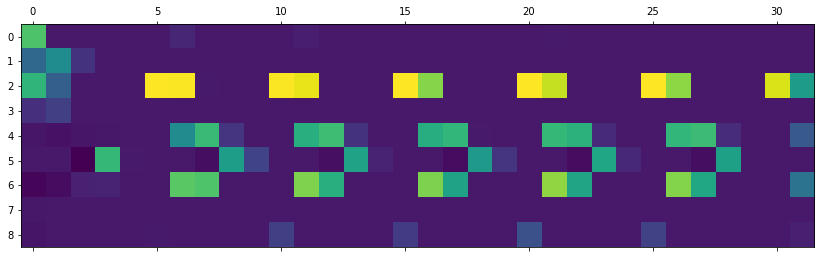



('epoch', 0, 100)
('d_loss', 0.6632908880710602, 'd_cat_acc', 0.5703125, 'a_loss', 0.91367614, 'a_cat_loss', 1.9593776)
('d_accuracy', 0.48828125)
(array([[1]]), u'DnB')


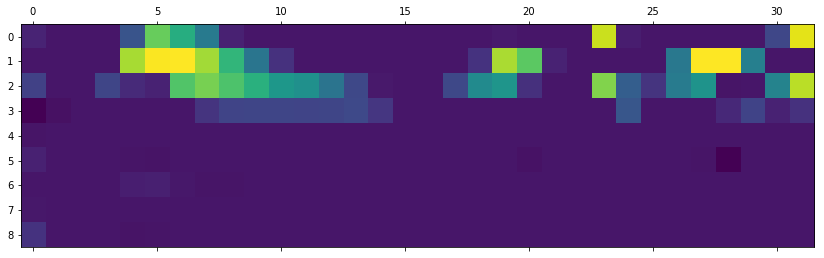



('epoch', 0, 200)
('d_loss', 0.6687677949666977, 'd_cat_acc', 0.54296875, 'a_loss', 0.9553478, 'a_cat_loss', 1.9554529)
('d_accuracy', 0.3671875)
(array([[6]]), u'Techno')


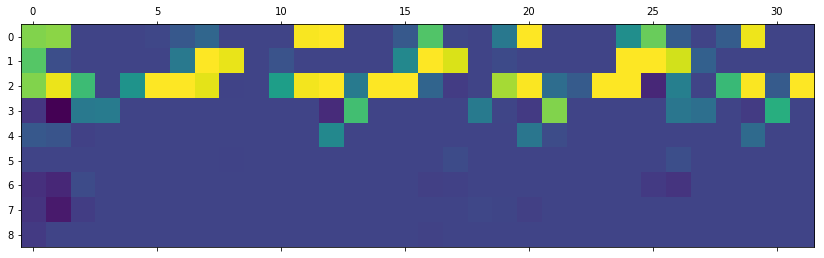



('epoch', 0, 300)
('d_loss', 0.6871903985738754, 'd_cat_acc', 0.59765625, 'a_loss', 0.84532446, 'a_cat_loss', 1.9541148)
('d_accuracy', 0.33203125)
(array([[5]]), u'Garage')


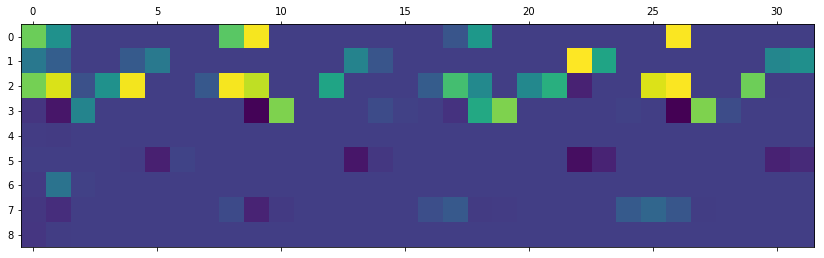



('epoch', 0, 400)
('d_loss', 0.6459385901689529, 'd_cat_acc', 0.5703125, 'a_loss', 0.9951568, 'a_cat_loss', 1.9589264)
('d_accuracy', 0.3359375)
(array([[5]]), u'Garage')


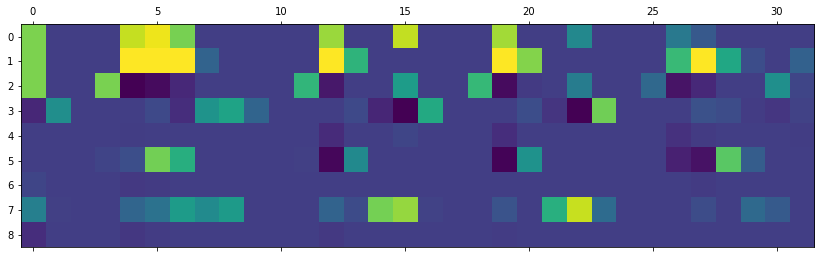



('epoch', 0, 500)
('d_loss', 0.6363735198974609, 'd_cat_acc', 0.578125, 'a_loss', 0.919301, 'a_cat_loss', 1.9546044)
('d_accuracy', 0.45703125)
(array([[5]]), u'Garage')


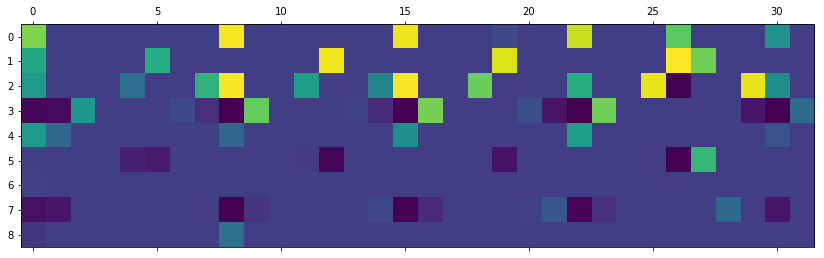



('epoch', 0, 600)
('d_loss', 0.6510169506072998, 'd_cat_acc', 0.5703125, 'a_loss', 1.0473223, 'a_cat_loss', 1.958058)
('d_accuracy', 0.453125)
(array([[5]]), u'Garage')


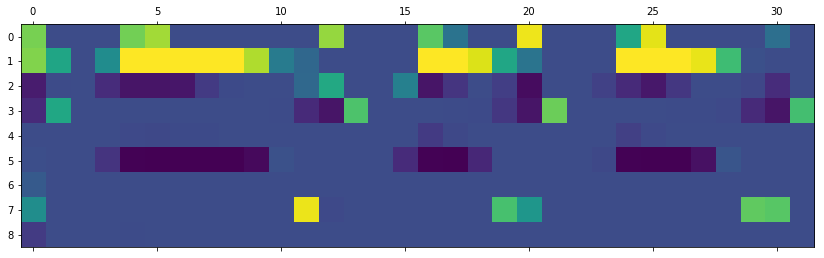



('epoch', 0, 700)
('d_loss', 0.6862884014844894, 'd_cat_acc', 0.59765625, 'a_loss', 0.8983369, 'a_cat_loss', 1.9475025)
('d_accuracy', 0.44921875)
(array([[6]]), u'Techno')


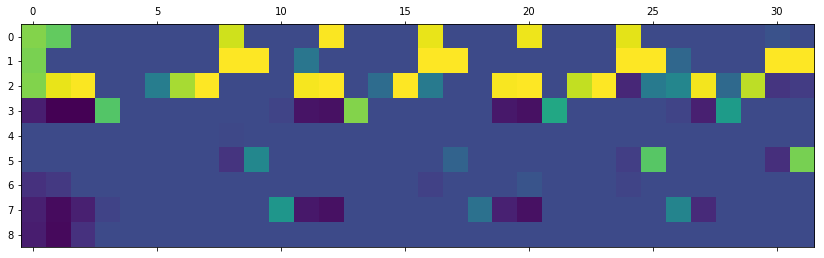



('epoch', 0, 800)
('d_loss', 0.6632708162069321, 'd_cat_acc', 0.61328125, 'a_loss', 0.956849, 'a_cat_loss', 1.9538985)
('d_accuracy', 0.44140625)
(array([[4]]), u'Breakbeat')


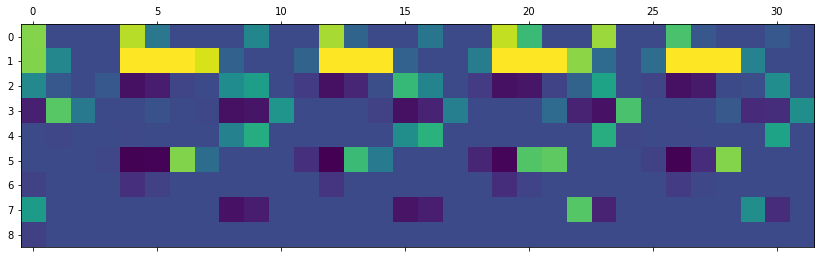



('epoch', 0, 900)
('d_loss', 0.6880522966384888, 'd_cat_acc', 0.62890625, 'a_loss', 0.86046696, 'a_cat_loss', 1.9595244)
('d_accuracy', 0.4140625)
(array([[2]]), u'Jungle')


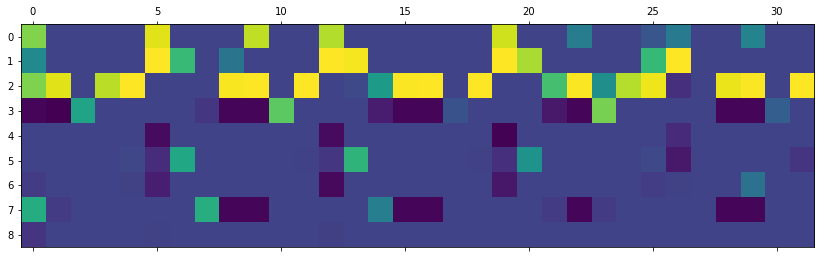



('epoch', 0, 1000)
('d_loss', 0.6718350350856781, 'd_cat_acc', 0.6015625, 'a_loss', 0.8504851, 'a_cat_loss', 1.9615662)
('d_accuracy', 0.44921875)
(array([[3]]), u'House')


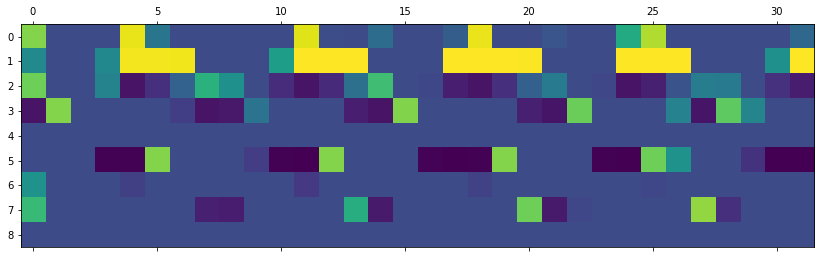



('epoch', 0, 1100)
('d_loss', 0.7029610425233841, 'd_cat_acc', 0.60546875, 'a_loss', 0.84623915, 'a_cat_loss', 1.9560988)
('d_accuracy', 0.44140625)
(array([[3]]), u'House')


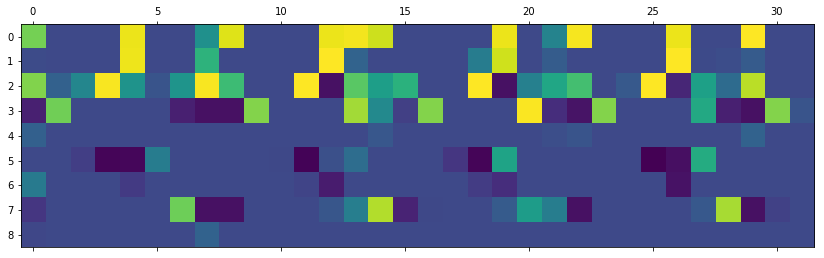



('epoch', 1, 0)
('d_loss', 0.6940251737833023, 'd_cat_acc', 0.64453125, 'a_loss', 0.8593755, 'a_cat_loss', 1.9558936)
('d_accuracy', 0.41796875)
(array([[0]]), u'Old Skool')


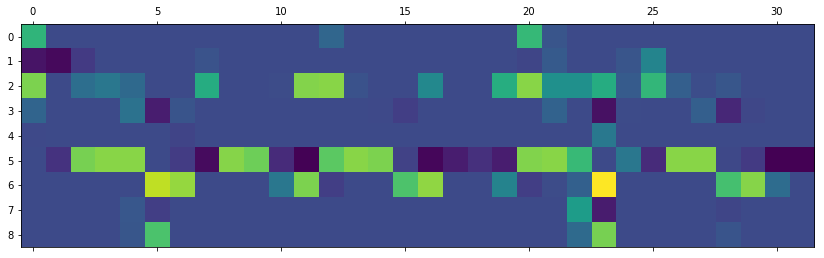



('epoch', 1, 100)
('d_loss', 0.630728155374527, 'd_cat_acc', 0.56640625, 'a_loss', 0.96913326, 'a_cat_loss', 1.9501827)
('d_accuracy', 0.43359375)
(array([[3]]), u'House')


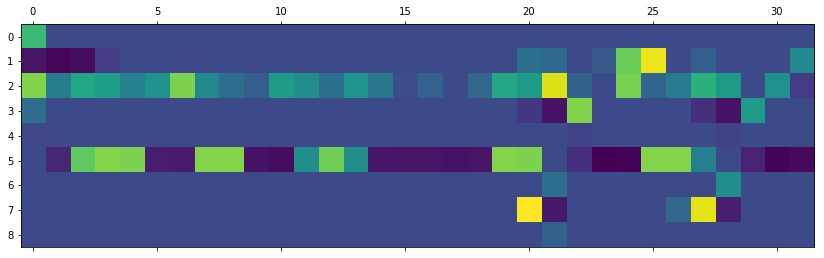



('epoch', 1, 200)
('d_loss', 0.6767352968454361, 'd_cat_acc', 0.66796875, 'a_loss', 0.8230332, 'a_cat_loss', 1.9615382)
('d_accuracy', 0.3828125)
(array([[0]]), u'Old Skool')


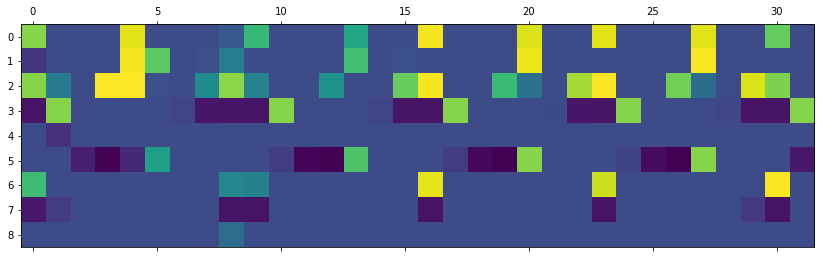



('epoch', 1, 300)
('d_loss', 0.6450663805007935, 'd_cat_acc', 0.609375, 'a_loss', 0.89353174, 'a_cat_loss', 1.9602904)
('d_accuracy', 0.375)
(array([[5]]), u'Garage')


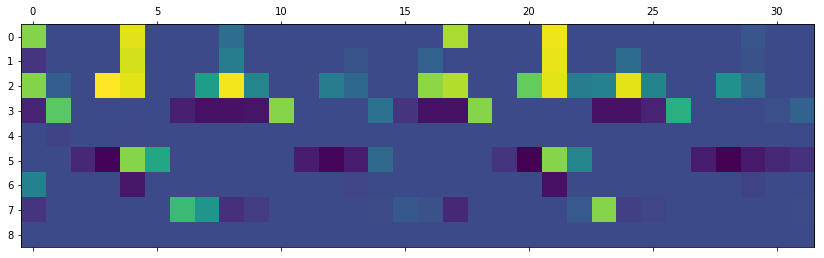



('epoch', 1, 400)
('d_loss', 0.6378644406795502, 'd_cat_acc', 0.54296875, 'a_loss', 1.0201125, 'a_cat_loss', 1.9481311)
('d_accuracy', 0.42578125)
(array([[4]]), u'Breakbeat')


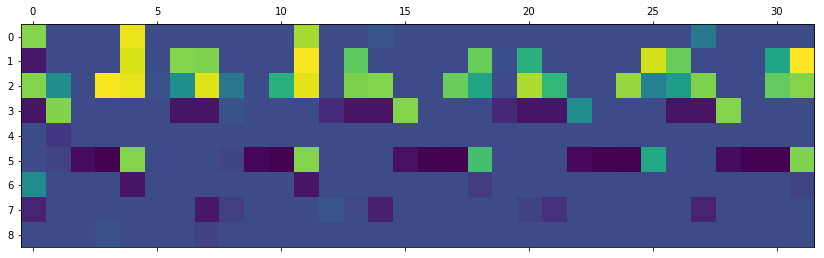



('epoch', 1, 500)
('d_loss', 0.626081183552742, 'd_cat_acc', 0.59375, 'a_loss', 0.9928225, 'a_cat_loss', 1.953578)
('d_accuracy', 0.44921875)
(array([[2]]), u'Jungle')


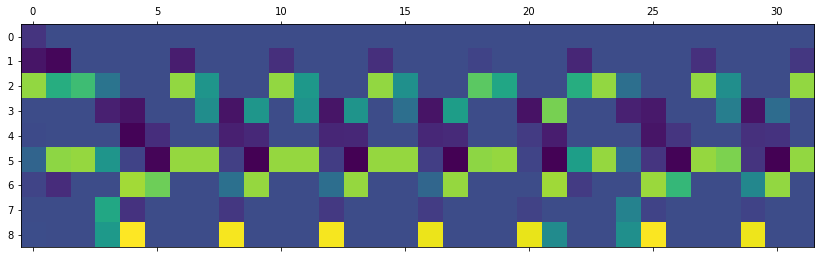



('epoch', 1, 600)
('d_loss', 0.634627565741539, 'd_cat_acc', 0.57421875, 'a_loss', 0.97690976, 'a_cat_loss', 1.9552598)
('d_accuracy', 0.44921875)
(array([[4]]), u'Breakbeat')


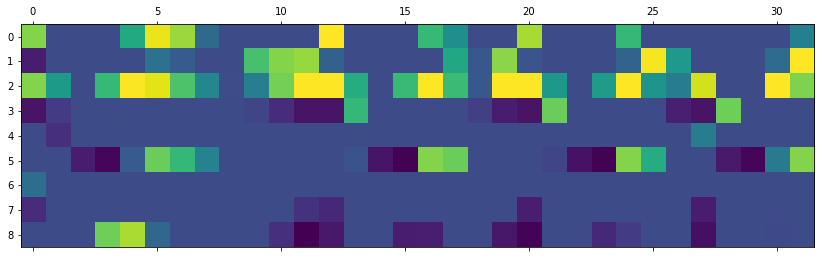



('epoch', 1, 700)
('d_loss', 0.6745725870132446, 'd_cat_acc', 0.52734375, 'a_loss', 0.9265427, 'a_cat_loss', 1.9537771)
('d_accuracy', 0.46484375)
(array([[4]]), u'Breakbeat')


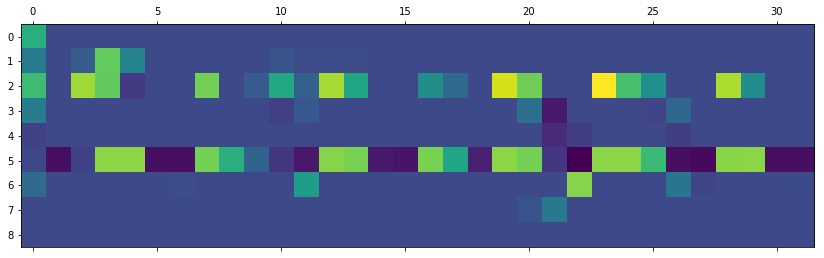



('epoch', 1, 800)
('d_loss', 0.6895190626382828, 'd_cat_acc', 0.55859375, 'a_loss', 0.9672408, 'a_cat_loss', 1.9574142)
('d_accuracy', 0.3984375)
(array([[2]]), u'Jungle')


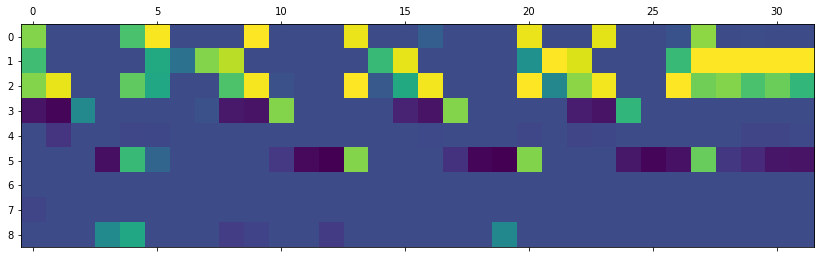



('epoch', 1, 900)
('d_loss', 0.6409602910280228, 'd_cat_acc', 0.56640625, 'a_loss', 1.1709113, 'a_cat_loss', 1.9507823)
('d_accuracy', 0.47265625)
(array([[3]]), u'House')


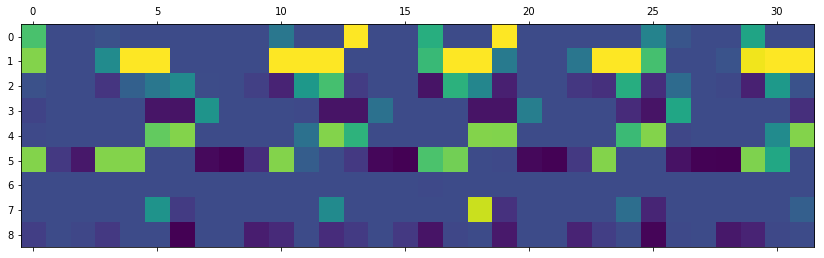



('epoch', 1, 1000)
('d_loss', 0.6274797171354294, 'd_cat_acc', 0.55859375, 'a_loss', 1.0581828, 'a_cat_loss', 1.9531773)
('d_accuracy', 0.37109375)
(array([[0]]), u'Old Skool')


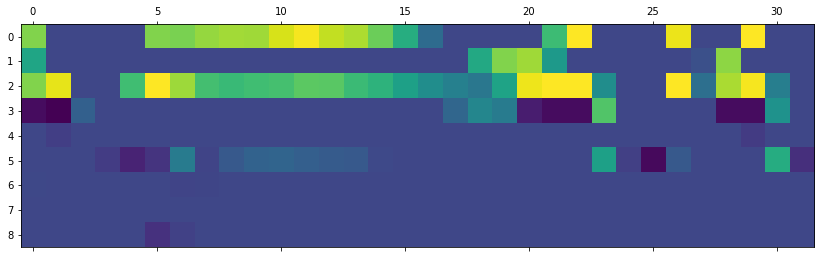



('epoch', 1, 1100)
('d_loss', 0.6489138156175613, 'd_cat_acc', 0.59375, 'a_loss', 0.9888915, 'a_cat_loss', 1.9563279)
('d_accuracy', 0.35546875)
(array([[2]]), u'Jungle')


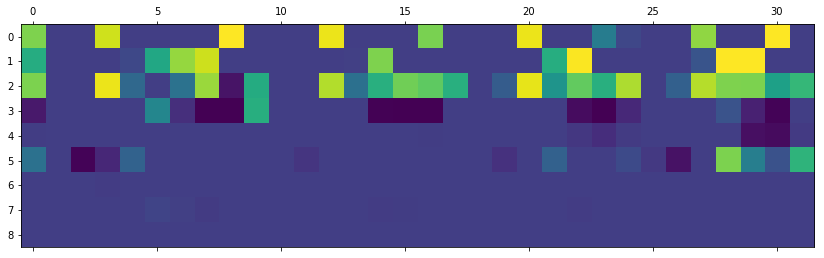



('epoch', 2, 0)
('d_loss', 0.5704874843358994, 'd_cat_acc', 0.54296875, 'a_loss', 1.0033247, 'a_cat_loss', 1.9491806)
('d_accuracy', 0.46875)
(array([[0]]), u'Old Skool')


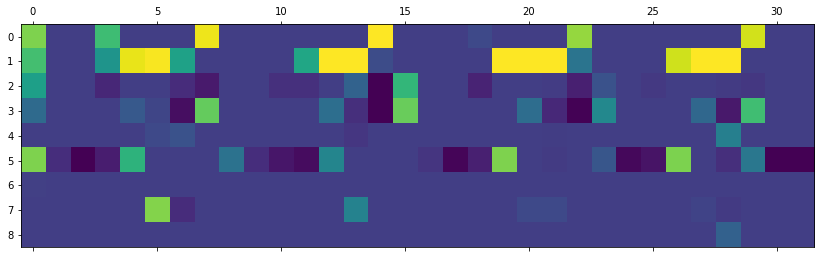



('epoch', 2, 100)
('d_loss', 0.5901187360286713, 'd_cat_acc', 0.59765625, 'a_loss', 1.14163, 'a_cat_loss', 1.955227)
('d_accuracy', 0.48046875)
(array([[6]]), u'Techno')


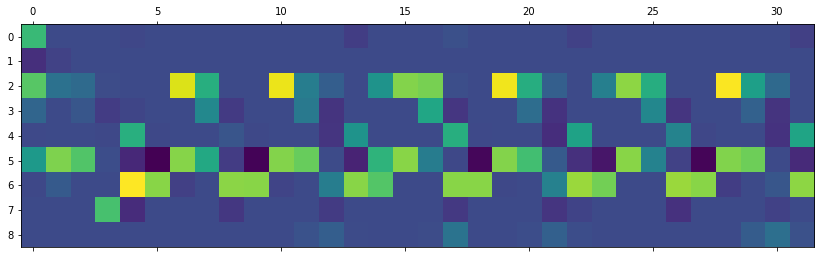



('epoch', 2, 200)
('d_loss', 0.5988508313894272, 'd_cat_acc', 0.6015625, 'a_loss', 1.0733078, 'a_cat_loss', 1.9567711)
('d_accuracy', 0.453125)
(array([[5]]), u'Garage')


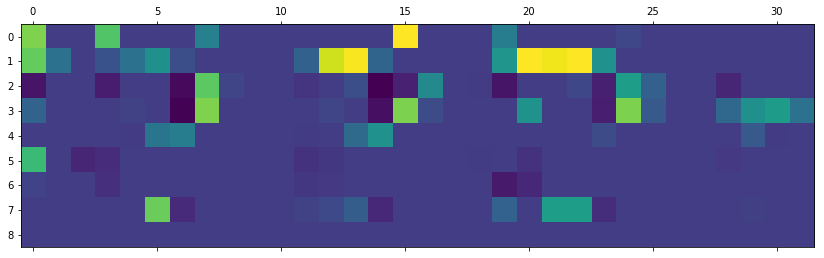



('epoch', 2, 300)
('d_loss', 0.590053141117096, 'd_cat_acc', 0.546875, 'a_loss', 1.0843174, 'a_cat_loss', 1.959392)
('d_accuracy', 0.40625)
(array([[0]]), u'Old Skool')


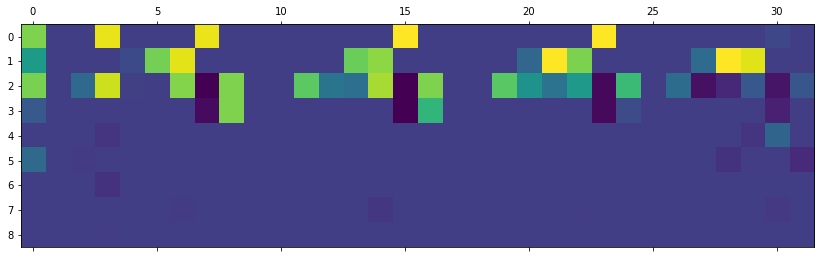



('epoch', 2, 400)
('d_loss', 0.6305938214063644, 'd_cat_acc', 0.5859375, 'a_loss', 1.1605462, 'a_cat_loss', 1.9550182)
('d_accuracy', 0.453125)
(array([[4]]), u'Breakbeat')


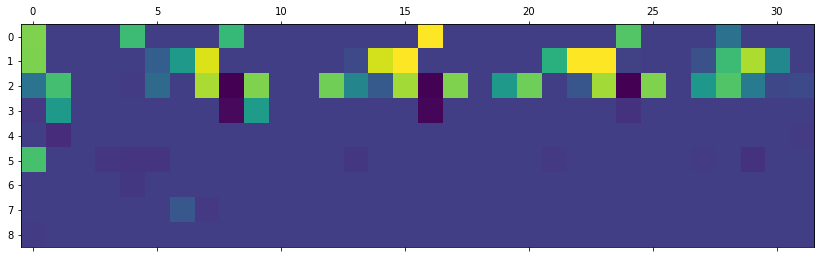



Pausing D
Pausing D
Pausing D
Pausing D
('epoch', 2, 500)
('d_loss', 0.6007170528173447, 'd_cat_acc', 0.6015625, 'a_loss', 1.0916907, 'a_cat_loss', 1.9511418)
('d_accuracy', 0.453125)
(array([[2]]), u'Jungle')


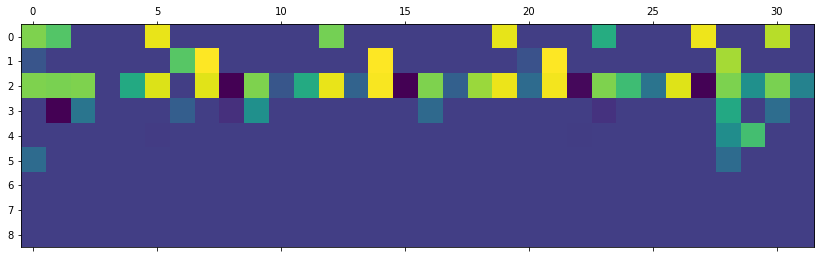



('epoch', 2, 600)
('d_loss', 0.6654178500175476, 'd_cat_acc', 0.58203125, 'a_loss', 1.0263255, 'a_cat_loss', 1.9539453)
('d_accuracy', 0.41796875)
(array([[5]]), u'Garage')


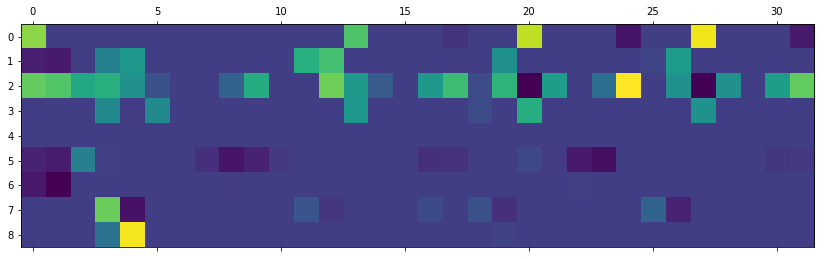



('epoch', 2, 700)
('d_loss', 0.5575181096792221, 'd_cat_acc', 0.52734375, 'a_loss', 1.0178087, 'a_cat_loss', 1.9549291)
('d_accuracy', 0.4765625)
(array([[6]]), u'Techno')


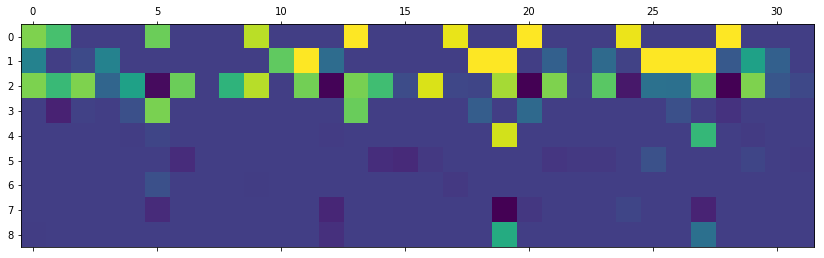



('epoch', 2, 800)
('d_loss', 0.5790846645832062, 'd_cat_acc', 0.609375, 'a_loss', 1.0263144, 'a_cat_loss', 1.9551098)
('d_accuracy', 0.4296875)
(array([[2]]), u'Jungle')


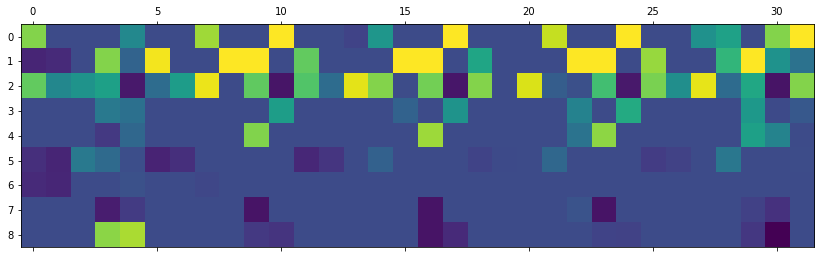



('epoch', 2, 900)
('d_loss', 0.6199213415384293, 'd_cat_acc', 0.54296875, 'a_loss', 1.1274455, 'a_cat_loss', 1.9548651)
('d_accuracy', 0.4296875)
(array([[4]]), u'Breakbeat')


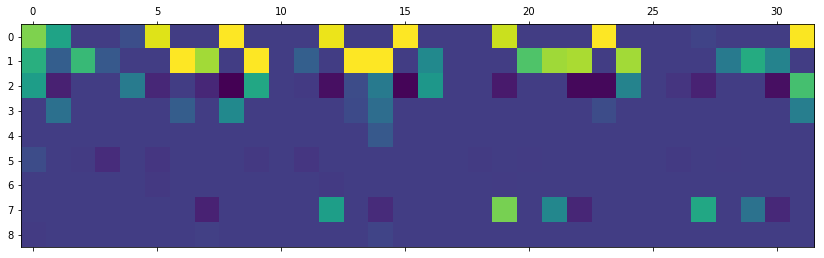



Pausing D
('epoch', 2, 1000)
('d_loss', 0.6186439245939255, 'd_cat_acc', 0.54296875, 'a_loss', 0.93506217, 'a_cat_loss', 1.9563528)
('d_accuracy', 0.3515625)
(array([[3]]), u'House')


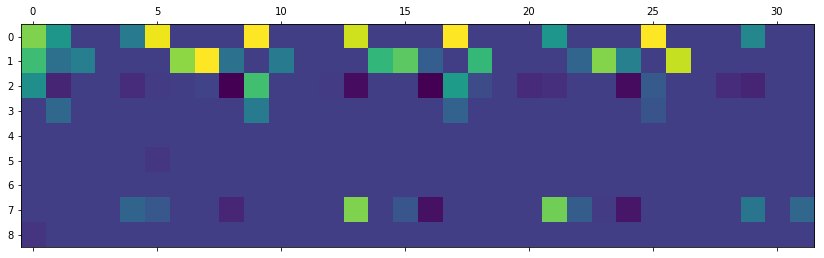



('epoch', 2, 1100)
('d_loss', 0.6232136636972427, 'd_cat_acc', 0.55078125, 'a_loss', 0.9980074, 'a_cat_loss', 1.9500549)
('d_accuracy', 0.31640625)
(array([[6]]), u'Techno')


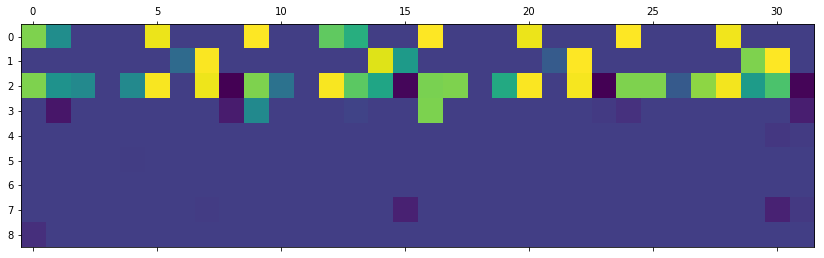



('epoch', 3, 0)
('d_loss', 0.6558084189891815, 'd_cat_acc', 0.60546875, 'a_loss', 0.96628773, 'a_cat_loss', 1.9555025)
('d_accuracy', 0.421875)
(array([[1]]), u'DnB')


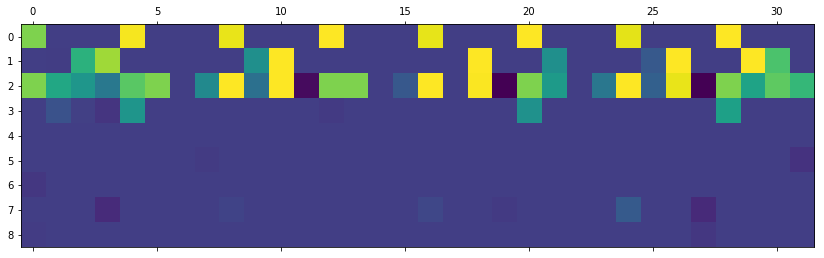



('epoch', 3, 100)
('d_loss', 0.6362422853708267, 'd_cat_acc', 0.59765625, 'a_loss', 0.98953056, 'a_cat_loss', 1.9579215)
('d_accuracy', 0.44921875)
(array([[5]]), u'Garage')


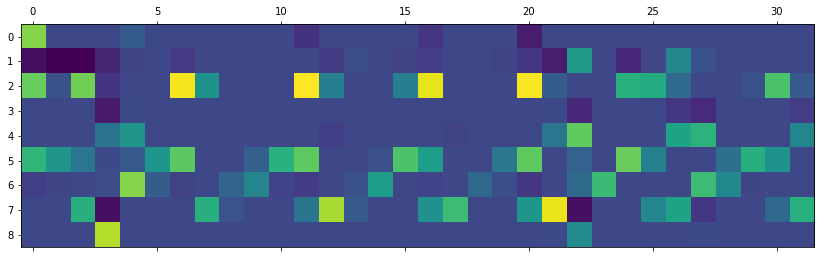



('epoch', 3, 200)
('d_loss', 0.6275182366371155, 'd_cat_acc', 0.59765625, 'a_loss', 1.0758405, 'a_cat_loss', 1.956178)
('d_accuracy', 0.48828125)
(array([[2]]), u'Jungle')


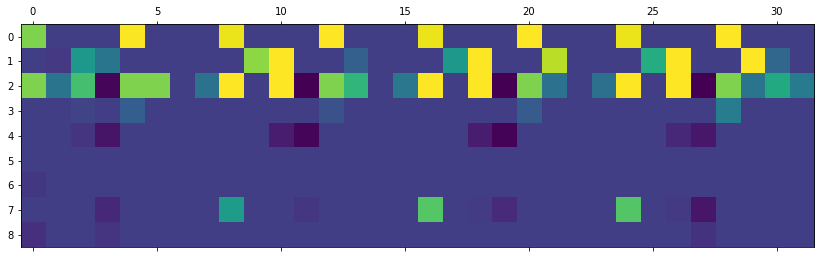



('epoch', 3, 300)
('d_loss', 0.6215117871761322, 'd_cat_acc', 0.58203125, 'a_loss', 1.0662329, 'a_cat_loss', 1.9616098)
('d_accuracy', 0.44921875)
(array([[0]]), u'Old Skool')


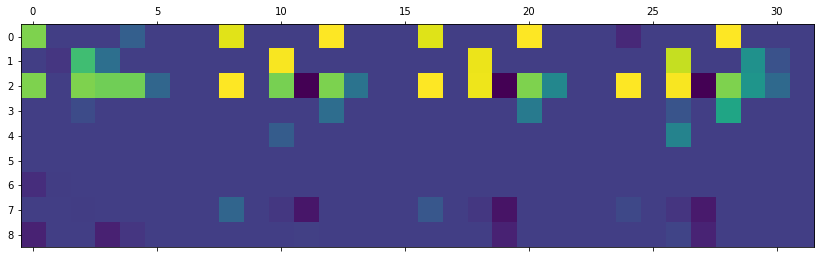



('epoch', 3, 400)
('d_loss', 0.614393338561058, 'd_cat_acc', 0.57421875, 'a_loss', 0.9802875, 'a_cat_loss', 1.952917)
('d_accuracy', 0.3984375)
(array([[5]]), u'Garage')


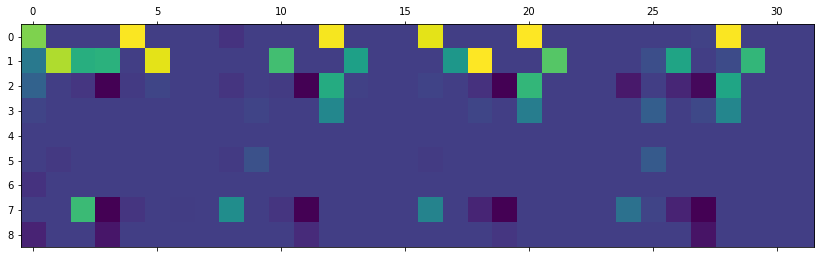



('epoch', 3, 500)
('d_loss', 0.6463813483715057, 'd_cat_acc', 0.578125, 'a_loss', 1.0460172, 'a_cat_loss', 1.9533231)
('d_accuracy', 0.390625)
(array([[6]]), u'Techno')


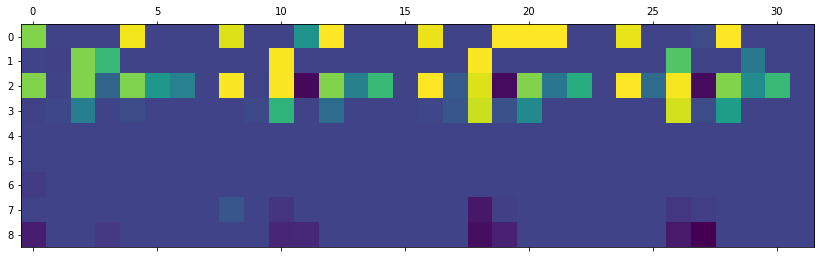



('epoch', 3, 600)
('d_loss', 0.6395919620990753, 'd_cat_acc', 0.58984375, 'a_loss', 1.0471177, 'a_cat_loss', 1.9546512)
('d_accuracy', 0.38671875)
(array([[1]]), u'DnB')


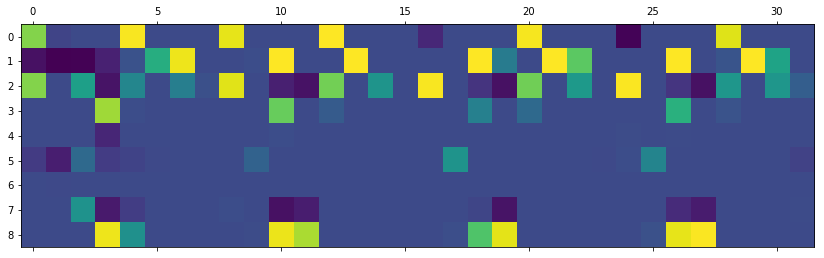



('epoch', 3, 700)
('d_loss', 0.6279311627149582, 'd_cat_acc', 0.61328125, 'a_loss', 1.140343, 'a_cat_loss', 1.9555912)
('d_accuracy', 0.46484375)
(array([[2]]), u'Jungle')


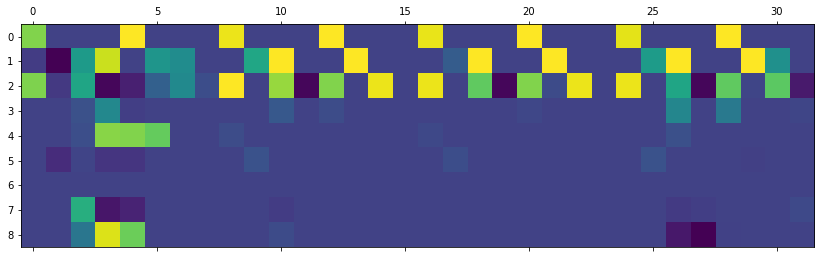



('epoch', 3, 800)
('d_loss', 0.6471414864063263, 'd_cat_acc', 0.5625, 'a_loss', 1.0742662, 'a_cat_loss', 1.95236)
('d_accuracy', 0.4375)
(array([[4]]), u'Breakbeat')


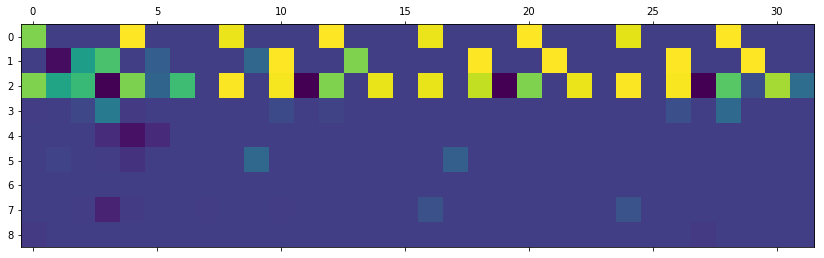



('epoch', 3, 900)
('d_loss', 0.6318934857845306, 'd_cat_acc', 0.546875, 'a_loss', 1.0284442, 'a_cat_loss', 1.9589281)
('d_accuracy', 0.41796875)
(array([[6]]), u'Techno')


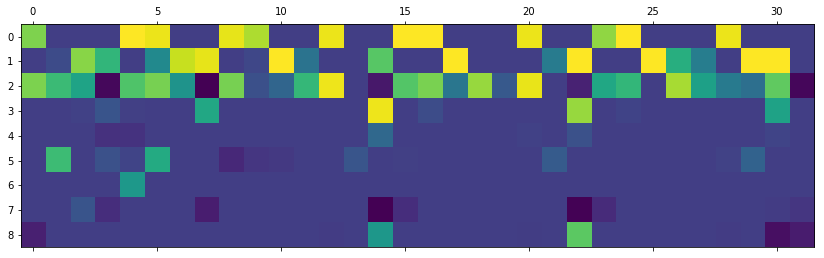



('epoch', 3, 1000)
('d_loss', 0.6436532586812973, 'd_cat_acc', 0.58203125, 'a_loss', 0.95186365, 'a_cat_loss', 1.9482483)
('d_accuracy', 0.39453125)
(array([[3]]), u'House')


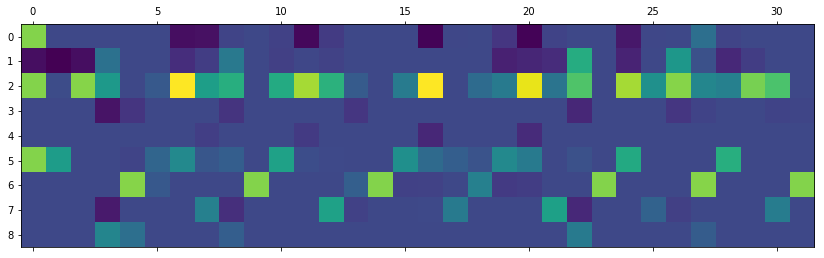



('epoch', 3, 1100)
('d_loss', 0.5904619991779327, 'd_cat_acc', 0.56640625, 'a_loss', 1.0332499, 'a_cat_loss', 1.9548637)
('d_accuracy', 0.44140625)
(array([[4]]), u'Breakbeat')


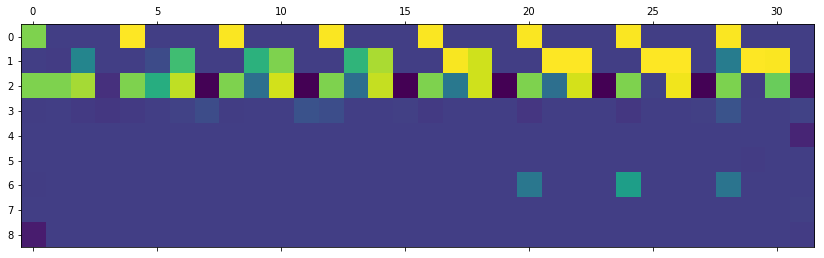



('epoch', 4, 0)
('d_loss', 0.6823039501905441, 'd_cat_acc', 0.60546875, 'a_loss', 0.99279046, 'a_cat_loss', 1.9575845)
('d_accuracy', 0.42578125)
(array([[0]]), u'Old Skool')


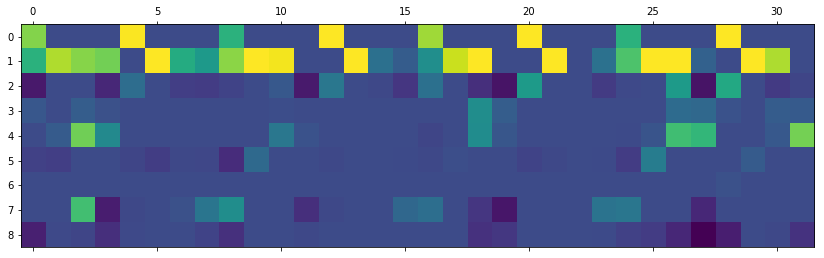



('epoch', 4, 100)
('d_loss', 0.5664305239915848, 'd_cat_acc', 0.61328125, 'a_loss', 1.0535173, 'a_cat_loss', 1.9580941)
('d_accuracy', 0.4375)
(array([[4]]), u'Breakbeat')


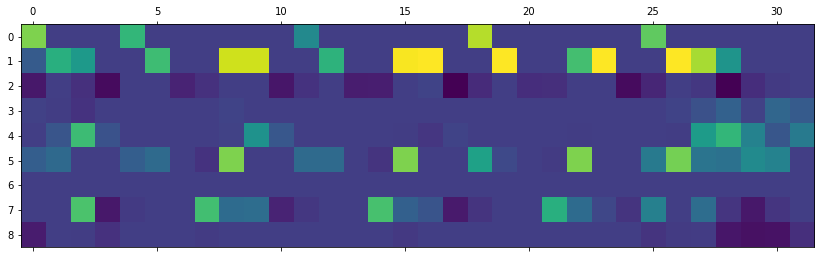



('epoch', 4, 200)
('d_loss', 0.623746931552887, 'd_cat_acc', 0.58203125, 'a_loss', 1.1235986, 'a_cat_loss', 1.9529858)
('d_accuracy', 0.44140625)
(array([[3]]), u'House')


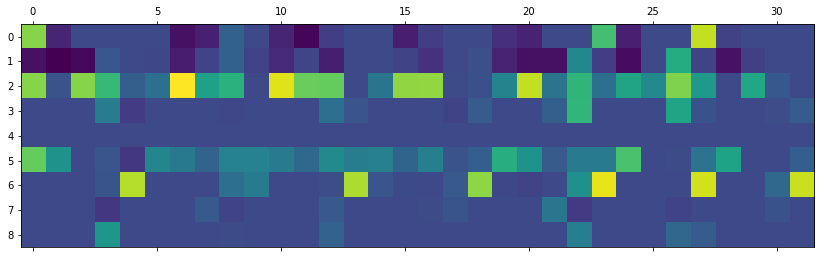



('epoch', 4, 300)
('d_loss', 0.5963738709688187, 'd_cat_acc', 0.57421875, 'a_loss', 1.0223203, 'a_cat_loss', 1.9563055)
('d_accuracy', 0.453125)
(array([[5]]), u'Garage')


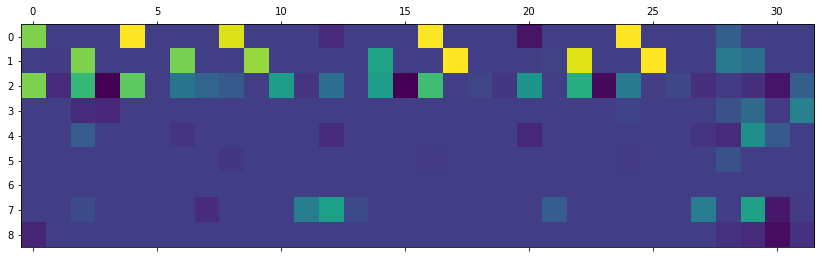



('epoch', 4, 400)
('d_loss', 0.6233180165290833, 'd_cat_acc', 0.546875, 'a_loss', 0.94, 'a_cat_loss', 1.9555256)
('d_accuracy', 0.38671875)
(array([[3]]), u'House')


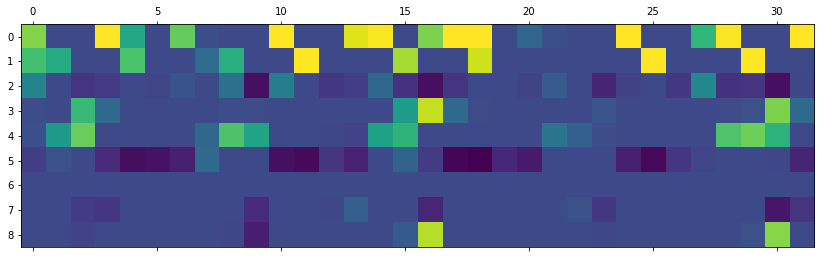



('epoch', 4, 500)
('d_loss', 0.571952298283577, 'd_cat_acc', 0.5703125, 'a_loss', 1.2428728, 'a_cat_loss', 1.9545529)
('d_accuracy', 0.41015625)
(array([[3]]), u'House')


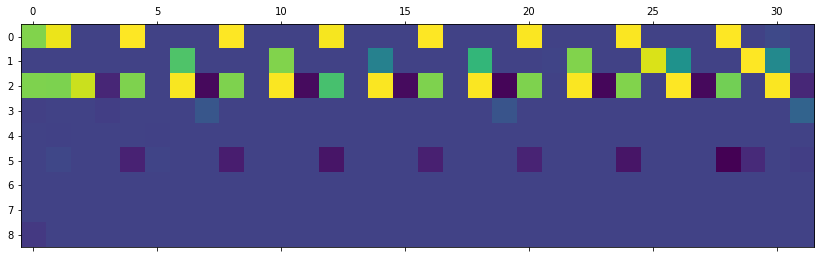



('epoch', 4, 600)
('d_loss', 0.5867384672164917, 'd_cat_acc', 0.5625, 'a_loss', 1.1399465, 'a_cat_loss', 1.9504064)
('d_accuracy', 0.3984375)
(array([[2]]), u'Jungle')


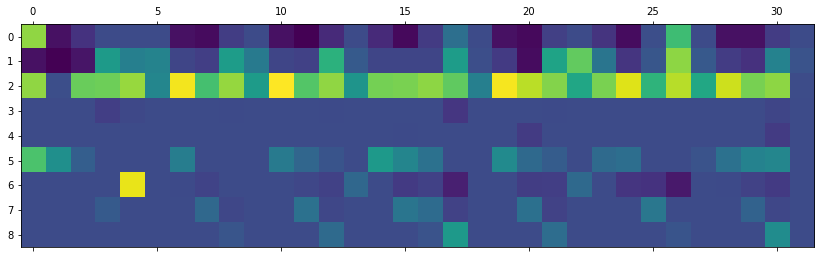



('epoch', 4, 700)
('d_loss', 0.6493289619684219, 'd_cat_acc', 0.60546875, 'a_loss', 1.0819466, 'a_cat_loss', 1.9576387)
('d_accuracy', 0.36328125)
(array([[1]]), u'DnB')


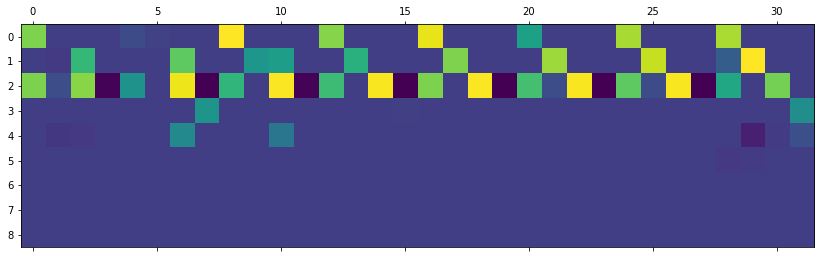



('epoch', 4, 800)
('d_loss', 0.601550817489624, 'd_cat_acc', 0.6015625, 'a_loss', 1.0389844, 'a_cat_loss', 1.9598024)
('d_accuracy', 0.3828125)
(array([[6]]), u'Techno')


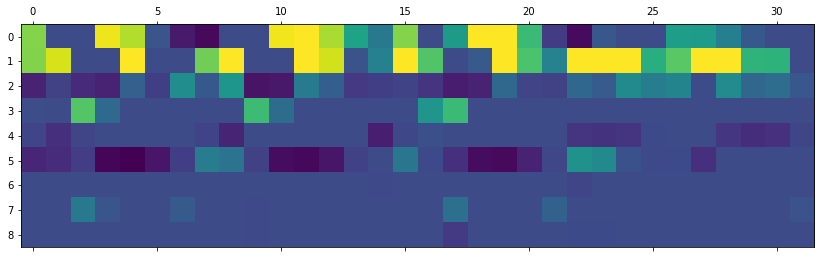



('epoch', 4, 900)
('d_loss', 0.5224152058362961, 'd_cat_acc', 0.6015625, 'a_loss', 1.2398279, 'a_cat_loss', 1.9547992)
('d_accuracy', 0.4609375)
(array([[4]]), u'Breakbeat')


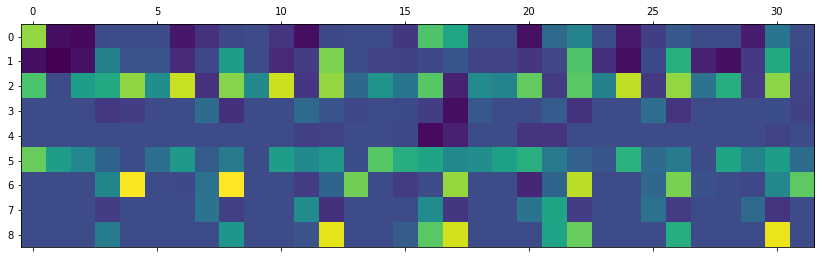



('epoch', 4, 1000)
('d_loss', 0.589963749051094, 'd_cat_acc', 0.58203125, 'a_loss', 1.1586158, 'a_cat_loss', 1.9509354)
('d_accuracy', 0.41015625)
(array([[5]]), u'Garage')


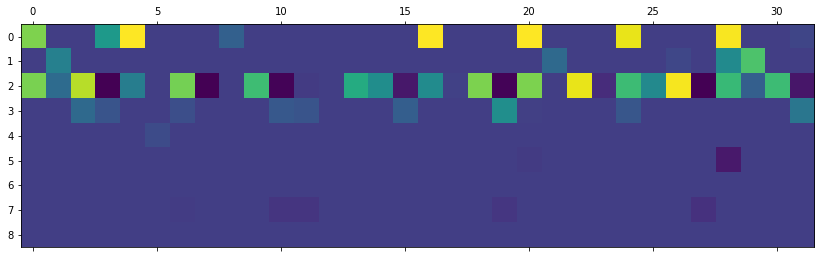



('epoch', 4, 1100)
('d_loss', 0.5865602940320969, 'd_cat_acc', 0.59765625, 'a_loss', 1.0959433, 'a_cat_loss', 1.9530638)
('d_accuracy', 0.46484375)
(array([[2]]), u'Jungle')


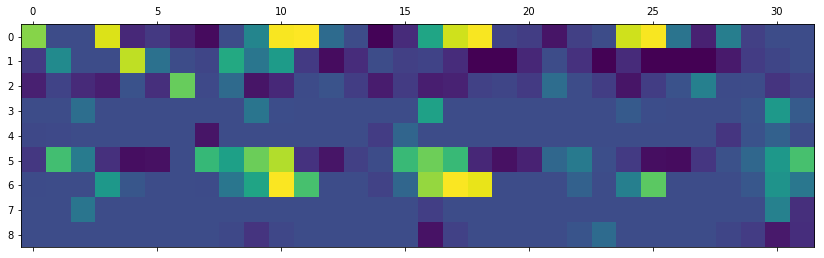



('epoch', 5, 0)
('d_loss', 0.5900238156318665, 'd_cat_acc', 0.5625, 'a_loss', 1.1816077, 'a_cat_loss', 1.9552339)
('d_accuracy', 0.4375)
(array([[2]]), u'Jungle')


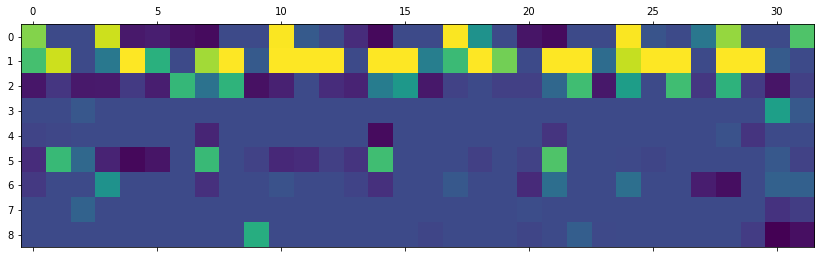



Pausing D
Pausing D
Pausing D
Pausing D
('epoch', 5, 100)
('d_loss', 0.6276193410158157, 'd_cat_acc', 0.5390625, 'a_loss', 1.0335821, 'a_cat_loss', 1.9527426)
('d_accuracy', 0.43359375)
(array([[6]]), u'Techno')


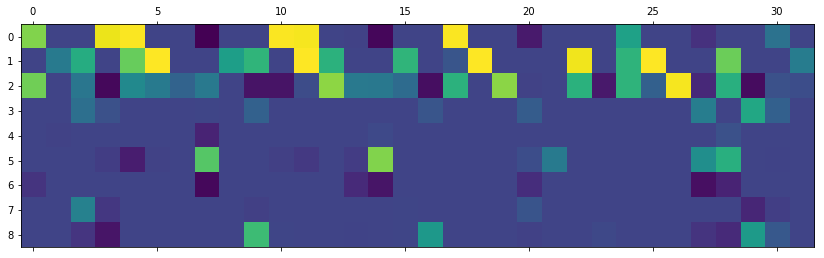



Pausing D
('epoch', 5, 200)
('d_loss', 0.5648739635944366, 'd_cat_acc', 0.5859375, 'a_loss', 1.1671548, 'a_cat_loss', 1.9527895)
('d_accuracy', 0.44921875)
(array([[2]]), u'Jungle')


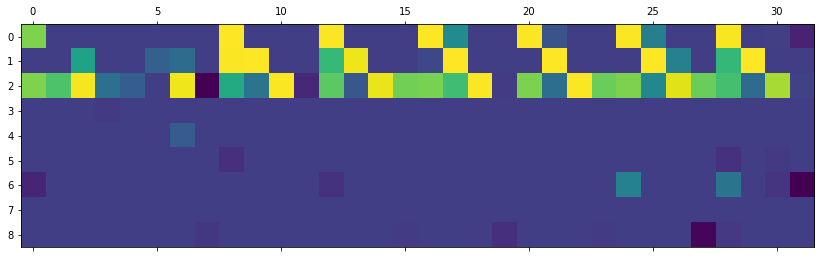



('epoch', 5, 300)
('d_loss', 0.5369790345430374, 'd_cat_acc', 0.59765625, 'a_loss', 1.2015926, 'a_cat_loss', 1.9530069)
('d_accuracy', 0.46484375)
(array([[2]]), u'Jungle')


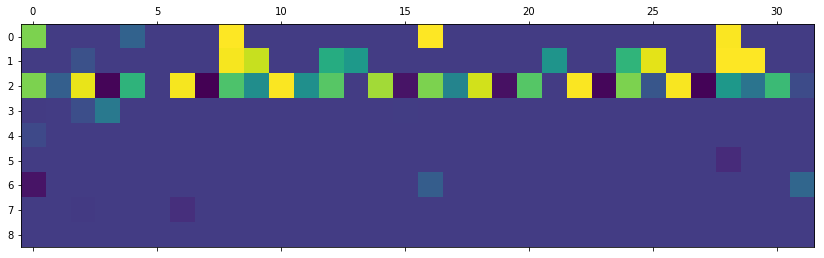



('epoch', 5, 400)
('d_loss', 0.6008833795785904, 'd_cat_acc', 0.62109375, 'a_loss', 1.2118311, 'a_cat_loss', 1.9533055)
('d_accuracy', 0.41796875)
(array([[3]]), u'House')


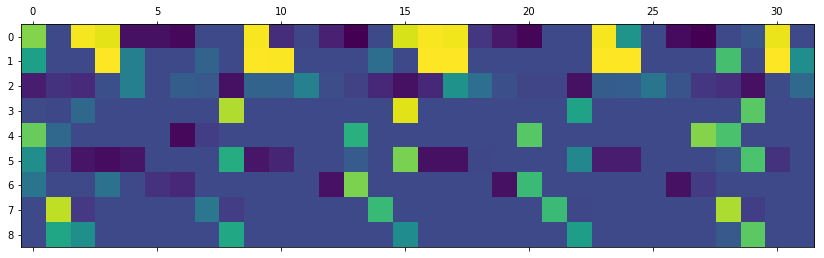



('epoch', 5, 500)
('d_loss', 0.6124685555696487, 'd_cat_acc', 0.62890625, 'a_loss', 1.1011486, 'a_cat_loss', 1.960154)
('d_accuracy', 0.42578125)
(array([[4]]), u'Breakbeat')


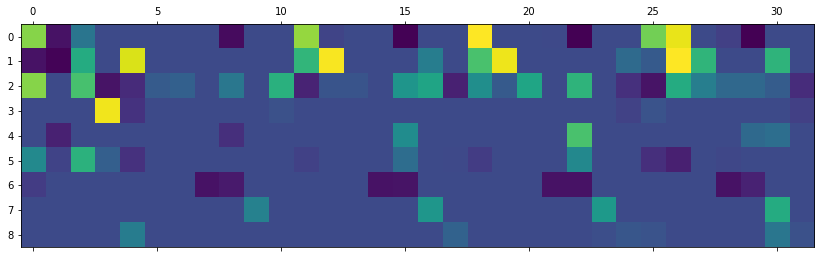



('epoch', 5, 600)
('d_loss', 0.5623795688152313, 'd_cat_acc', 0.58203125, 'a_loss', 1.3766274, 'a_cat_loss', 1.9573382)
('d_accuracy', 0.40625)
(array([[1]]), u'DnB')


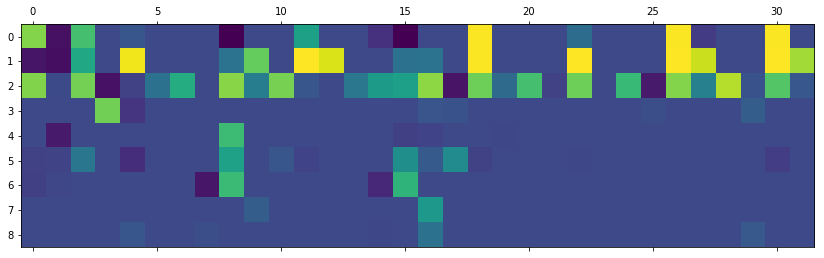



('epoch', 5, 700)
('d_loss', 0.6001898348331451, 'd_cat_acc', 0.58203125, 'a_loss', 1.0997385, 'a_cat_loss', 1.9537681)
('d_accuracy', 0.44140625)
(array([[2]]), u'Jungle')


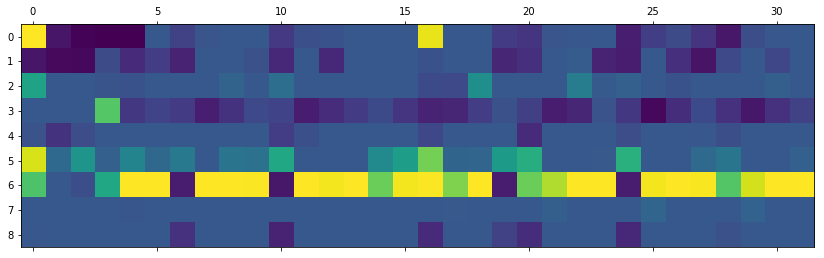



('epoch', 5, 800)
('d_loss', 0.5831329673528671, 'd_cat_acc', 0.65234375, 'a_loss', 1.2502997, 'a_cat_loss', 1.9564005)
('d_accuracy', 0.44140625)
(array([[0]]), u'Old Skool')


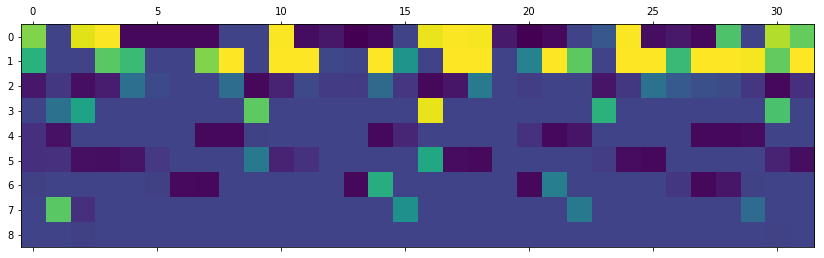



('epoch', 5, 900)
('d_loss', 0.5770018249750137, 'd_cat_acc', 0.63671875, 'a_loss', 1.5203645, 'a_cat_loss', 1.9568896)
('d_accuracy', 0.46875)
(array([[3]]), u'House')


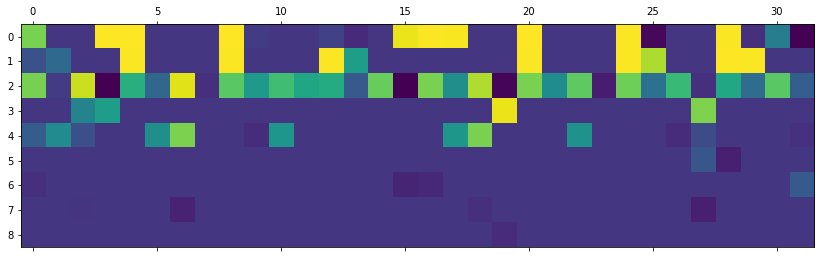



('epoch', 5, 1000)
('d_loss', 0.6307480037212372, 'd_cat_acc', 0.6171875, 'a_loss', 1.0639473, 'a_cat_loss', 1.9601551)
('d_accuracy', 0.4375)
(array([[3]]), u'House')


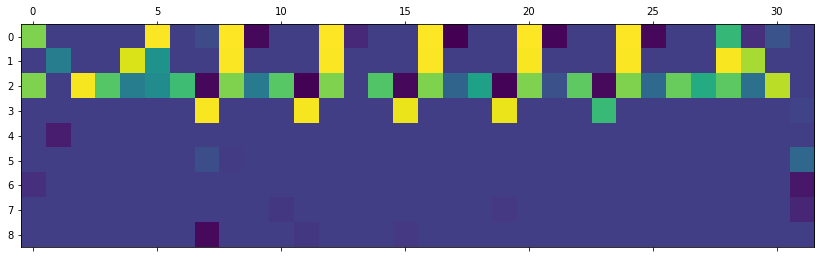



('epoch', 5, 1100)
('d_loss', 0.6532631516456604, 'd_cat_acc', 0.62109375, 'a_loss', 1.2577351, 'a_cat_loss', 1.9597366)
('d_accuracy', 0.4375)
(array([[6]]), u'Techno')


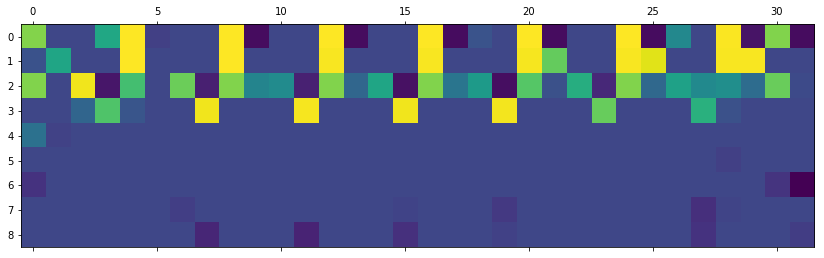



('epoch', 6, 0)
('d_loss', 0.573221817612648, 'd_cat_acc', 0.60546875, 'a_loss', 1.3984041, 'a_cat_loss', 1.95446)
('d_accuracy', 0.4453125)
(array([[6]]), u'Techno')


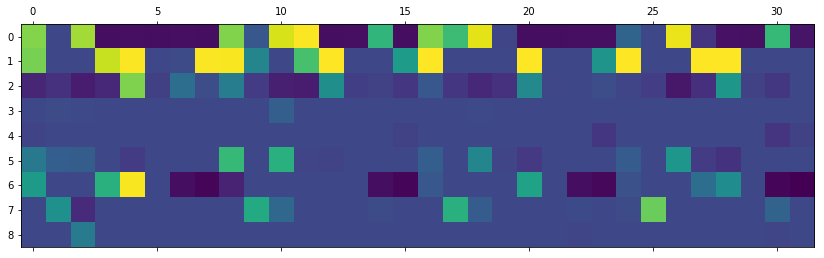



Pausing D
('epoch', 6, 100)
('d_loss', 0.6243683397769928, 'd_cat_acc', 0.578125, 'a_loss', 1.1154634, 'a_cat_loss', 1.963279)
('d_accuracy', 0.34765625)
(array([[2]]), u'Jungle')


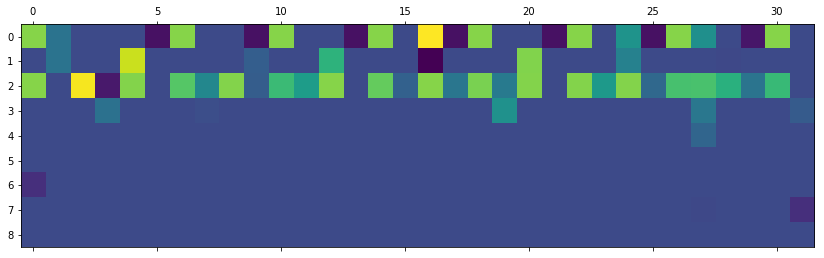



('epoch', 6, 200)
('d_loss', 0.6790036410093307, 'd_cat_acc', 0.6328125, 'a_loss', 0.93520135, 'a_cat_loss', 1.9615095)
('d_accuracy', 0.3671875)
(array([[3]]), u'House')


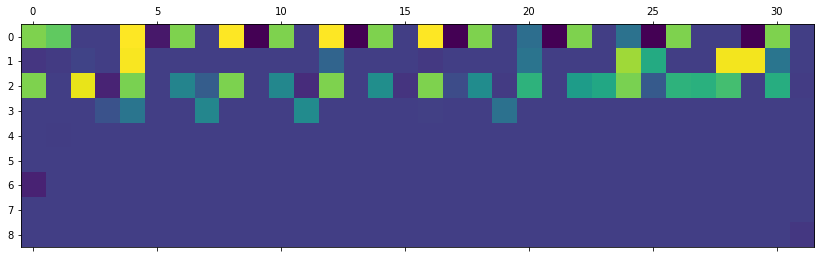



('epoch', 6, 300)
('d_loss', 0.6718880981206894, 'd_cat_acc', 0.65234375, 'a_loss', 0.9547873, 'a_cat_loss', 1.963456)
('d_accuracy', 0.40625)
(array([[3]]), u'House')


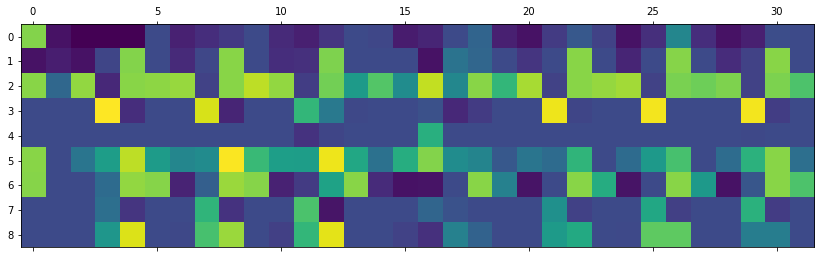



('epoch', 6, 400)
('d_loss', 0.6473221182823181, 'd_cat_acc', 0.6328125, 'a_loss', 0.9668647, 'a_cat_loss', 1.9603715)
('d_accuracy', 0.34765625)
(array([[3]]), u'House')


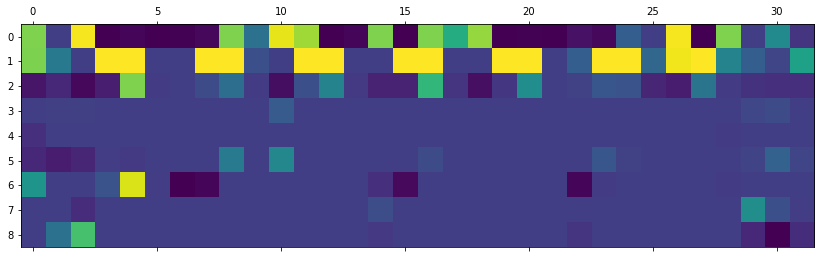



('epoch', 6, 500)
('d_loss', 0.6166609078645706, 'd_cat_acc', 0.64453125, 'a_loss', 0.98025733, 'a_cat_loss', 1.9568894)
('d_accuracy', 0.4140625)
(array([[0]]), u'Old Skool')


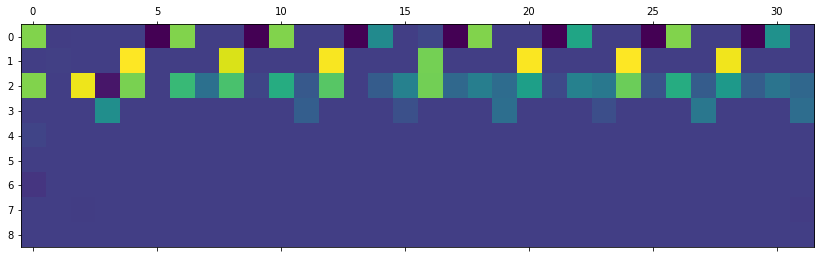



('epoch', 6, 600)
('d_loss', 0.6832581907510757, 'd_cat_acc', 0.6328125, 'a_loss', 0.81380713, 'a_cat_loss', 1.9601686)
('d_accuracy', 0.33203125)
(array([[4]]), u'Breakbeat')


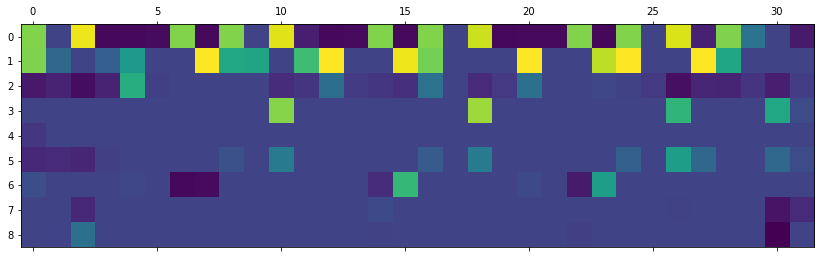



('epoch', 6, 700)
('d_loss', 0.6522011607885361, 'd_cat_acc', 0.65234375, 'a_loss', 0.94599307, 'a_cat_loss', 1.956221)
('d_accuracy', 0.4140625)
(array([[2]]), u'Jungle')


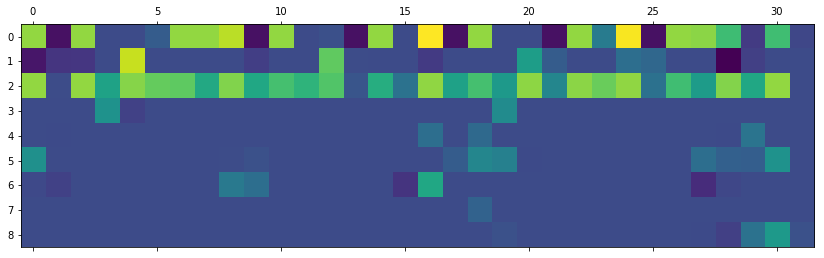



('epoch', 6, 800)
('d_loss', 0.6737128496170044, 'd_cat_acc', 0.68359375, 'a_loss', 0.8538338, 'a_cat_loss', 1.9582852)
('d_accuracy', 0.3359375)
(array([[2]]), u'Jungle')


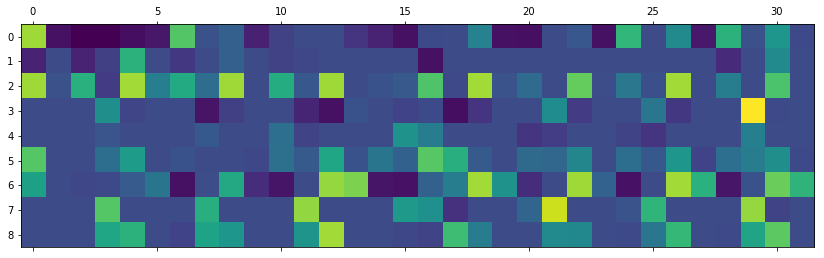



('epoch', 6, 900)
('d_loss', 0.6851138323545456, 'd_cat_acc', 0.65234375, 'a_loss', 0.9936007, 'a_cat_loss', 1.9615817)
('d_accuracy', 0.41796875)
(array([[0]]), u'Old Skool')


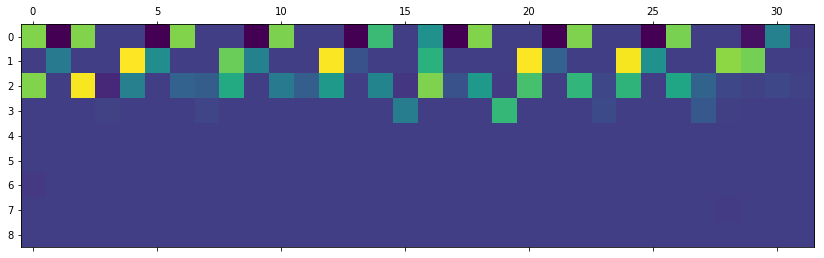



('epoch', 6, 1000)
('d_loss', 0.665145993232727, 'd_cat_acc', 0.66015625, 'a_loss', 0.9915615, 'a_cat_loss', 1.9598914)
('d_accuracy', 0.47265625)
(array([[6]]), u'Techno')


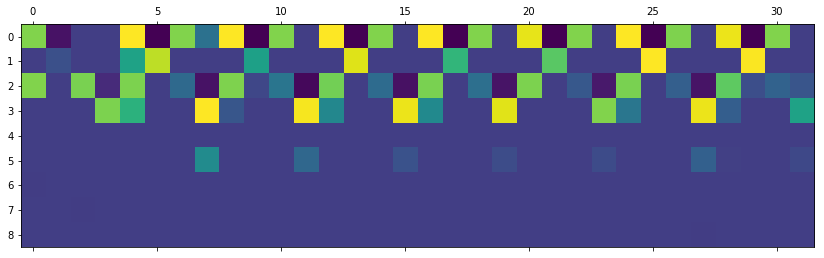



('epoch', 6, 1100)
('d_loss', 0.6207438409328461, 'd_cat_acc', 0.671875, 'a_loss', 1.1202135, 'a_cat_loss', 1.9586787)
('d_accuracy', 0.43359375)
(array([[6]]), u'Techno')


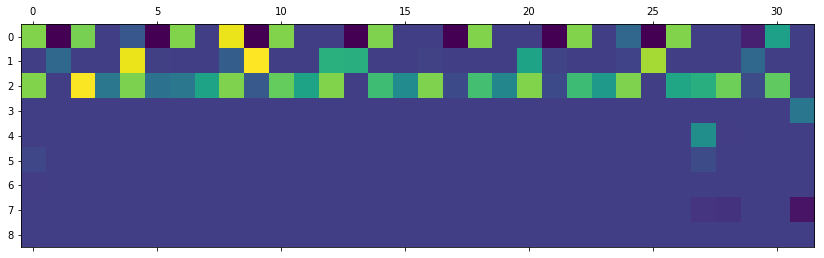



('epoch', 7, 0)
('d_loss', 0.6080644875764847, 'd_cat_acc', 0.58203125, 'a_loss', 0.9840582, 'a_cat_loss', 1.9610283)
('d_accuracy', 0.41796875)
(array([[5]]), u'Garage')


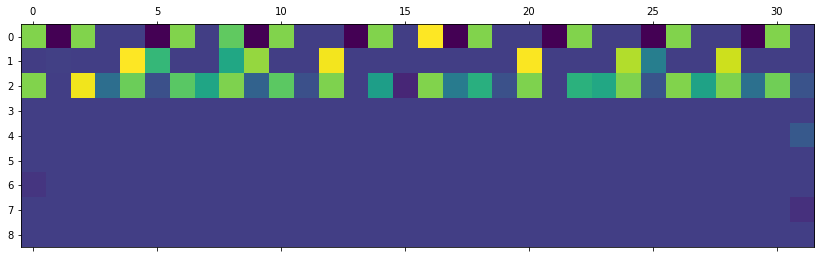



('epoch', 7, 100)
('d_loss', 0.6506616026163101, 'd_cat_acc', 0.65234375, 'a_loss', 1.1586828, 'a_cat_loss', 1.9591438)
('d_accuracy', 0.4140625)
(array([[6]]), u'Techno')


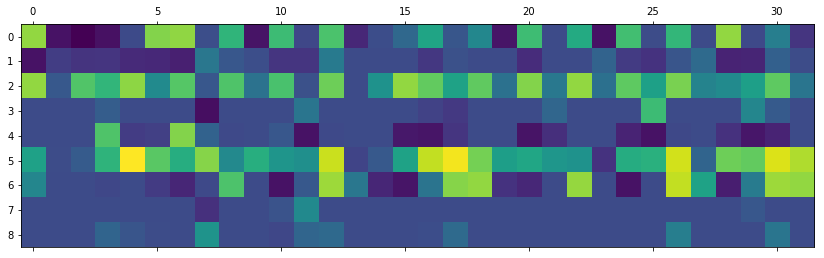



('epoch', 7, 200)
('d_loss', 0.5859621614217758, 'd_cat_acc', 0.66015625, 'a_loss', 1.1813045, 'a_cat_loss', 1.9559203)
('d_accuracy', 0.46875)
(array([[6]]), u'Techno')


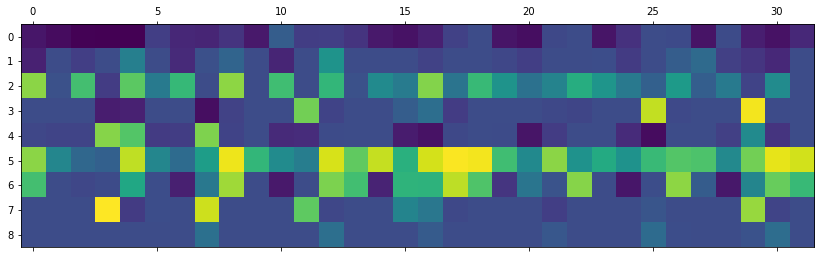



('epoch', 7, 300)
('d_loss', 0.6315314024686813, 'd_cat_acc', 0.72265625, 'a_loss', 1.0488487, 'a_cat_loss', 1.9621425)
('d_accuracy', 0.39453125)
(array([[4]]), u'Breakbeat')


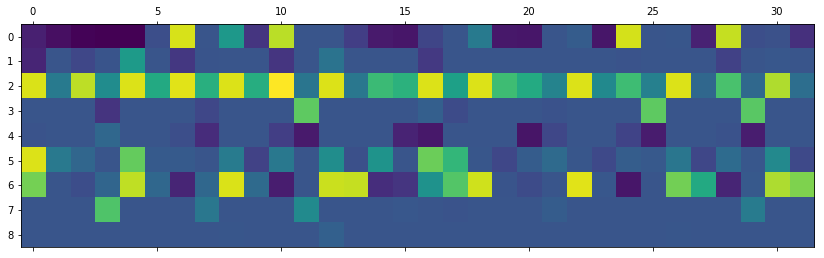



('epoch', 7, 400)
('d_loss', 0.6576397716999054, 'd_cat_acc', 0.62890625, 'a_loss', 1.1234212, 'a_cat_loss', 1.9624984)
('d_accuracy', 0.41796875)
(array([[2]]), u'Jungle')


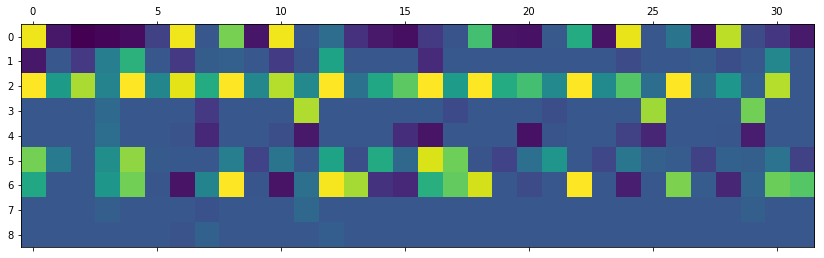



('epoch', 7, 500)
('d_loss', 0.5970343947410583, 'd_cat_acc', 0.640625, 'a_loss', 1.1276808, 'a_cat_loss', 1.963834)
('d_accuracy', 0.453125)
(array([[6]]), u'Techno')


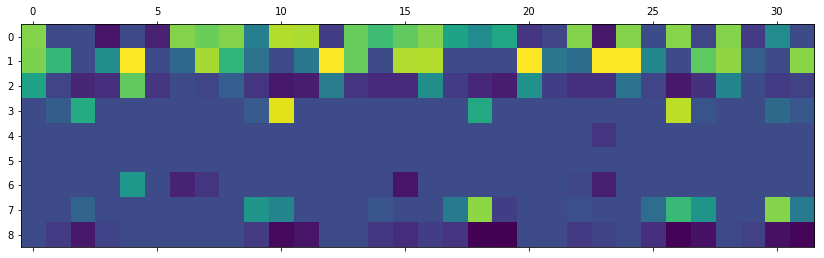



('epoch', 7, 600)
('d_loss', 0.6568055301904678, 'd_cat_acc', 0.67578125, 'a_loss', 0.98655933, 'a_cat_loss', 1.9605885)
('d_accuracy', 0.390625)
(array([[1]]), u'DnB')


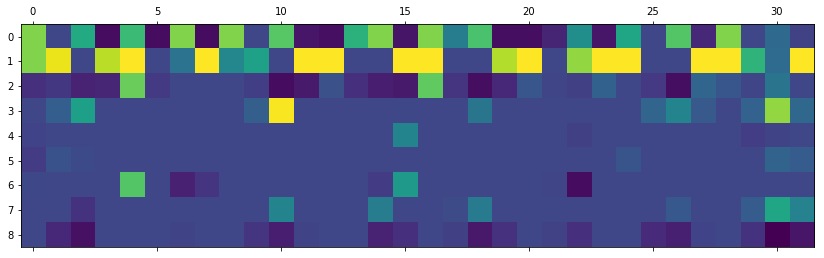



('epoch', 7, 700)
('d_loss', 0.6339043527841568, 'd_cat_acc', 0.66796875, 'a_loss', 0.9981779, 'a_cat_loss', 1.9633522)
('d_accuracy', 0.359375)
(array([[6]]), u'Techno')


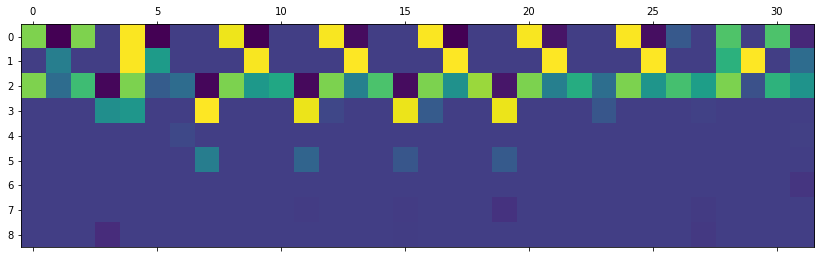



('epoch', 7, 800)
('d_loss', 0.6167746037244797, 'd_cat_acc', 0.64453125, 'a_loss', 1.0991733, 'a_cat_loss', 1.9653208)
('d_accuracy', 0.42578125)
(array([[3]]), u'House')


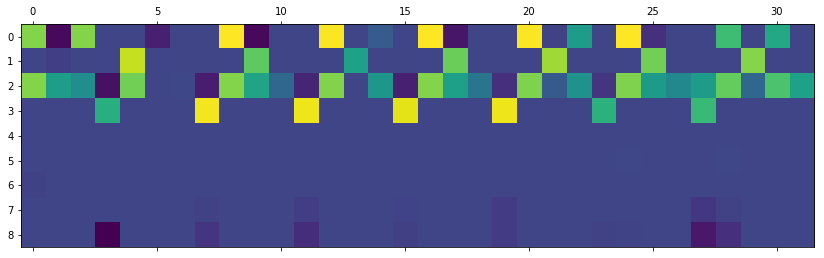



('epoch', 7, 900)
('d_loss', 0.6605231761932373, 'd_cat_acc', 0.69921875, 'a_loss', 0.9069915, 'a_cat_loss', 1.9654329)
('d_accuracy', 0.40625)
(array([[1]]), u'DnB')


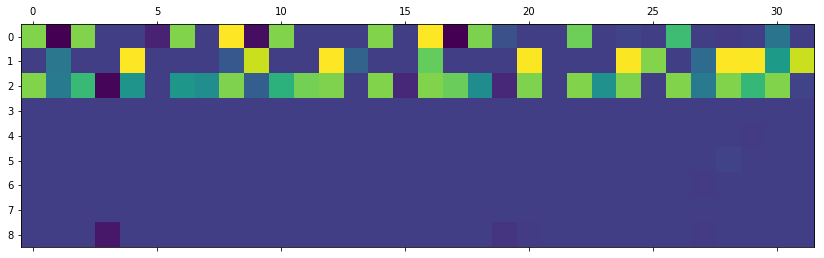



('epoch', 7, 1000)
('d_loss', 0.628983810544014, 'd_cat_acc', 0.64453125, 'a_loss', 1.0783356, 'a_cat_loss', 1.9665384)
('d_accuracy', 0.40234375)
(array([[4]]), u'Breakbeat')


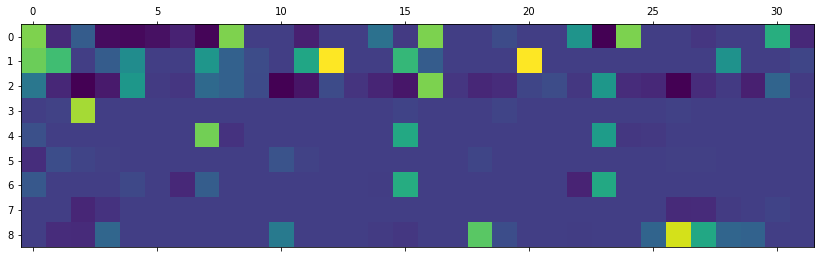



('epoch', 7, 1100)
('d_loss', 0.5967946499586105, 'd_cat_acc', 0.69140625, 'a_loss', 1.0834444, 'a_cat_loss', 1.9612875)
('d_accuracy', 0.46484375)
(array([[4]]), u'Breakbeat')


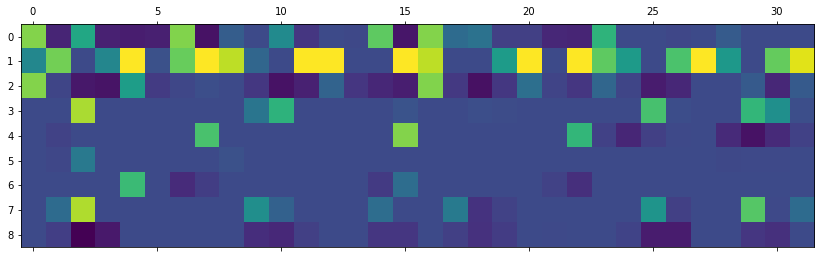



('epoch', 8, 0)
('d_loss', 0.6259826570749283, 'd_cat_acc', 0.66796875, 'a_loss', 1.130717, 'a_cat_loss', 1.9636034)
('d_accuracy', 0.43359375)
(array([[6]]), u'Techno')


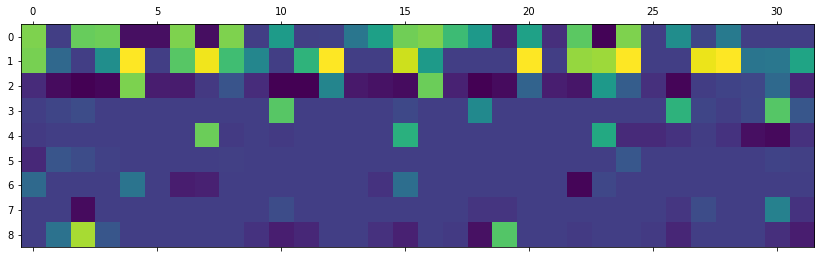



('epoch', 8, 100)
('d_loss', 0.6317072361707687, 'd_cat_acc', 0.73828125, 'a_loss', 0.94283855, 'a_cat_loss', 1.9644387)
('d_accuracy', 0.41015625)
(array([[5]]), u'Garage')


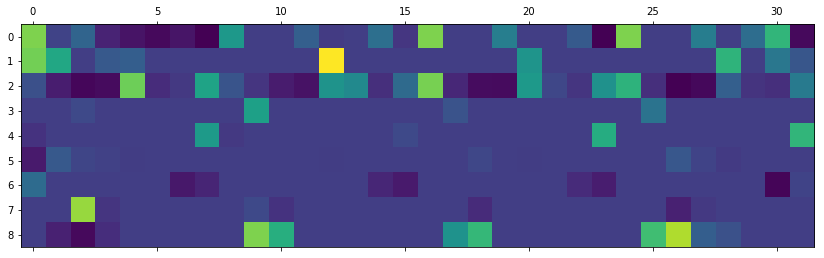



('epoch', 8, 200)
('d_loss', 0.6297676414251328, 'd_cat_acc', 0.72265625, 'a_loss', 0.9527285, 'a_cat_loss', 1.9694382)
('d_accuracy', 0.421875)
(array([[4]]), u'Breakbeat')


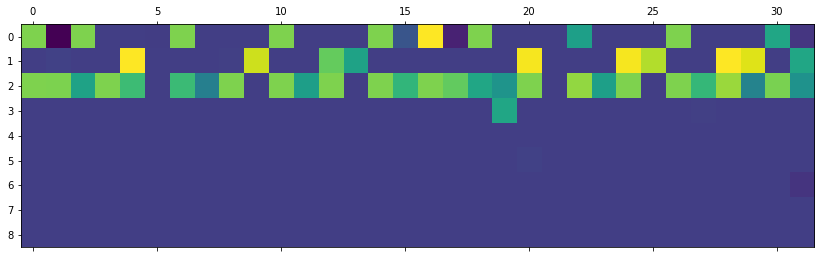



('epoch', 8, 300)
('d_loss', 0.6323913633823395, 'd_cat_acc', 0.671875, 'a_loss', 0.9658091, 'a_cat_loss', 1.9629195)
('d_accuracy', 0.3984375)
(array([[6]]), u'Techno')


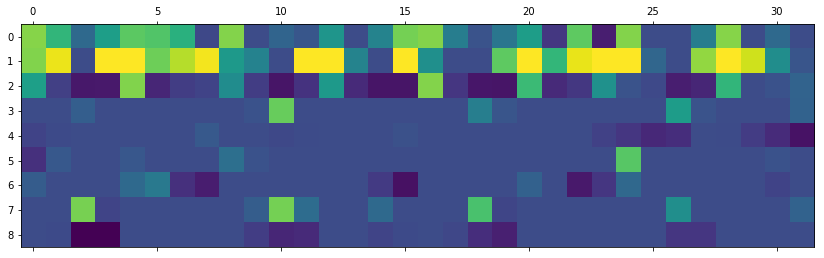



('epoch', 8, 400)
('d_loss', 0.6016423106193542, 'd_cat_acc', 0.65625, 'a_loss', 1.118827, 'a_cat_loss', 1.9659111)
('d_accuracy', 0.42578125)
(array([[5]]), u'Garage')


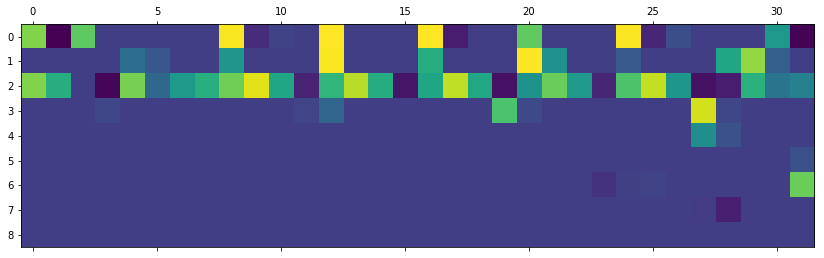



('epoch', 8, 500)
('d_loss', 0.6275811642408371, 'd_cat_acc', 0.7265625, 'a_loss', 1.0808536, 'a_cat_loss', 1.9679114)
('d_accuracy', 0.4296875)
(array([[1]]), u'DnB')


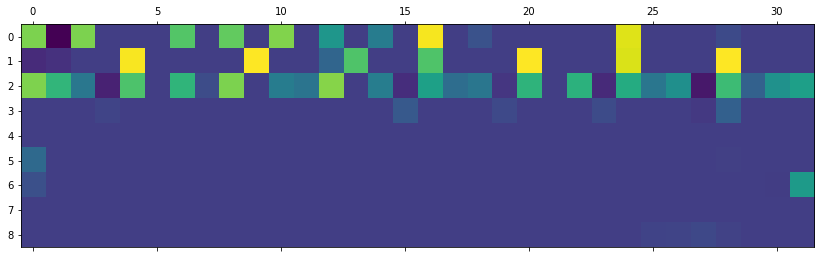



('epoch', 8, 600)
('d_loss', 0.649394154548645, 'd_cat_acc', 0.6484375, 'a_loss', 1.1080289, 'a_cat_loss', 1.9662387)
('d_accuracy', 0.375)
(array([[1]]), u'DnB')


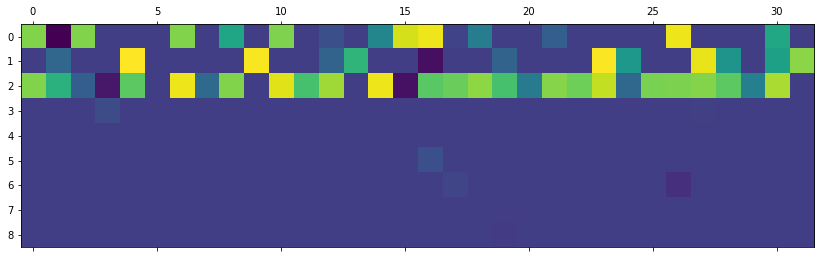



('epoch', 8, 700)
('d_loss', 0.6685792952775955, 'd_cat_acc', 0.67578125, 'a_loss', 1.0160964, 'a_cat_loss', 1.9666564)
('d_accuracy', 0.390625)
(array([[2]]), u'Jungle')


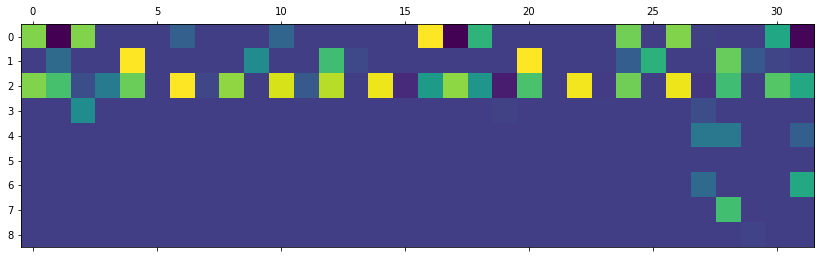



('epoch', 8, 800)
('d_loss', 0.6730265617370605, 'd_cat_acc', 0.69140625, 'a_loss', 1.0501233, 'a_cat_loss', 1.9634101)
('d_accuracy', 0.41796875)
(array([[5]]), u'Garage')


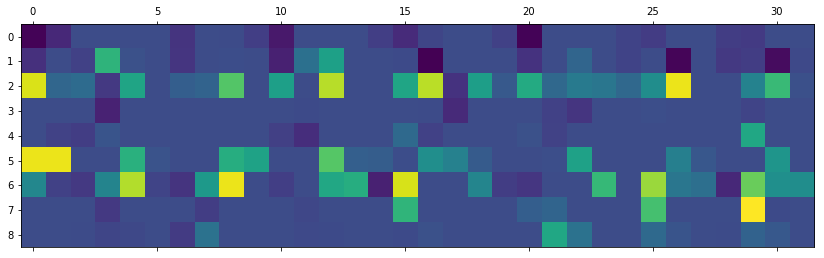



('epoch', 8, 900)
('d_loss', 0.691053107380867, 'd_cat_acc', 0.66015625, 'a_loss', 1.1854047, 'a_cat_loss', 1.967626)
('d_accuracy', 0.44140625)
(array([[3]]), u'House')


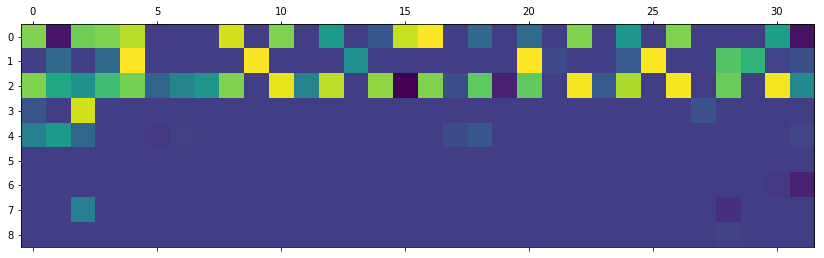



('epoch', 8, 1000)
('d_loss', 0.6102208495140076, 'd_cat_acc', 0.70703125, 'a_loss', 1.3520693, 'a_cat_loss', 1.9660795)
('d_accuracy', 0.4296875)
(array([[4]]), u'Breakbeat')


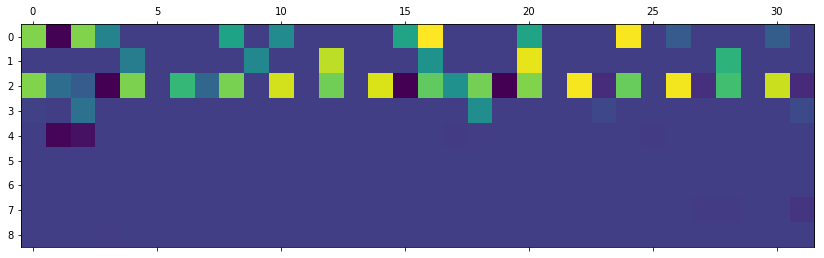



('epoch', 8, 1100)
('d_loss', 0.6333445608615875, 'd_cat_acc', 0.703125, 'a_loss', 0.99970806, 'a_cat_loss', 1.9604332)
('d_accuracy', 0.40234375)
(array([[5]]), u'Garage')


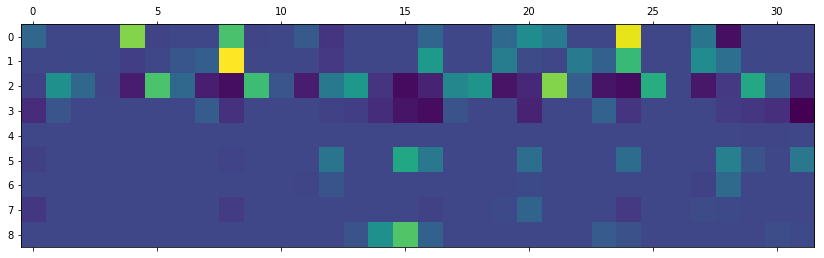



('epoch', 9, 0)
('d_loss', 0.6192591190338135, 'd_cat_acc', 0.66796875, 'a_loss', 1.0840971, 'a_cat_loss', 1.9632616)
('d_accuracy', 0.40625)
(array([[1]]), u'DnB')


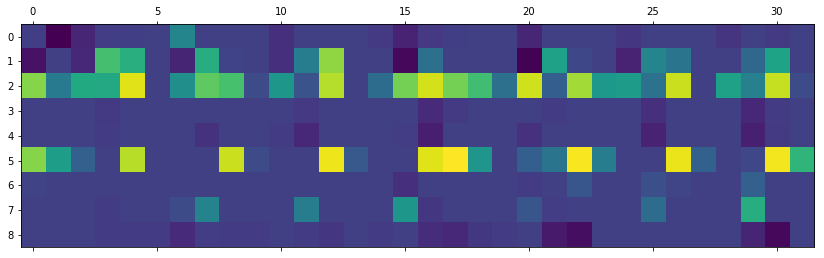



('epoch', 9, 100)
('d_loss', 0.61502905189991, 'd_cat_acc', 0.72265625, 'a_loss', 1.17988, 'a_cat_loss', 1.9600844)
('d_accuracy', 0.41796875)
(array([[1]]), u'DnB')


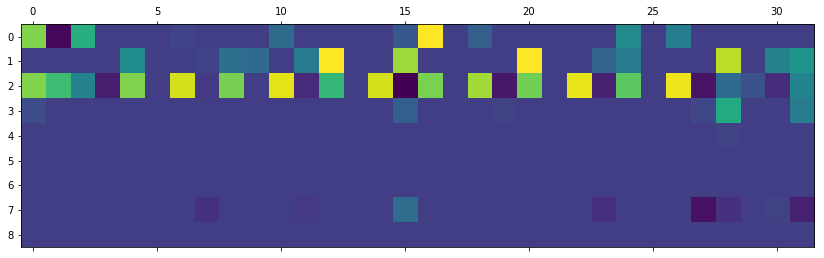



('epoch', 9, 200)
('d_loss', 0.6375919282436371, 'd_cat_acc', 0.6796875, 'a_loss', 1.125286, 'a_cat_loss', 1.966028)
('d_accuracy', 0.453125)
(array([[0]]), u'Old Skool')


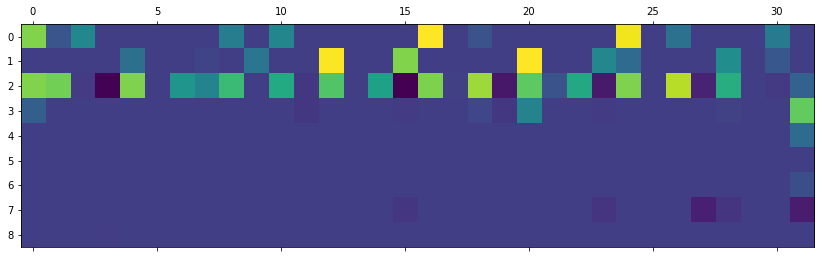



('epoch', 9, 300)
('d_loss', 0.6466518044471741, 'd_cat_acc', 0.68359375, 'a_loss', 1.0292771, 'a_cat_loss', 1.9621103)
('d_accuracy', 0.41015625)
(array([[1]]), u'DnB')


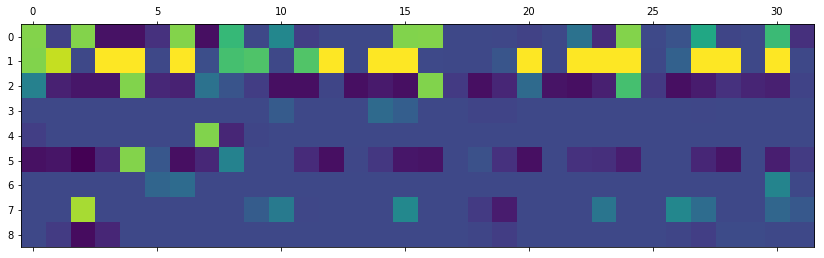



('epoch', 9, 400)
('d_loss', 0.6466438919305801, 'd_cat_acc', 0.7109375, 'a_loss', 0.9255828, 'a_cat_loss', 1.9621083)
('d_accuracy', 0.3828125)
(array([[4]]), u'Breakbeat')


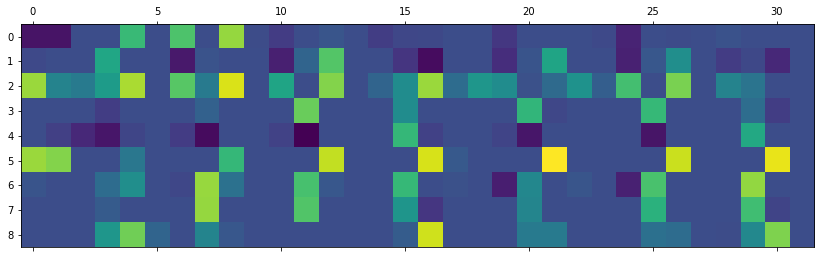



('epoch', 9, 500)
('d_loss', 0.6652852892875671, 'd_cat_acc', 0.73046875, 'a_loss', 1.1055503, 'a_cat_loss', 1.9672868)
('d_accuracy', 0.3984375)
(array([[1]]), u'DnB')


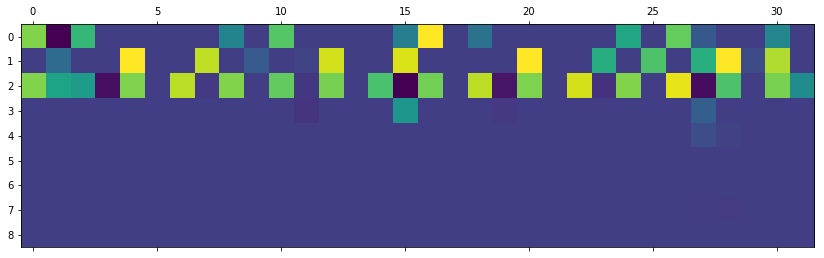



('epoch', 9, 600)
('d_loss', 0.6561195403337479, 'd_cat_acc', 0.7109375, 'a_loss', 0.95781416, 'a_cat_loss', 1.9709846)
('d_accuracy', 0.37109375)
(array([[3]]), u'House')


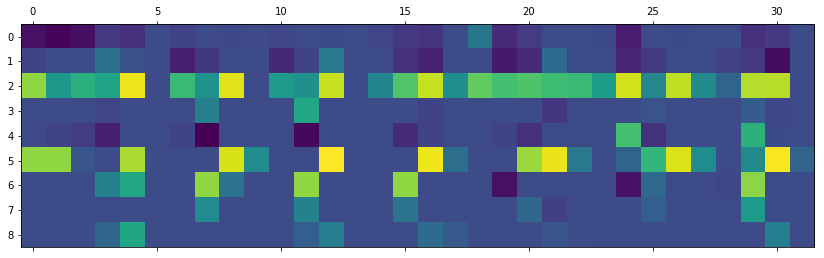



('epoch', 9, 700)
('d_loss', 0.6600304841995239, 'd_cat_acc', 0.69921875, 'a_loss', 0.98089075, 'a_cat_loss', 1.9671872)
('d_accuracy', 0.38671875)
(array([[3]]), u'House')


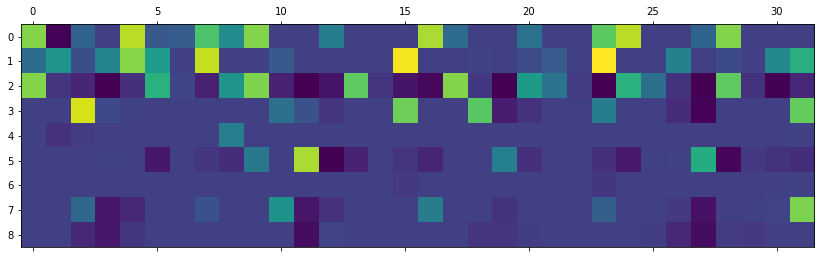



('epoch', 9, 800)
('d_loss', 0.6654348820447922, 'd_cat_acc', 0.6953125, 'a_loss', 1.0205309, 'a_cat_loss', 1.9689744)
('d_accuracy', 0.4296875)
(array([[4]]), u'Breakbeat')


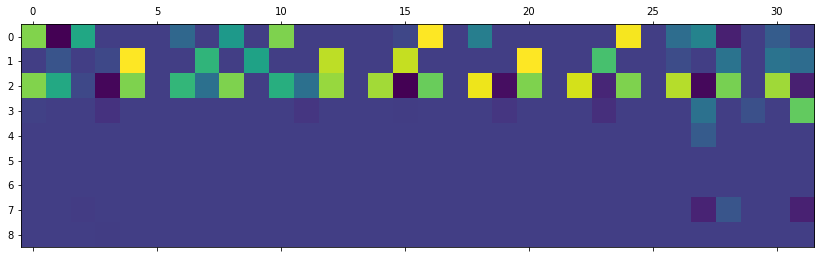



('epoch', 9, 900)
('d_loss', 0.6414628624916077, 'd_cat_acc', 0.71875, 'a_loss', 1.0334704, 'a_cat_loss', 1.9661864)
('d_accuracy', 0.3984375)
(array([[3]]), u'House')


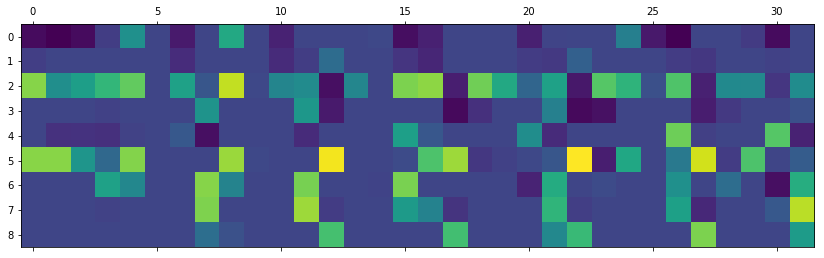



('epoch', 9, 1000)
('d_loss', 0.6394806504249573, 'd_cat_acc', 0.70703125, 'a_loss', 0.97786516, 'a_cat_loss', 1.9664613)
('d_accuracy', 0.41015625)
(array([[2]]), u'Jungle')


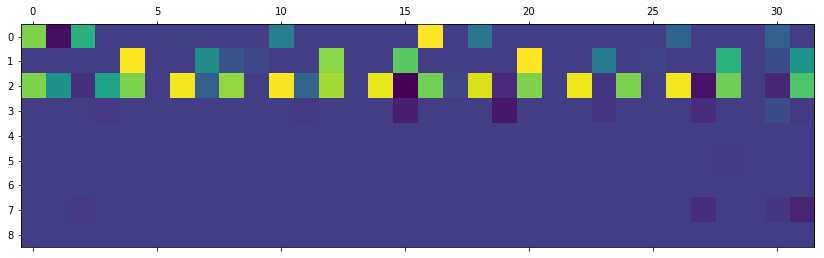



('epoch', 9, 1100)
('d_loss', 0.6506692320108414, 'd_cat_acc', 0.71875, 'a_loss', 0.9073545, 'a_cat_loss', 1.9696314)
('d_accuracy', 0.4375)
(array([[1]]), u'DnB')


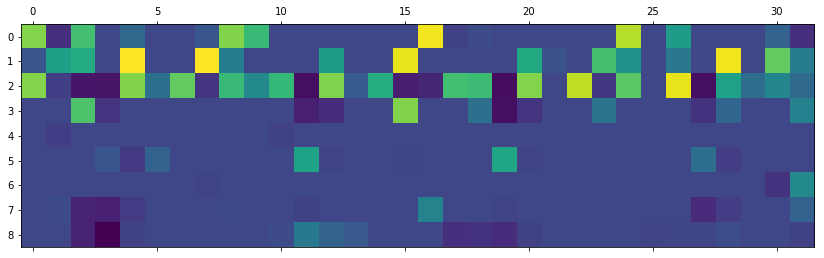



('epoch', 10, 0)
('d_loss', 0.6756624430418015, 'd_cat_acc', 0.67578125, 'a_loss', 1.0180681, 'a_cat_loss', 1.96806)
('d_accuracy', 0.4296875)
(array([[4]]), u'Breakbeat')


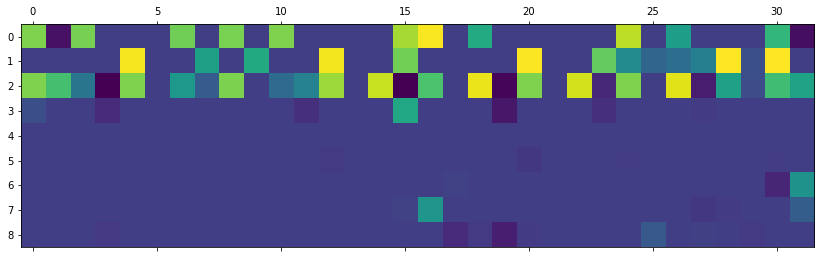



('epoch', 10, 100)
('d_loss', 0.6734840571880341, 'd_cat_acc', 0.7109375, 'a_loss', 0.96584153, 'a_cat_loss', 1.9606347)
('d_accuracy', 0.3984375)
(array([[6]]), u'Techno')


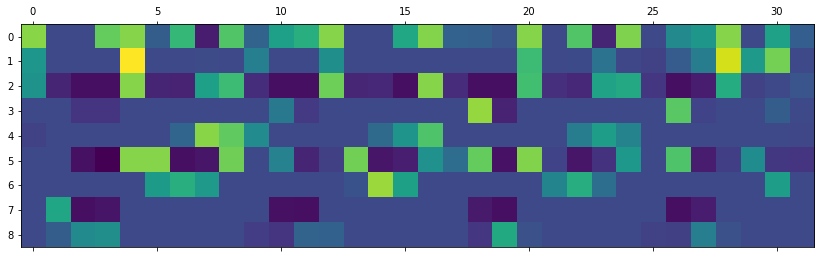



('epoch', 10, 200)
('d_loss', 0.6380784660577774, 'd_cat_acc', 0.734375, 'a_loss', 1.0566084, 'a_cat_loss', 1.9669045)
('d_accuracy', 0.41015625)
(array([[2]]), u'Jungle')


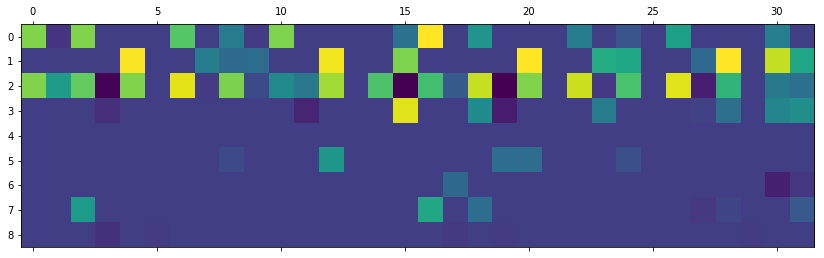



('epoch', 10, 300)
('d_loss', 0.6302112191915512, 'd_cat_acc', 0.734375, 'a_loss', 0.9292553, 'a_cat_loss', 1.9667689)
('d_accuracy', 0.37890625)
(array([[5]]), u'Garage')


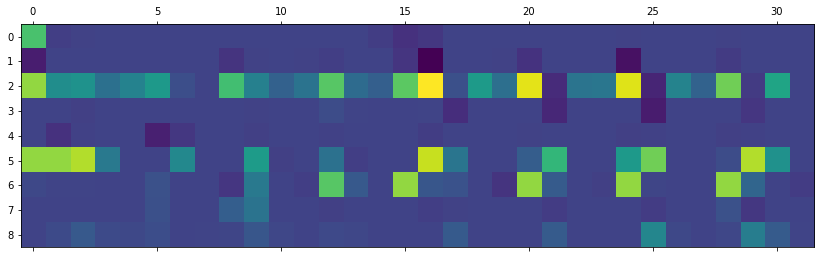



('epoch', 10, 400)
('d_loss', 0.6527979969978333, 'd_cat_acc', 0.6484375, 'a_loss', 0.9228294, 'a_cat_loss', 1.9686111)
('d_accuracy', 0.3828125)
(array([[5]]), u'Garage')


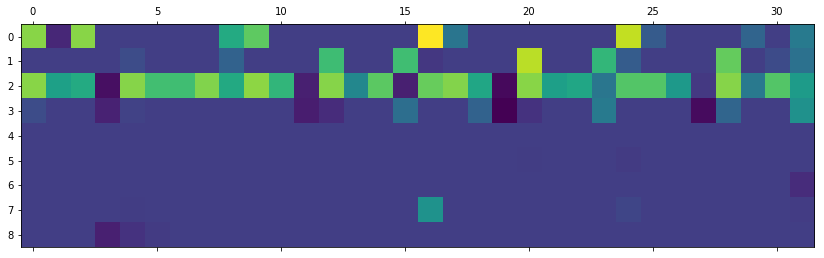



('epoch', 10, 500)
('d_loss', 0.637652799487114, 'd_cat_acc', 0.703125, 'a_loss', 0.93932617, 'a_cat_loss', 1.9723318)
('d_accuracy', 0.37109375)
(array([[0]]), u'Old Skool')


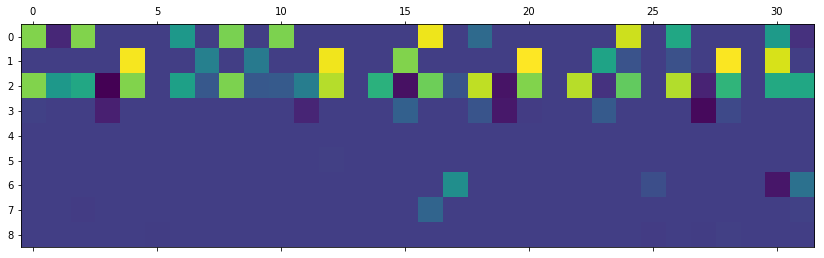



('epoch', 10, 600)
('d_loss', 0.658270388841629, 'd_cat_acc', 0.74609375, 'a_loss', 0.97066474, 'a_cat_loss', 1.9698366)
('d_accuracy', 0.38671875)
(array([[2]]), u'Jungle')


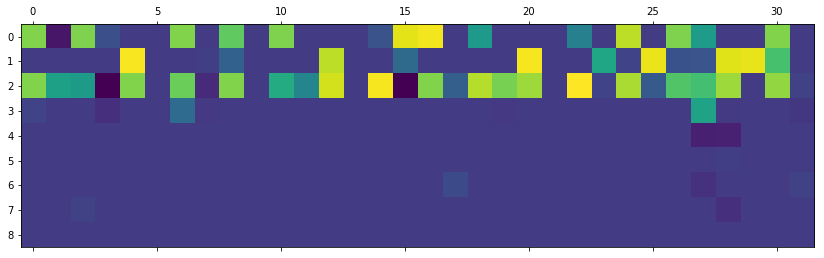



('epoch', 10, 700)
('d_loss', 0.6506544798612595, 'd_cat_acc', 0.6953125, 'a_loss', 1.0550683, 'a_cat_loss', 1.9700809)
('d_accuracy', 0.4609375)
(array([[4]]), u'Breakbeat')


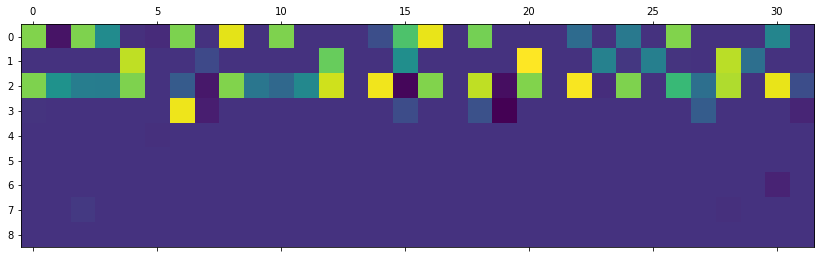



('epoch', 10, 800)
('d_loss', 0.6332523077726364, 'd_cat_acc', 0.70703125, 'a_loss', 0.86850315, 'a_cat_loss', 1.967768)
('d_accuracy', 0.37109375)
(array([[1]]), u'DnB')


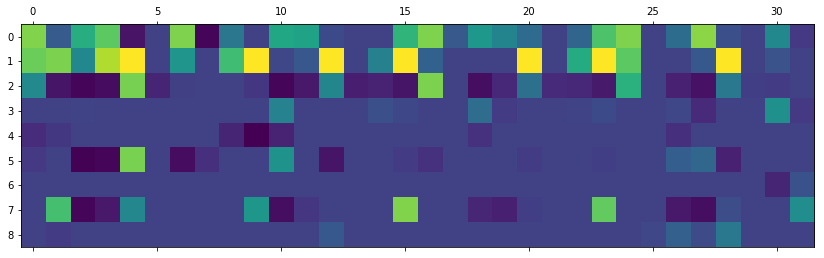



('epoch', 10, 900)
('d_loss', 0.642254039645195, 'd_cat_acc', 0.72265625, 'a_loss', 0.9413699, 'a_cat_loss', 1.9699855)
('d_accuracy', 0.40625)
(array([[2]]), u'Jungle')


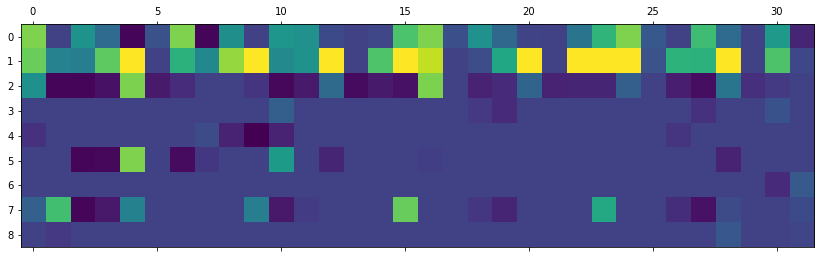



('epoch', 10, 1000)
('d_loss', 0.6519419103860855, 'd_cat_acc', 0.7109375, 'a_loss', 1.0216726, 'a_cat_loss', 1.9627959)
('d_accuracy', 0.41796875)
(array([[0]]), u'Old Skool')


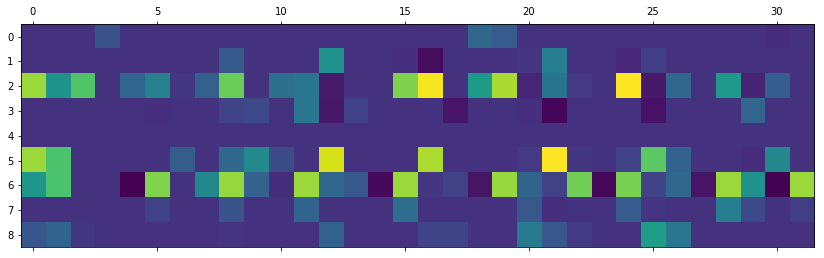



('epoch', 10, 1100)
('d_loss', 0.6343383640050888, 'd_cat_acc', 0.73046875, 'a_loss', 0.98303366, 'a_cat_loss', 1.9657915)
('d_accuracy', 0.42578125)
(array([[0]]), u'Old Skool')


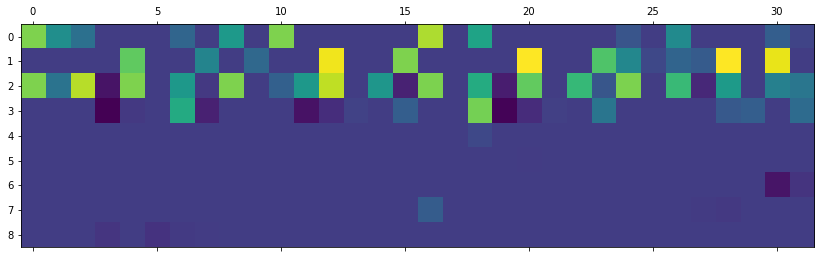



('epoch', 11, 0)
('d_loss', 0.6436110287904739, 'd_cat_acc', 0.70703125, 'a_loss', 0.9158695, 'a_cat_loss', 1.9694927)
('d_accuracy', 0.39453125)
(array([[4]]), u'Breakbeat')


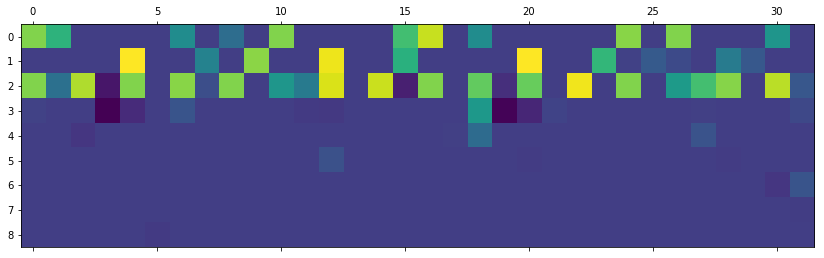



('epoch', 11, 100)
('d_loss', 0.6284476667642593, 'd_cat_acc', 0.73828125, 'a_loss', 0.9349712, 'a_cat_loss', 1.9714549)
('d_accuracy', 0.4296875)
(array([[4]]), u'Breakbeat')


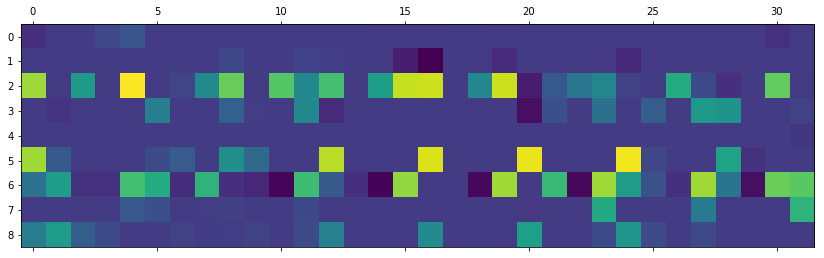



('epoch', 11, 200)
('d_loss', 0.6421597748994827, 'd_cat_acc', 0.7578125, 'a_loss', 1.0089669, 'a_cat_loss', 1.9672605)
('d_accuracy', 0.4375)
(array([[4]]), u'Breakbeat')


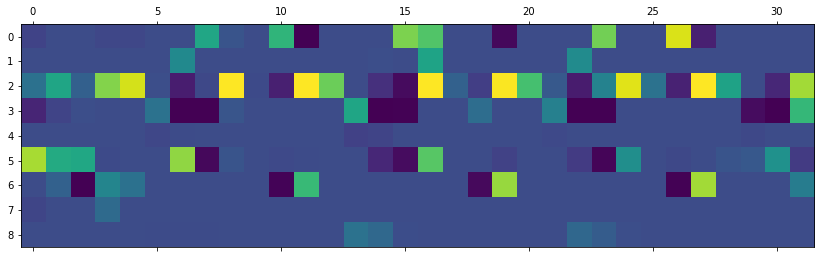



('epoch', 11, 300)
('d_loss', 0.6546841263771057, 'd_cat_acc', 0.7109375, 'a_loss', 1.0595945, 'a_cat_loss', 1.9713999)
('d_accuracy', 0.44140625)
(array([[2]]), u'Jungle')


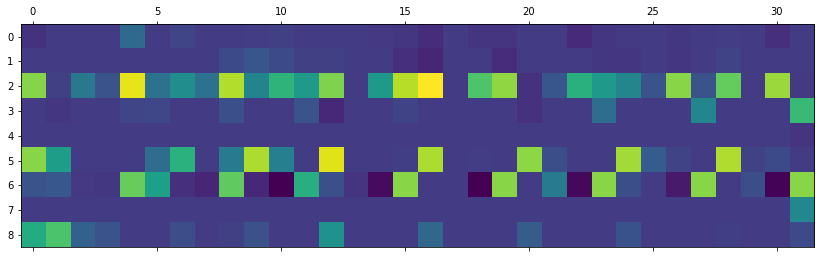



('epoch', 11, 400)
('d_loss', 0.6542646735906601, 'd_cat_acc', 0.66015625, 'a_loss', 0.9764645, 'a_cat_loss', 1.97024)
('d_accuracy', 0.4375)
(array([[1]]), u'DnB')


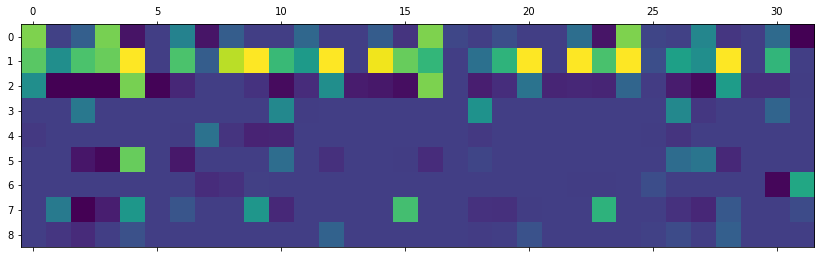



('epoch', 11, 500)
('d_loss', 0.6415748596191406, 'd_cat_acc', 0.74609375, 'a_loss', 1.0420758, 'a_cat_loss', 1.9702613)
('d_accuracy', 0.36328125)
(array([[6]]), u'Techno')


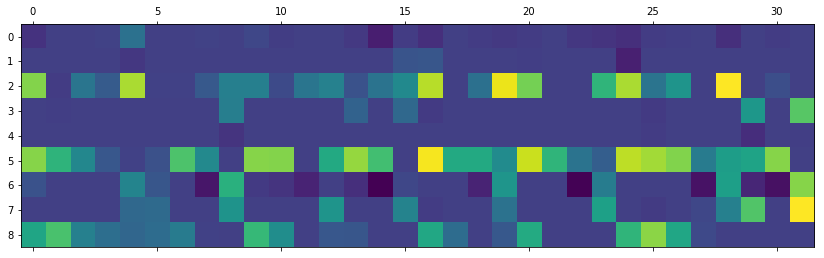



('epoch', 11, 600)
('d_loss', 0.6239721328020096, 'd_cat_acc', 0.7265625, 'a_loss', 1.0901753, 'a_cat_loss', 1.9629768)
('d_accuracy', 0.4140625)
(array([[6]]), u'Techno')


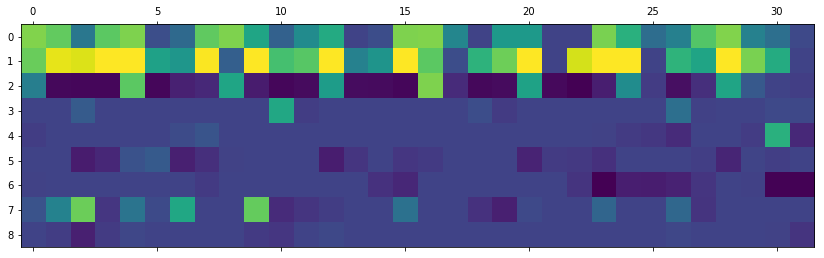



('epoch', 11, 700)
('d_loss', 0.6218677312135696, 'd_cat_acc', 0.703125, 'a_loss', 0.9766294, 'a_cat_loss', 1.9672697)
('d_accuracy', 0.45703125)
(array([[4]]), u'Breakbeat')


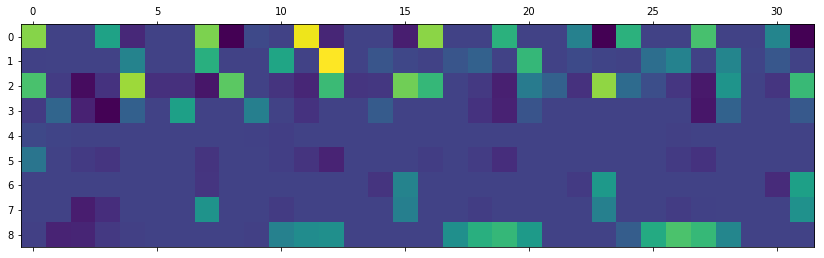



('epoch', 11, 800)
('d_loss', 0.6472209542989731, 'd_cat_acc', 0.6953125, 'a_loss', 0.9486304, 'a_cat_loss', 1.9638067)
('d_accuracy', 0.4140625)
(array([[1]]), u'DnB')


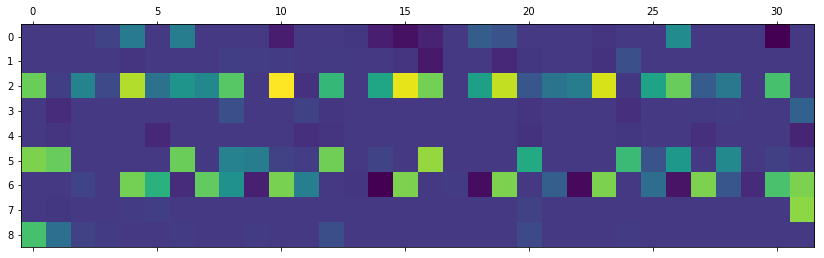



('epoch', 11, 900)
('d_loss', 0.6517837643623352, 'd_cat_acc', 0.71875, 'a_loss', 0.89428043, 'a_cat_loss', 1.9687756)
('d_accuracy', 0.34375)
(array([[6]]), u'Techno')


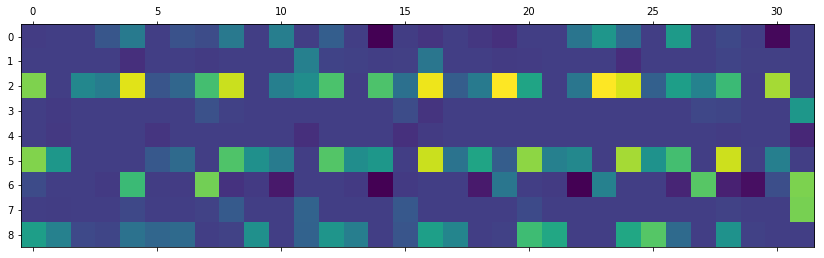



('epoch', 11, 1000)
('d_loss', 0.6368319690227509, 'd_cat_acc', 0.6953125, 'a_loss', 0.8982567, 'a_cat_loss', 1.9724667)
('d_accuracy', 0.4296875)
(array([[3]]), u'House')


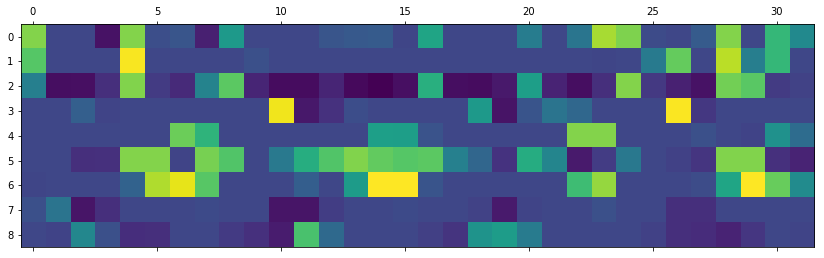



('epoch', 11, 1100)
('d_loss', 0.6515283435583115, 'd_cat_acc', 0.703125, 'a_loss', 0.8612138, 'a_cat_loss', 1.9711149)
('d_accuracy', 0.35546875)
(array([[6]]), u'Techno')


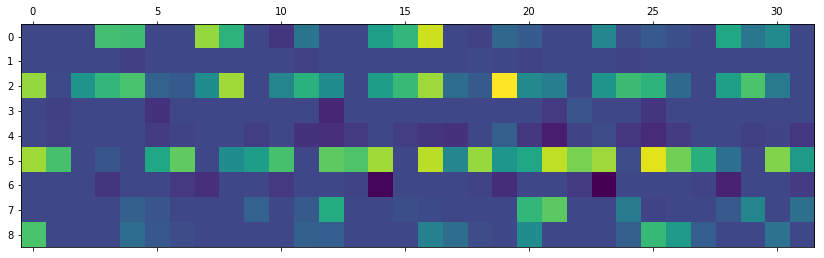



('epoch', 12, 0)
('d_loss', 0.6492239534854889, 'd_cat_acc', 0.72265625, 'a_loss', 0.8715004, 'a_cat_loss', 1.9763179)
('d_accuracy', 0.33984375)
(array([[1]]), u'DnB')


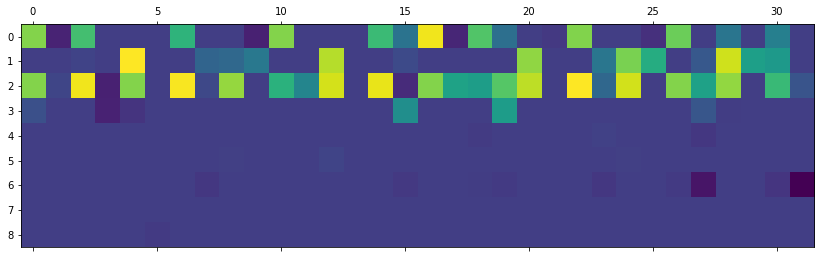



('epoch', 12, 100)
('d_loss', 0.6545862108469009, 'd_cat_acc', 0.73046875, 'a_loss', 0.90724283, 'a_cat_loss', 1.9716132)
('d_accuracy', 0.41796875)
(array([[2]]), u'Jungle')


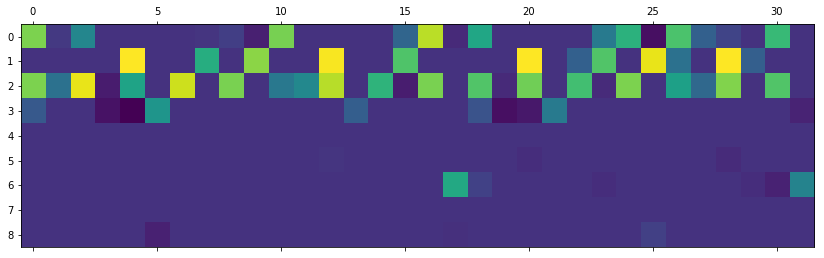



('epoch', 12, 200)
('d_loss', 0.6702994853258133, 'd_cat_acc', 0.6953125, 'a_loss', 0.9024923, 'a_cat_loss', 1.9709704)
('d_accuracy', 0.390625)
(array([[0]]), u'Old Skool')


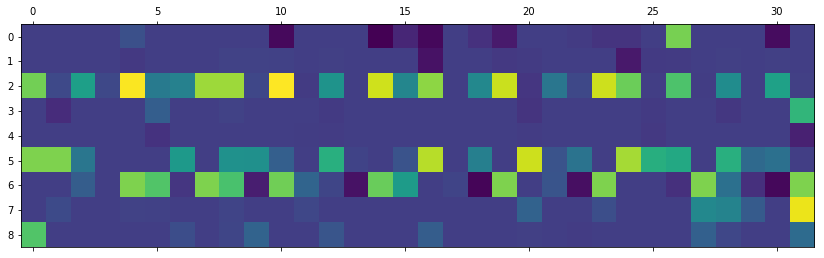



('epoch', 12, 300)
('d_loss', 0.6581089347600937, 'd_cat_acc', 0.765625, 'a_loss', 0.9143611, 'a_cat_loss', 1.9651437)
('d_accuracy', 0.37109375)
(array([[4]]), u'Breakbeat')


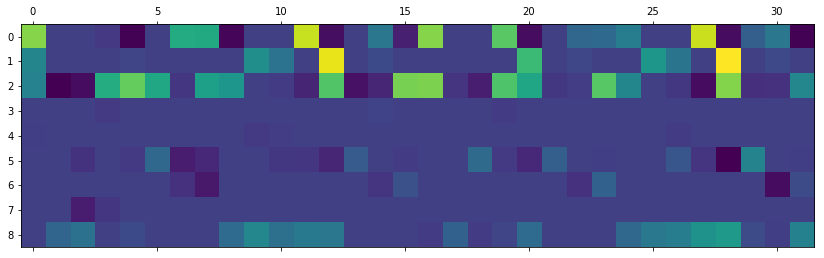



('epoch', 12, 400)
('d_loss', 0.6037692129611969, 'd_cat_acc', 0.69140625, 'a_loss', 0.94590163, 'a_cat_loss', 1.9769785)
('d_accuracy', 0.40625)
(array([[5]]), u'Garage')


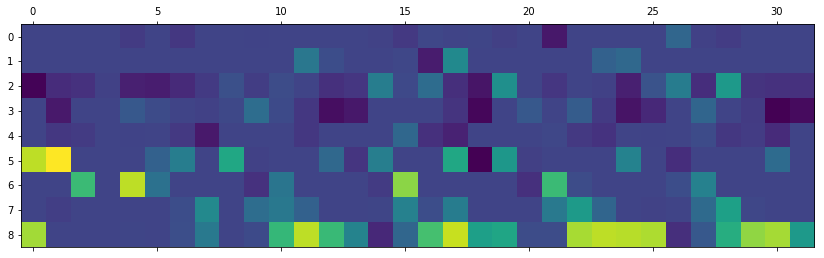



('epoch', 12, 500)
('d_loss', 0.6518508940935135, 'd_cat_acc', 0.7109375, 'a_loss', 0.9436832, 'a_cat_loss', 1.9637451)
('d_accuracy', 0.46484375)
(array([[2]]), u'Jungle')


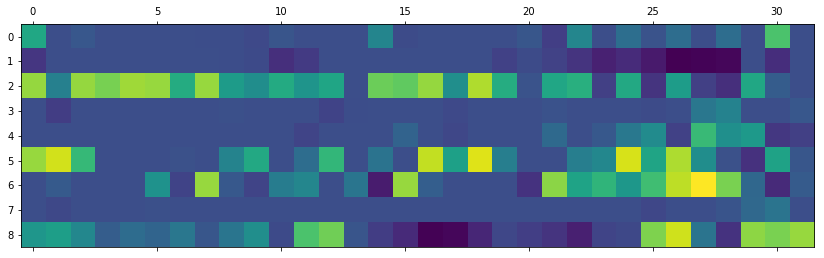



('epoch', 12, 600)
('d_loss', 0.6671755313873291, 'd_cat_acc', 0.734375, 'a_loss', 0.98411345, 'a_cat_loss', 1.9668887)
('d_accuracy', 0.42578125)
(array([[6]]), u'Techno')


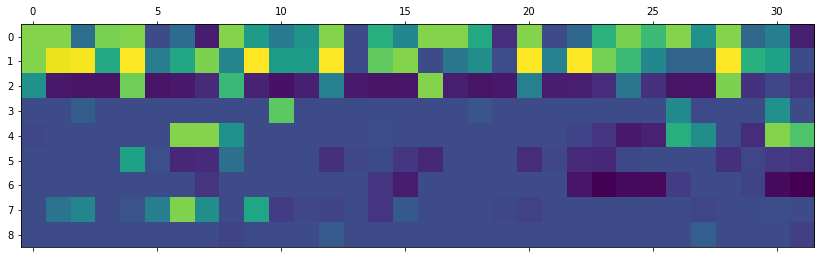



('epoch', 12, 700)
('d_loss', 0.6518156677484512, 'd_cat_acc', 0.703125, 'a_loss', 1.0337977, 'a_cat_loss', 1.9687839)
('d_accuracy', 0.421875)
(array([[2]]), u'Jungle')


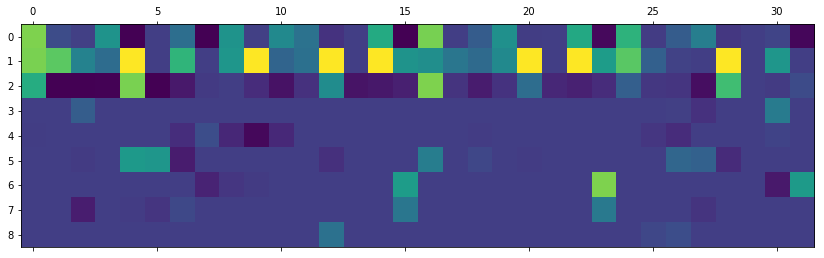



('epoch', 12, 800)
('d_loss', 0.6598107218742371, 'd_cat_acc', 0.77734375, 'a_loss', 0.9691385, 'a_cat_loss', 1.9713976)
('d_accuracy', 0.40234375)
(array([[1]]), u'DnB')


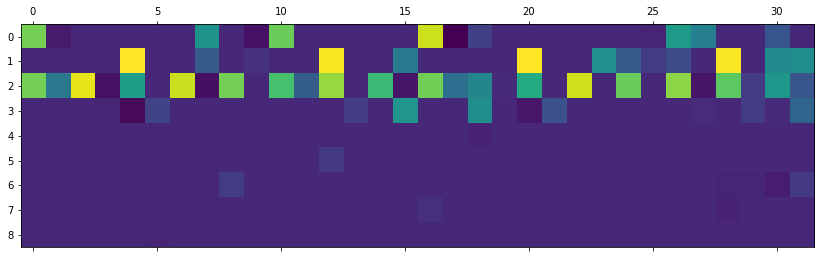



('epoch', 12, 900)
('d_loss', 0.652605339884758, 'd_cat_acc', 0.76171875, 'a_loss', 0.8576449, 'a_cat_loss', 1.9677744)
('d_accuracy', 0.41015625)
(array([[0]]), u'Old Skool')


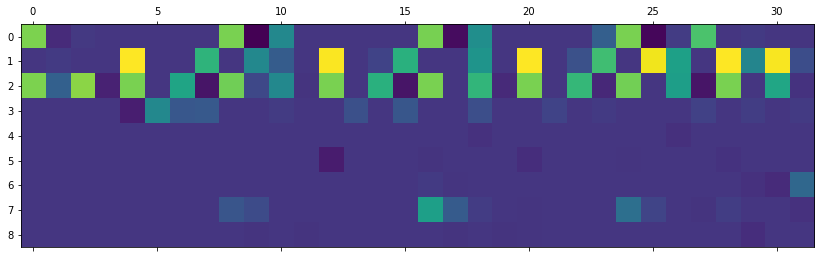



('epoch', 12, 1000)
('d_loss', 0.6778107285499573, 'd_cat_acc', 0.7265625, 'a_loss', 0.8918936, 'a_cat_loss', 1.9700589)
('d_accuracy', 0.34765625)
(array([[5]]), u'Garage')


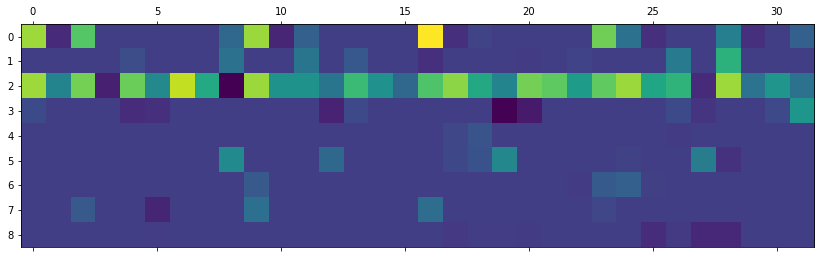



('epoch', 12, 1100)
('d_loss', 0.6415716856718063, 'd_cat_acc', 0.75390625, 'a_loss', 1.2258272, 'a_cat_loss', 1.9690969)
('d_accuracy', 0.44921875)
(array([[5]]), u'Garage')


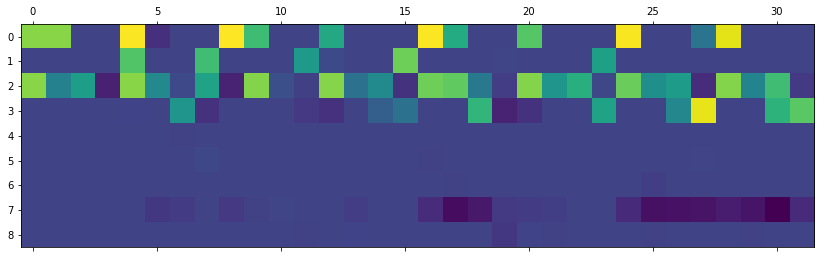



('epoch', 13, 0)
('d_loss', 0.6225133538246155, 'd_cat_acc', 0.8125, 'a_loss', 1.0184736, 'a_cat_loss', 1.9688607)
('d_accuracy', 0.46484375)
(array([[1]]), u'DnB')


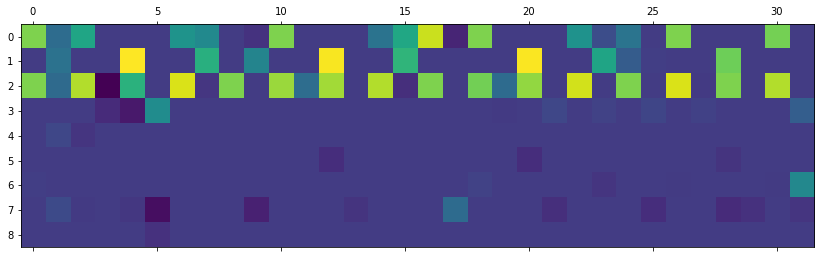



('epoch', 13, 100)
('d_loss', 0.6351961195468903, 'd_cat_acc', 0.75390625, 'a_loss', 0.853269, 'a_cat_loss', 1.9760247)
('d_accuracy', 0.4453125)
(array([[6]]), u'Techno')


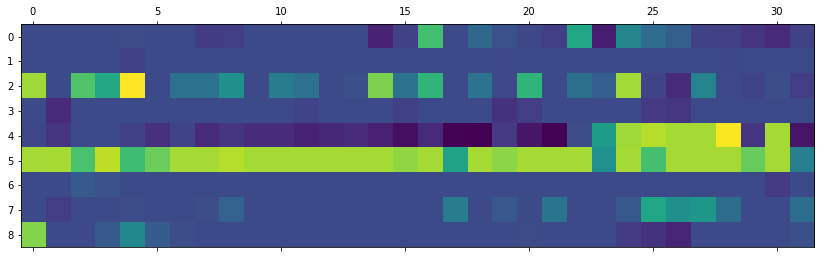



('epoch', 13, 200)
('d_loss', 0.6410162299871445, 'd_cat_acc', 0.73046875, 'a_loss', 0.88536596, 'a_cat_loss', 1.9670515)
('d_accuracy', 0.375)
(array([[5]]), u'Garage')


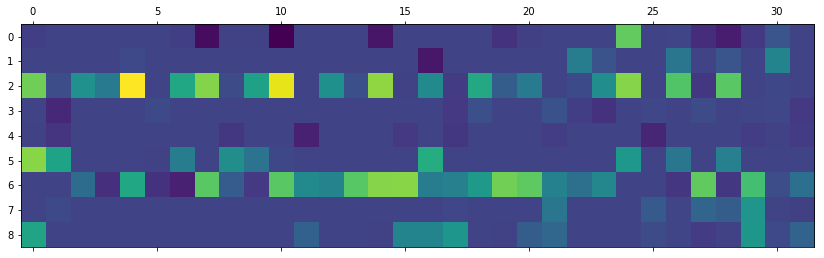



('epoch', 13, 300)
('d_loss', 0.6445469409227371, 'd_cat_acc', 0.76171875, 'a_loss', 0.9397861, 'a_cat_loss', 1.9648445)
('d_accuracy', 0.421875)
(array([[0]]), u'Old Skool')


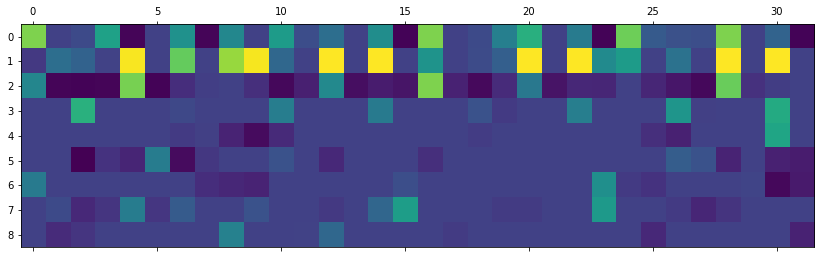



('epoch', 13, 400)
('d_loss', 0.6393893659114838, 'd_cat_acc', 0.71484375, 'a_loss', 1.0090234, 'a_cat_loss', 1.9725561)
('d_accuracy', 0.41796875)
(array([[1]]), u'DnB')


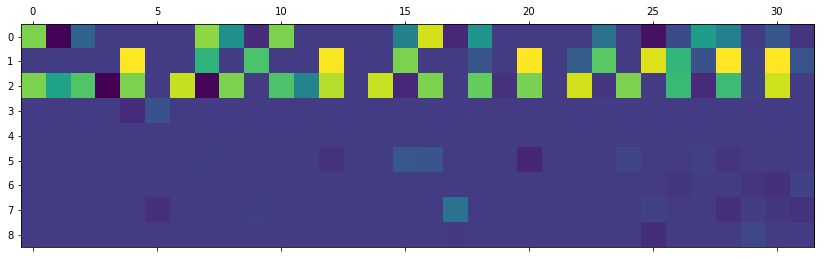



('epoch', 13, 500)
('d_loss', 0.626970499753952, 'd_cat_acc', 0.72265625, 'a_loss', 0.9650848, 'a_cat_loss', 1.9693184)
('d_accuracy', 0.40234375)
(array([[6]]), u'Techno')


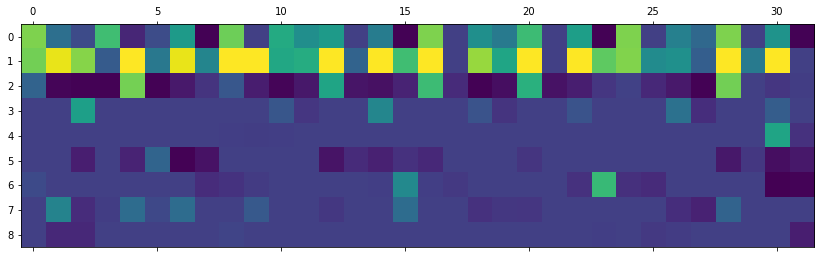



('epoch', 13, 600)
('d_loss', 0.670180544257164, 'd_cat_acc', 0.71875, 'a_loss', 0.9755473, 'a_cat_loss', 1.9731939)
('d_accuracy', 0.44921875)
(array([[2]]), u'Jungle')


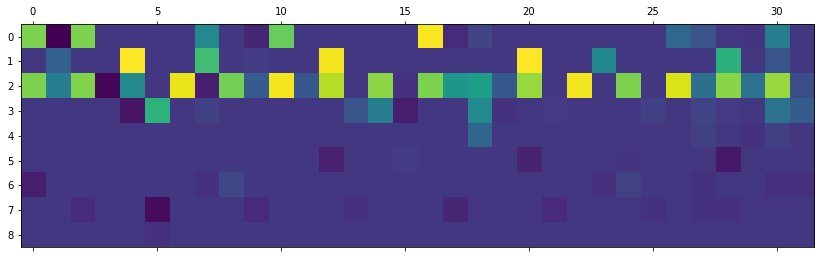



('epoch', 13, 700)
('d_loss', 0.6634763777256012, 'd_cat_acc', 0.7421875, 'a_loss', 0.8664808, 'a_cat_loss', 1.9686999)
('d_accuracy', 0.3984375)
(array([[0]]), u'Old Skool')


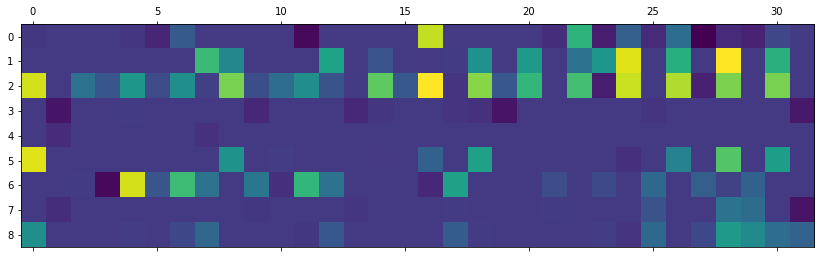



('epoch', 13, 800)
('d_loss', 0.6538397818803787, 'd_cat_acc', 0.7421875, 'a_loss', 1.0158598, 'a_cat_loss', 1.9701732)
('d_accuracy', 0.3984375)
(array([[6]]), u'Techno')


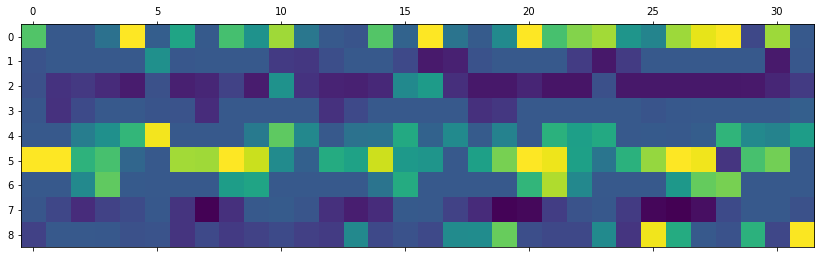



('epoch', 13, 900)
('d_loss', 0.6461429297924042, 'd_cat_acc', 0.75, 'a_loss', 1.0146291, 'a_cat_loss', 1.9756114)
('d_accuracy', 0.3828125)
(array([[0]]), u'Old Skool')


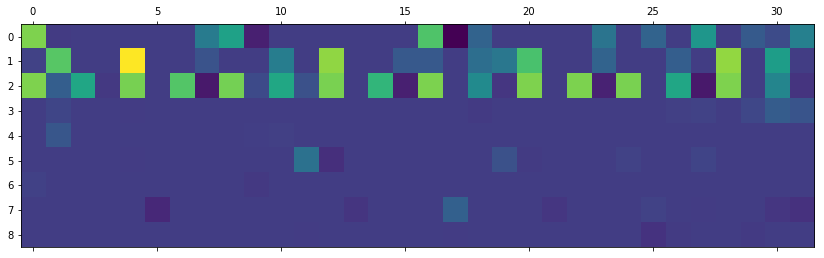



('epoch', 13, 1000)
('d_loss', 0.6476553529500961, 'd_cat_acc', 0.79296875, 'a_loss', 0.7845681, 'a_cat_loss', 1.9621505)
('d_accuracy', 0.40234375)
(array([[1]]), u'DnB')


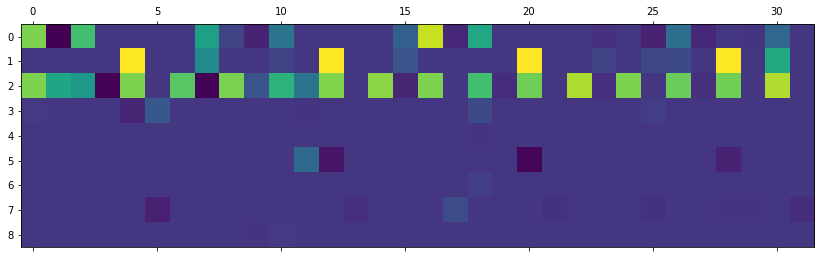



('epoch', 13, 1100)
('d_loss', 0.6405381560325623, 'd_cat_acc', 0.67578125, 'a_loss', 1.0033212, 'a_cat_loss', 1.9721177)
('d_accuracy', 0.38671875)
(array([[2]]), u'Jungle')


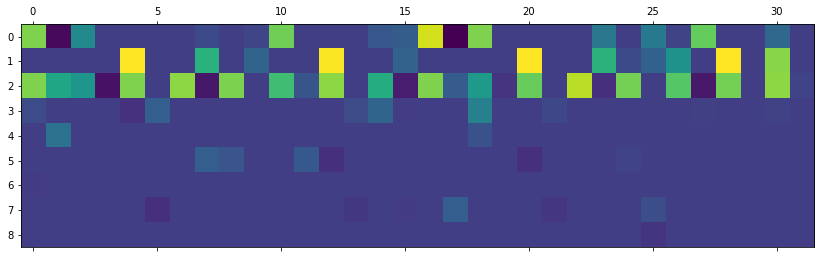



('epoch', 14, 0)
('d_loss', 0.6342770755290985, 'd_cat_acc', 0.69140625, 'a_loss', 1.0547767, 'a_cat_loss', 1.9659595)
('d_accuracy', 0.375)
(array([[3]]), u'House')


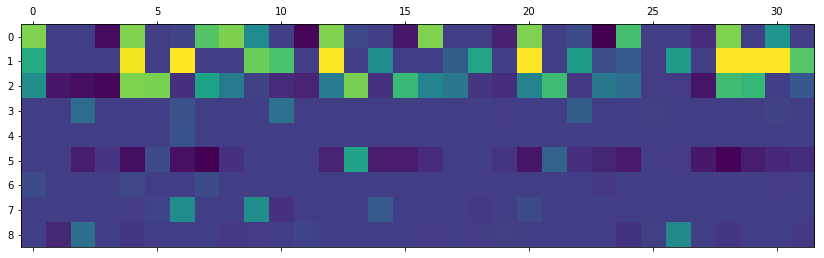



('epoch', 14, 100)
('d_loss', 0.6138514280319214, 'd_cat_acc', 0.7421875, 'a_loss', 1.1893708, 'a_cat_loss', 1.9693999)
('d_accuracy', 0.41015625)
(array([[6]]), u'Techno')


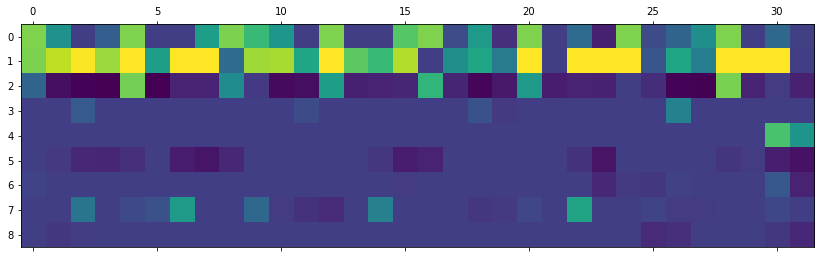



('epoch', 14, 200)
('d_loss', 0.6508690863847733, 'd_cat_acc', 0.74609375, 'a_loss', 0.97117937, 'a_cat_loss', 1.9729332)
('d_accuracy', 0.38671875)
(array([[3]]), u'House')


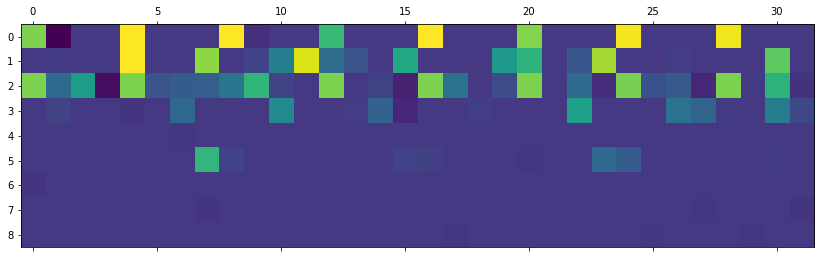



('epoch', 14, 300)
('d_loss', 0.6472528576850891, 'd_cat_acc', 0.76171875, 'a_loss', 0.9642282, 'a_cat_loss', 1.9701462)
('d_accuracy', 0.4375)
(array([[4]]), u'Breakbeat')


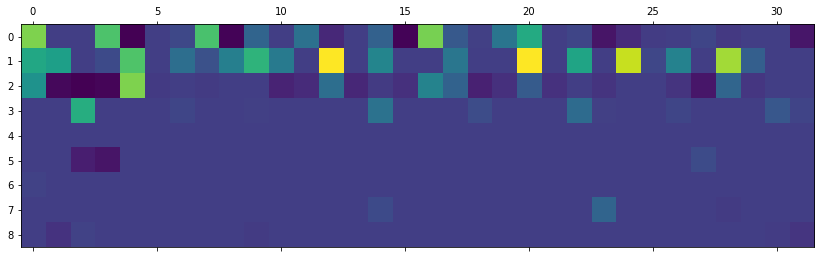



('epoch', 14, 400)
('d_loss', 0.6280760318040848, 'd_cat_acc', 0.71484375, 'a_loss', 1.0089216, 'a_cat_loss', 1.9674437)
('d_accuracy', 0.4375)
(array([[1]]), u'DnB')


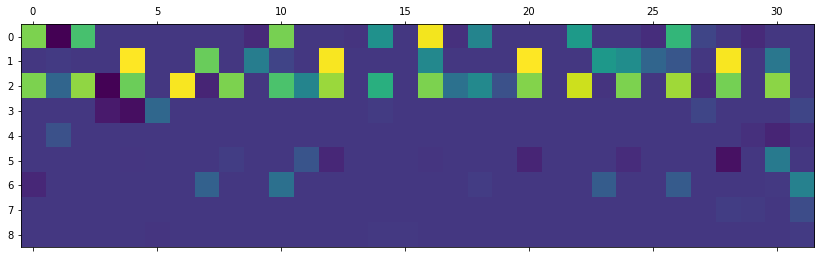



('epoch', 14, 500)
('d_loss', 0.6116514205932617, 'd_cat_acc', 0.7109375, 'a_loss', 0.9604252, 'a_cat_loss', 1.969651)
('d_accuracy', 0.40625)
(array([[1]]), u'DnB')


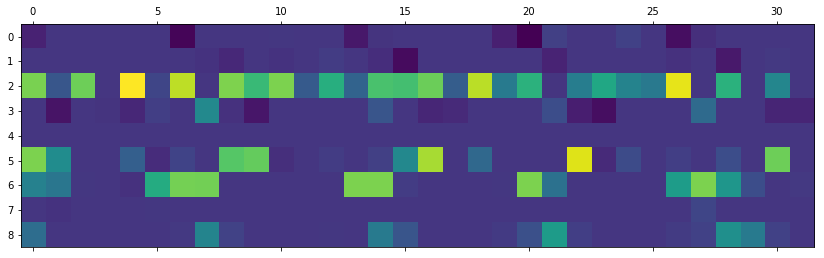

In [ ]:
from keras.utils import to_categorical 

batch_size = 32
nb_epochs = 500
nb_samples = matrices_drums.shape[0]

K_unrolled = 4
MAX_LOSS_RATIO = 3.0

# Labels for real images: all ones
real_labels = np.ones((batch_size, 1)) * 0.9 # one-sided soft labeling for better stability

# Labels for fake images: all zeros
fake_labels = np.zeros((batch_size, 1))

train_d = True
train_g = True

for epoch in range(0, nb_epochs):
    nb_steps = int(nb_samples/batch_size)
    
    for repeat in range(nb_steps):
        step = nb_steps * epoch + repeat
        
        if train_d:
            
            m_d_loss = 0.0
            m_d_accuracy = 0.0
            m_d_loss_cat = 0.0
            m_d_cat_accuracy = 0.0
            
            for j in range(K_unrolled):
                # training data
                random_indices = np.random.randint(0, matrices_drums.shape[0], size=batch_size)
                drum_train = matrices_drums[random_indices, :, :]
                labels_traing = matrices_genres[random_indices]
                labels_traing_categorical = to_categorical(labels_traing, num_classes=NB_GENRES)


                # generated samples
                noise = get_noise(batch_size, len_input)
                drum_fake = generator.predict([noise, labels_traing])

                # training D
                d_loss_real = discriminator.train_on_batch([drum_train, labels_traing], [real_labels, labels_traing_categorical])
                d_loss_fake = discriminator.train_on_batch([drum_fake,labels_traing], [fake_labels, labels_traing_categorical])
    
                _, d_loss, d_loss_cat, accuracy, cat_accuracy = 0.5 * np.add(d_loss_real, d_loss_fake) # averaging
                
                
                m_d_loss += d_loss
                m_d_loss_cat += d_loss_cat
                m_d_accuracy += accuracy
                m_d_cat_accuracy += cat_accuracy
                # cache for later update
    #             cache_weights = discriminator.get_weights()
            
            m_d_loss /= float(K_unrolled)
            m_d_accuracy /= float(K_unrolled)
            m_d_loss_cat /= float(K_unrolled)
            m_d_cat_accuracy /= float(K_unrolled)
           
            # store value
            log_value("D loss", m_d_loss, step)  
            log_value("D accuracy", m_d_accuracy, step)  
            log_value("D category loss", m_d_loss_cat, step)  
            log_value("D category accuracy", m_d_cat_accuracy, step)  
            
        # training G
        
        if train_g:
            y = np.ones([batch_size, 1]) # watch out the label! it should be one here        

            noise = get_noise(batch_size, len_input)

            # Get a batch of random labels
            labels_random = np.random.randint(0, NB_GENRES, batch_size).reshape(-1, 1)

            _, m_a_loss, m_a_cat_loss = gan.train_on_batch([noise, labels_random], [y, labels_random])
            
            # store value
            log_value("adversarial loss", m_a_loss, step)
            log_value("style amguity loss", m_a_cat_loss, step)
        
        if train_d and train_g:
            if m_a_loss / m_d_loss > MAX_LOSS_RATIO:
                train_d = False
                print "Pausing D"
            elif m_d_loss / m_a_loss > MAX_LOSS_RATIO:
                train_g = False
                print "Pausing G"
        else:
            train_d = True
            train_g = True
            
        # update layer 
#         discriminator.set_weights(cache_weights)
 
        if repeat % 100 == 0:
            
            print("epoch", epoch, repeat)
            print("d_loss", m_d_loss, "d_cat_acc", m_d_cat_accuracy,
                "a_loss", m_a_loss, 'a_cat_loss', m_a_cat_loss) # print mean loss)
            print("d_accuracy", m_d_accuracy )
            
            # sample output
            noise = get_noise(1, len_input)
            labels_random = np.random.randint(0, NB_GENRES, 1).reshape(-1, 1)
            drum_generated = generator.predict([noise, labels_random])
            
            print (labels_random, GENRES[int(labels_random)])
            plot_drum_matrix(drum_generated)
            
            print
            print
            
                        
    # store temporary models
    if (epoch + 1) % 5 == 0:
        generator.save("./tmp/can_generator-epoch-%03d-%0.5f.h5" % (epoch, m_a_loss))
        gan.save("./tmp/can_gan-epoch-%03d-%0.5f.h5" % (epoch, m_a_loss))
        discriminator.save("./tmp/can_discriminator-epoch-%03d-%0.5f.h5" % (epoch, m_d_loss))

In [ ]:
for i in range(3):
    noise = get_noise(1, len_input)
    drum_generated = generator.predict(noise)
    plot_drum_matrix(drum_generated)

# MIDI Playback

In [ ]:
# midi playback
def note_matrix_to_sequence(mat, threshold = 0.5):
    seq = []
    for row in mat[:]:
        arow = [[i, r] for i, r in enumerate(row) if r > threshold]
        seq.append(arow)
    return seq

import OSC
max_poly = 6 # maximum number of instruments played at the same time

client = OSC.OSCClient()
client.connect( ('10.0.1.14', 2014) ) 

def send_sequence_via_osc(seq):
    ## the most basic ##
    msg = OSC.OSCMessage()
    msg.setAddress("/seq")
    msg.append(max_poly * 2)
    
    for notes in seq:
        for i in range(max_poly):
            if len(notes) > i:
                msg.append([notes[i][0]+min_drum_note, notes[i][1]])
            else:
                msg.append([0, 0])
    client.send(msg)
    
def playback_seq_via_osc(mat):
    send_sequence_via_osc(note_matrix_to_sequence(mat, 0.2))

In [ ]:
import time

repeat = 1

for j in range(100):
    noise1 = get_noise(1, len_input) 
    noise2 = get_noise(1, len_input) 
    
    for i in range(repeat):
        noise = noise1 * (1.0 - i/float(repeat)) + noise2 * i/float(repeat)
        drum_generated = generator.predict(noise)
        mat = np.squeeze(drum_generated)
        playback_seq_via_osc(mat)
        time.sleep(4.0)
        clear_output(wait=True)